# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [4]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        #w = 0.1*F.tanh(w) # [-0.5,+0.5]
        w=F.softmax(w,dim=2)
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [8]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [9]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [10]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [11]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.359285, Accuracy: 9.38
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.472120, Accuracy: 10.94
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.347837, Accuracy: 10.55
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.305728, Accuracy: 22.66
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.162165, Accuracy: 19.14
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.046688, Accuracy: 18.36
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.049781, Accuracy: 17.97
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.073025, Accuracy: 17.58
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.897658, Accuracy: 26.17
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.959618, Accuracy: 23.44
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.979218, Accuracy: 22.66
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.882938, Accuracy: 21.48
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.806206, Accuracy: 26.95
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.845226, Accuracy: 28.52
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.862444, Accuracy: 27.34
Train Epoch

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.016163, Accuracy: 65.62
Train Epoch: 3 [15360/50000 (34%)]	Loss: 0.994353, Accuracy: 67.19
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.150286, Accuracy: 58.20
Train Epoch: 3 [17920/50000 (40%)]	Loss: 0.969005, Accuracy: 65.23
Train Epoch: 3 [19200/50000 (43%)]	Loss: 0.994883, Accuracy: 66.41
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.205903, Accuracy: 57.42
Train Epoch: 3 [21760/50000 (48%)]	Loss: 0.925039, Accuracy: 70.70
torch.Size([512, 1, 1])
tensor([[[ 1.2284]],

        [[ 1.0812]],

        [[-0.9273]],

        [[ 1.8840]],

        [[-0.2919]],

        [[-0.1451]],

        [[-0.7612]],

        [[ 0.4382]],

        [[-1.3480]],

        [[ 0.4332]],

        [[ 2.0741]],

        [[-0.1061]],

        [[-1.1682]],

        [[ 0.2992]],

        [[-0.1322]],

        [[-2.2097]],

        [[-0.4632]],

        [[ 0.2378]],

        [[-0.6353]],

        [[-0.6277]],

        [[ 0.3504]],

        [[-1.0125]],

        [[-0.1616]],

 

Train Epoch: 3 [24320/50000 (54%)]	Loss: 0.918392, Accuracy: 70.70
Train Epoch: 3 [25600/50000 (57%)]	Loss: 0.955474, Accuracy: 65.23
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.061972, Accuracy: 60.16
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.069757, Accuracy: 64.06
Train Epoch: 3 [29440/50000 (65%)]	Loss: 0.981411, Accuracy: 63.67
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.022831, Accuracy: 63.67
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.104612, Accuracy: 62.11
Train Epoch: 3 [33280/50000 (74%)]	Loss: 0.935881, Accuracy: 67.58
Train Epoch: 3 [34560/50000 (77%)]	Loss: 1.062888, Accuracy: 58.20
Train Epoch: 3 [35840/50000 (80%)]	Loss: 0.921019, Accuracy: 68.36
Train Epoch: 3 [37120/50000 (82%)]	Loss: 0.961975, Accuracy: 64.45
Train Epoch: 3 [38400/50000 (85%)]	Loss: 0.899874, Accuracy: 71.48
Train Epoch: 3 [39680/50000 (88%)]	Loss: 0.914983, Accuracy: 67.19
Train Epoch: 3 [40960/50000 (91%)]	Loss: 1.064677, Accuracy: 61.72
Train Epoch: 3 [42240/50000 (94%)]	Loss: 0.982857, Accuracy: 6

torch.Size([512, 1, 1])
tensor([[[-0.5016]],

        [[-0.6353]],

        [[-0.8913]],

        [[ 1.1776]],

        [[-0.3291]],

        [[-0.0379]],

        [[ 1.2479]],

        [[ 0.8720]],

        [[-1.4519]],

        [[-0.0791]],

        [[ 0.8527]],

        [[ 0.0323]],

        [[-0.4393]],

        [[ 0.7989]],

        [[-0.8461]],

        [[ 0.7812]],

        [[-1.5306]],

        [[ 0.2510]],

        [[-0.0634]],

        [[ 0.0140]],

        [[-0.0540]],

        [[ 1.4210]],

        [[ 1.4642]],

        [[ 0.0670]],

        [[ 0.5797]],

        [[ 0.0883]],

        [[ 1.0654]],

        [[-0.4832]],

        [[-0.7012]],

        [[ 0.5341]],

        [[-0.7334]],

        [[ 0.3349]],

        [[ 0.3754]],

        [[ 0.6685]],

        [[-1.2497]],

        [[-2.5097]],

        [[-2.2037]],

        [[ 0.7128]],

        [[ 1.8485]],

        [[-2.2010]],

        [[-0.8095]],

        [[-1.8532]],

        [[ 0.5552]],

        [[-0.9642]],

        

Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.622998, Accuracy: 80.08
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.743133, Accuracy: 74.61
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.543021, Accuracy: 80.47
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.683942, Accuracy: 74.61
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.612718, Accuracy: 80.08
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.644565, Accuracy: 78.12
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.728220, Accuracy: 77.00

Validation set: Average loss: 1.0686, Accuracy: 3298/5000 (65.00%)

the time of this epoch:[37.70140600204468 s]
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.682036, Accuracy: 77.73
Train Epoch: 7 [1280/50000 (3%)]	Loss: 0.656200, Accuracy: 76.95
Train Epoch: 7 [2560/50000 (6%)]	Loss: 0.694618, Accuracy: 75.78
Train Epoch: 7 [3840/50000 (9%)]	Loss: 0.591799, Accuracy: 77.73
Train Epoch: 7 [5120/50000 (11%)]	Loss: 0.575384, Accuracy: 83.98
Train Epoch: 7 [6400/50000 (14%)]	Loss: 0.767364, Accuracy: 75.39
Train Epoch: 7 [7680/50000 (

Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.542172, Accuracy: 81.25
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.624264, Accuracy: 78.12
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.709508, Accuracy: 75.78
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.509201, Accuracy: 84.38
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.498300, Accuracy: 85.16
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.549103, Accuracy: 81.64
Train Epoch: 10 [10240/50000 (23%)]	Loss: 0.577531, Accuracy: 78.52
Train Epoch: 10 [11520/50000 (26%)]	Loss: 0.637322, Accuracy: 78.12
Train Epoch: 10 [12800/50000 (28%)]	Loss: 0.659880, Accuracy: 78.12
Train Epoch: 10 [14080/50000 (31%)]	Loss: 0.611493, Accuracy: 79.30
Train Epoch: 10 [15360/50000 (34%)]	Loss: 0.472183, Accuracy: 82.81
Train Epoch: 10 [16640/50000 (37%)]	Loss: 0.538978, Accuracy: 82.42
Train Epoch: 10 [17920/50000 (40%)]	Loss: 0.597824, Accuracy: 79.30
Train Epoch: 10 [19200/50000 (43%)]	Loss: 0.473269, Accuracy: 84.38
Train Epoch: 10 [20480/50000 (45%)]	Loss: 0.564250, Accu

torch.Size([512, 1, 1])
tensor([[[ 0.8506]],

        [[ 0.2189]],

        [[-0.7338]],

        [[ 0.3965]],

        [[ 0.1411]],

        [[-0.1044]],

        [[ 0.1244]],

        [[ 0.5576]],

        [[-2.0908]],

        [[-1.0082]],

        [[-1.2486]],

        [[-0.4540]],

        [[ 0.5282]],

        [[-1.0230]],

        [[ 0.1953]],

        [[ 0.1719]],

        [[-1.2017]],

        [[-0.7731]],

        [[ 0.0423]],

        [[ 0.4552]],

        [[-0.7760]],

        [[ 1.4340]],

        [[-0.5512]],

        [[ 0.4496]],

        [[ 1.0314]],

        [[ 0.3137]],

        [[ 0.9439]],

        [[-0.6474]],

        [[-0.3406]],

        [[-1.4314]],

        [[ 2.6848]],

        [[ 0.1387]],

        [[ 0.1566]],

        [[-0.9800]],

        [[ 1.1290]],

        [[ 1.0181]],

        [[-0.4709]],

        [[ 1.4304]],

        [[ 0.7526]],

        [[ 1.3307]],

        [[ 0.7178]],

        [[-1.4481]],

        [[-2.0858]],

        [[-0.3208]],

        

torch.Size([512, 1, 1])
tensor([[[-0.6366]],

        [[ 0.9936]],

        [[ 0.5710]],

        [[ 0.6299]],

        [[ 2.1062]],

        [[ 0.0746]],

        [[ 0.5178]],

        [[ 0.4374]],

        [[-0.5191]],

        [[-1.6357]],

        [[ 1.7815]],

        [[ 0.5374]],

        [[-2.2172]],

        [[ 0.0306]],

        [[ 1.3825]],

        [[ 1.3995]],

        [[-1.1677]],

        [[ 1.3578]],

        [[ 0.1163]],

        [[ 1.1218]],

        [[ 0.9987]],

        [[-0.4886]],

        [[ 0.7302]],

        [[-1.6713]],

        [[ 0.0964]],

        [[ 0.4132]],

        [[ 1.1364]],

        [[-0.4502]],

        [[-0.2795]],

        [[-0.0110]],

        [[-0.2333]],

        [[ 1.3566]],

        [[-0.2009]],

        [[-0.1304]],

        [[-0.5859]],

        [[-0.0327]],

        [[-0.7034]],

        [[-1.2854]],

        [[-0.9269]],

        [[ 2.1710]],

        [[ 0.1883]],

        [[ 0.3000]],

        [[-0.1446]],

        [[ 0.6148]],

        

torch.Size([512, 1, 1])
tensor([[[-1.4523]],

        [[ 0.5058]],

        [[-0.8597]],

        [[-0.0106]],

        [[-0.9490]],

        [[ 0.0896]],

        [[-0.5559]],

        [[ 0.4432]],

        [[-0.6519]],

        [[ 1.0206]],

        [[-1.2227]],

        [[-0.4399]],

        [[ 0.4517]],

        [[ 0.1970]],

        [[-1.3393]],

        [[-0.2473]],

        [[ 0.1870]],

        [[-0.1323]],

        [[ 0.6741]],

        [[ 0.4838]],

        [[-1.6974]],

        [[ 0.3839]],

        [[-1.9858]],

        [[-1.1402]],

        [[ 0.4847]],

        [[-0.5822]],

        [[-0.3312]],

        [[ 0.6906]],

        [[-0.8408]],

        [[ 0.4958]],

        [[ 1.1048]],

        [[ 0.3332]],

        [[ 0.2849]],

        [[ 2.5361]],

        [[-1.6327]],

        [[ 1.1846]],

        [[ 1.2902]],

        [[-1.2291]],

        [[-1.1171]],

        [[ 0.0931]],

        [[ 1.4440]],

        [[-2.0749]],

        [[-0.6347]],

        [[ 0.2616]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.6786]],

        [[-0.1699]],

        [[ 1.0442]],

        [[ 0.9605]],

        [[ 3.1624]],

        [[-0.2205]],

        [[-0.8327]],

        [[-1.0894]],

        [[ 1.4721]],

        [[ 1.0581]],

        [[-0.4644]],

        [[-2.8195]],

        [[ 0.9448]],

        [[-0.5534]],

        [[-0.5451]],

        [[-0.2513]],

        [[-0.8574]],

        [[-1.0182]],

        [[-0.7282]],

        [[ 0.4691]],

        [[-1.1881]],

        [[ 0.0002]],

        [[-0.6856]],

        [[-0.7717]],

        [[ 0.0300]],

        [[ 1.1341]],

        [[ 0.3885]],

        [[-0.3551]],

        [[-0.4011]],

        [[ 1.0985]],

        [[ 0.9371]],

        [[-0.4854]],

        [[ 0.3432]],

        [[ 0.7130]],

        [[ 0.2814]],

        [[-0.9156]],

        [[-0.1521]],

        [[ 0.5265]],

        [[ 0.3032]],

        [[-0.5691]],

        [[ 1.2141]],

        [[ 0.7072]],

        [[ 0.4501]],

        [[-0.5060]],

        

torch.Size([512, 1, 1])
tensor([[[-0.3772]],

        [[ 1.0412]],

        [[-1.3740]],

        [[-0.3570]],

        [[-1.0074]],

        [[ 0.7014]],

        [[ 1.0134]],

        [[-0.3685]],

        [[-1.4464]],

        [[ 0.8622]],

        [[ 1.2038]],

        [[ 0.2893]],

        [[ 0.7995]],

        [[-0.9616]],

        [[-1.1255]],

        [[-0.5608]],

        [[-0.1856]],

        [[-0.4942]],

        [[ 0.5040]],

        [[ 0.5121]],

        [[-0.7324]],

        [[ 0.7188]],

        [[-0.1148]],

        [[-0.8819]],

        [[ 1.2418]],

        [[-0.4870]],

        [[ 0.4269]],

        [[-0.5183]],

        [[ 0.2454]],

        [[ 0.0528]],

        [[-2.2671]],

        [[ 1.1019]],

        [[-1.6375]],

        [[ 0.5926]],

        [[-0.3202]],

        [[-0.4595]],

        [[-1.1001]],

        [[-0.1825]],

        [[ 0.4129]],

        [[-0.2114]],

        [[-0.0435]],

        [[ 1.0129]],

        [[-0.2957]],

        [[ 0.9918]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.1339]],

        [[-0.3339]],

        [[ 1.1665]],

        ...,

        [[-0.1930]],

        [[-0.7521]],

        [[-0.1502]]], device='cuda:0')
Parameter containing:
tensor([[[ 0.1152]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-03 *
       [[[ 1.0222,  1.0061,  1.0218,  ...,  0.9223,  0.9095,  0.9001],
         [ 1.0372,  1.0168,  1.0439,  ...,  0.9077,  0.9069,  0.9429],
         [ 0.9986,  1.0459,  1.0182,  ...,  0.9475,  0.9980,  0.9591],
         ...,
         [ 0.9660,  0.9922,  1.0087,  ...,  0.9281,  0.9363,  0.9141],
         [ 0.9916,  0.9881,  1.0038,  ...,  1.0485,  1.0057,  1.0443],
         [ 0.9631,  0.9805,  0.9726,  ...,  0.9715,  0.9793,  0.9770]]], device='cuda:0')

Test set: Average loss: 0.9395, Accuracy: 7021/10000 (70.21%)

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.493823, Accuracy: 81.25
Train Epoch: 11 [1280/50000 (3%)]	Loss: 0.515414, Accuracy: 80.47
Train Epoch: 11 [2560/50000 (6%)]	Loss: 0.663096, A

torch.Size([512, 1, 1])
tensor([[[ 0.9387]],

        [[-1.1934]],

        [[-0.0303]],

        [[ 2.1887]],

        [[-0.1681]],

        [[-0.6131]],

        [[ 1.2532]],

        [[ 0.0800]],

        [[-0.1010]],

        [[-0.0205]],

        [[ 0.8179]],

        [[-1.0736]],

        [[-1.1989]],

        [[ 0.3523]],

        [[ 0.9795]],

        [[ 1.0153]],

        [[-1.2394]],

        [[ 0.6299]],

        [[-0.7110]],

        [[-0.9866]],

        [[ 1.4204]],

        [[-0.1223]],

        [[ 0.1687]],

        [[-0.1373]],

        [[ 0.1809]],

        [[-0.2384]],

        [[-0.0576]],

        [[ 0.1871]],

        [[ 0.0032]],

        [[ 0.9352]],

        [[ 0.0113]],

        [[ 0.5541]],

        [[-0.4367]],

        [[ 1.6435]],

        [[-1.4156]],

        [[ 0.9336]],

        [[-1.1079]],

        [[ 1.0873]],

        [[ 1.1151]],

        [[ 1.0481]],

        [[-2.7596]],

        [[ 1.2769]],

        [[-0.1200]],

        [[-0.9249]],

        

torch.Size([512, 1, 1])
tensor([[[-0.8306]],

        [[ 0.9947]],

        [[-1.3493]],

        [[ 0.1848]],

        [[ 0.4196]],

        [[-0.6620]],

        [[ 0.6558]],

        [[ 0.0846]],

        [[ 0.5195]],

        [[ 1.8505]],

        [[-2.0229]],

        [[ 0.9302]],

        [[ 0.2381]],

        [[ 0.4742]],

        [[ 0.0267]],

        [[-0.9047]],

        [[ 0.1709]],

        [[-1.4489]],

        [[ 0.2258]],

        [[ 0.4625]],

        [[ 0.9847]],

        [[ 0.1095]],

        [[-0.0275]],

        [[-1.1468]],

        [[ 1.1459]],

        [[ 0.5036]],

        [[ 0.0444]],

        [[-1.4064]],

        [[-1.1207]],

        [[-1.7546]],

        [[ 0.4624]],

        [[ 1.1066]],

        [[ 0.6763]],

        [[-1.0971]],

        [[-0.0319]],

        [[-0.2235]],

        [[-0.4907]],

        [[ 0.1751]],

        [[ 0.9636]],

        [[ 0.4422]],

        [[-1.7711]],

        [[ 0.4039]],

        [[ 0.8534]],

        [[ 0.6594]],

        

torch.Size([512, 1, 1])
tensor([[[-2.0966]],

        [[-0.2941]],

        [[ 0.7439]],

        [[ 0.1933]],

        [[ 0.8278]],

        [[ 0.2717]],

        [[ 1.1651]],

        [[ 0.1147]],

        [[-0.1668]],

        [[-0.1258]],

        [[-0.2002]],

        [[ 0.4338]],

        [[-0.1169]],

        [[ 0.3463]],

        [[-0.0482]],

        [[-0.5512]],

        [[-1.4145]],

        [[-0.3382]],

        [[ 0.5564]],

        [[-0.1246]],

        [[-1.1353]],

        [[-1.0200]],

        [[ 1.0131]],

        [[-0.6857]],

        [[-0.3057]],

        [[-2.1826]],

        [[-0.5253]],

        [[-0.0574]],

        [[-0.6587]],

        [[ 0.8889]],

        [[-0.7688]],

        [[-0.9507]],

        [[ 0.9486]],

        [[ 0.0666]],

        [[ 0.3349]],

        [[ 1.2945]],

        [[ 0.3448]],

        [[ 0.1807]],

        [[-1.0099]],

        [[-0.3704]],

        [[ 1.8314]],

        [[ 1.0843]],

        [[ 0.1546]],

        [[ 0.7686]],

        

torch.Size([512, 1, 1])
tensor([[[-0.6049]],

        [[-0.2112]],

        [[-0.1298]],

        [[ 0.4442]],

        [[-0.3618]],

        [[ 0.7084]],

        [[-0.3850]],

        [[-0.2203]],

        [[-0.0696]],

        [[ 2.1568]],

        [[ 0.5928]],

        [[ 0.3699]],

        [[ 0.8804]],

        [[ 0.7308]],

        [[-1.0731]],

        [[ 3.3714]],

        [[-2.1984]],

        [[ 0.8553]],

        [[ 0.1211]],

        [[ 2.1121]],

        [[-1.5508]],

        [[ 0.5781]],

        [[-0.2409]],

        [[ 0.3734]],

        [[ 0.6932]],

        [[ 1.1657]],

        [[ 1.9465]],

        [[ 0.5925]],

        [[-0.7837]],

        [[ 1.3408]],

        [[ 0.4858]],

        [[ 1.0070]],

        [[ 0.1675]],

        [[ 0.5649]],

        [[ 0.1849]],

        [[ 0.9522]],

        [[-1.2281]],

        [[-0.7452]],

        [[ 0.2842]],

        [[-0.4475]],

        [[ 0.3048]],

        [[-0.6819]],

        [[-0.1834]],

        [[ 1.2498]],

        

torch.Size([512, 1, 1])
tensor([[[-0.9578]],

        [[-0.7325]],

        [[ 1.9311]],

        [[-0.3377]],

        [[-0.8193]],

        [[-2.2858]],

        [[-1.7635]],

        [[-1.1970]],

        [[-0.0603]],

        [[ 0.0823]],

        [[ 0.3012]],

        [[-0.6902]],

        [[-1.0469]],

        [[-1.4446]],

        [[ 0.6206]],

        [[ 0.1060]],

        [[-0.6802]],

        [[-1.7151]],

        [[-0.7420]],

        [[ 0.0602]],

        [[ 0.0605]],

        [[ 2.1424]],

        [[ 0.7059]],

        [[-0.2892]],

        [[-0.4620]],

        [[ 1.8937]],

        [[-0.0275]],

        [[ 0.7614]],

        [[ 1.3148]],

        [[ 0.3315]],

        [[-0.3665]],

        [[ 1.0229]],

        [[ 0.9861]],

        [[-1.6361]],

        [[-2.7924]],

        [[ 0.0083]],

        [[-0.2561]],

        [[-0.9486]],

        [[-0.9594]],

        [[-0.0633]],

        [[ 0.5235]],

        [[-0.7963]],

        [[ 1.6181]],

        [[-0.4331]],

        


Test set: Average loss: 0.8704, Accuracy: 7309/10000 (73.09%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.456696, Accuracy: 84.38
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.409239, Accuracy: 88.28
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.419783, Accuracy: 87.11
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.620347, Accuracy: 80.86
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.461737, Accuracy: 83.98
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.542523, Accuracy: 81.25
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.597125, Accuracy: 80.86
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.519378, Accuracy: 84.38
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.474529, Accuracy: 82.42
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.447394, Accuracy: 84.77
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.550078, Accuracy: 79.69
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.502917, Accuracy: 81.64
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.500875, Accuracy: 82.81
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.638314, Accuracy: 78.52

Train Epoch: 14 [30720/50000 (68%)]	Loss: 0.520613, Accuracy: 80.47
Train Epoch: 14 [32000/50000 (71%)]	Loss: 0.653450, Accuracy: 80.08
Train Epoch: 14 [33280/50000 (74%)]	Loss: 0.502966, Accuracy: 82.42
Train Epoch: 14 [34560/50000 (77%)]	Loss: 0.457328, Accuracy: 86.72
Train Epoch: 14 [35840/50000 (80%)]	Loss: 0.412588, Accuracy: 85.16
Train Epoch: 14 [37120/50000 (82%)]	Loss: 0.432942, Accuracy: 82.81
Train Epoch: 14 [38400/50000 (85%)]	Loss: 0.430034, Accuracy: 84.77
Train Epoch: 14 [39680/50000 (88%)]	Loss: 0.519171, Accuracy: 81.64
Train Epoch: 14 [40960/50000 (91%)]	Loss: 0.572857, Accuracy: 80.47
Train Epoch: 14 [42240/50000 (94%)]	Loss: 0.415302, Accuracy: 86.33
Train Epoch: 14 [43520/50000 (97%)]	Loss: 0.532587, Accuracy: 85.16
Train Epoch: 14 [35000/50000 (99%)]	Loss: 0.529606, Accuracy: 81.50

Validation set: Average loss: 0.7446, Accuracy: 3783/5000 (75.00%)

the time of this epoch:[37.69779348373413 s]
torch.Size([512, 1, 1])
tensor([[[-2.7079]],

        [[ 0.7645]],

  

torch.Size([1024, 1, 1])
tensor([[[-1.6158]],

        [[ 0.6503]],

        [[-0.3743]],

        ...,

        [[ 0.6952]],

        [[ 0.0264]],

        [[-0.0191]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 8.0622]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-03 *
       [[[ 0.9805,  0.9775,  1.0009,  ...,  0.9413,  0.9275,  0.9358],
         [ 0.9946,  1.0060,  0.9963,  ...,  0.9437,  0.9333,  0.9423],
         [ 1.0029,  0.9997,  0.9902,  ...,  0.9665,  0.9803,  0.9499],
         ...,
         [ 0.9682,  0.9748,  0.9723,  ...,  0.9630,  0.9553,  0.9407],
         [ 0.9874,  0.9864,  0.9897,  ...,  0.9906,  0.9903,  1.0129],
         [ 0.9521,  0.9654,  0.9841,  ...,  0.9563,  0.9804,  0.9821]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 1.1817]],

        [[ 0.6664]],

        [[-0.0071]],

        [[-0.2671]],

        [[ 0.6484]],

        [[-0.3077]],

        [[ 0.1188]],

        [[-0.7881]],

        [[-0.0681]],

 

torch.Size([512, 1, 1])
tensor([[[-0.4444]],

        [[ 0.7933]],

        [[-1.4038]],

        [[ 0.8259]],

        [[-0.4679]],

        [[ 0.9876]],

        [[-0.1432]],

        [[ 0.6619]],

        [[ 0.5320]],

        [[-2.4544]],

        [[-0.4591]],

        [[ 0.8282]],

        [[-0.0283]],

        [[ 0.5606]],

        [[-1.9671]],

        [[ 0.2677]],

        [[ 0.6605]],

        [[ 2.7214]],

        [[ 1.4040]],

        [[-1.1489]],

        [[-0.2328]],

        [[-0.4670]],

        [[-0.0819]],

        [[-0.6364]],

        [[-0.2698]],

        [[-0.5404]],

        [[-0.9964]],

        [[-1.9877]],

        [[-0.6444]],

        [[ 0.2027]],

        [[-0.0930]],

        [[ 0.3171]],

        [[-0.5953]],

        [[-0.4197]],

        [[-0.8295]],

        [[-0.8201]],

        [[ 0.7666]],

        [[-0.1302]],

        [[-0.3150]],

        [[-0.0566]],

        [[-0.5538]],

        [[-0.8155]],

        [[-0.4058]],

        [[-0.0452]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.6491]],

        [[-1.0535]],

        [[ 0.7037]],

        [[-0.2202]],

        [[-0.9459]],

        [[-1.5407]],

        [[-0.8931]],

        [[ 0.3589]],

        [[ 0.9074]],

        [[-1.0207]],

        [[ 0.4763]],

        [[ 0.5556]],

        [[-1.0929]],

        [[-0.5271]],

        [[-1.1205]],

        [[ 2.2642]],

        [[-0.7804]],

        [[ 0.3065]],

        [[ 0.0253]],

        [[-2.0181]],

        [[-1.3004]],

        [[ 0.1062]],

        [[ 0.9907]],

        [[ 1.3614]],

        [[ 0.9474]],

        [[ 0.5147]],

        [[ 0.2481]],

        [[-1.4032]],

        [[ 1.3880]],

        [[-0.2994]],

        [[ 1.4484]],

        [[ 2.3085]],

        [[-2.5439]],

        [[-1.6994]],

        [[-0.5037]],

        [[ 0.6978]],

        [[ 0.4985]],

        [[-0.0188]],

        [[ 0.3819]],

        [[ 0.1811]],

        [[ 1.0252]],

        [[ 1.9000]],

        [[-1.1443]],

        [[ 0.6601]],

        

torch.Size([512, 1, 1])
tensor([[[-1.0093]],

        [[-0.0853]],

        [[ 0.3940]],

        [[ 0.6253]],

        [[-0.5256]],

        [[ 0.7331]],

        [[ 1.7616]],

        [[-1.4021]],

        [[-0.7639]],

        [[-0.0052]],

        [[ 0.2711]],

        [[ 0.1222]],

        [[-0.2845]],

        [[ 0.0948]],

        [[-1.0042]],

        [[ 1.7499]],

        [[ 0.1896]],

        [[-1.0009]],

        [[ 0.6878]],

        [[ 0.2723]],

        [[ 0.5084]],

        [[-0.0233]],

        [[ 2.3355]],

        [[ 1.6820]],

        [[ 0.0788]],

        [[-1.6199]],

        [[-0.4088]],

        [[-0.6412]],

        [[ 0.8602]],

        [[ 0.1618]],

        [[ 0.1339]],

        [[-0.4033]],

        [[-1.0102]],

        [[ 1.8071]],

        [[ 0.0526]],

        [[-0.3545]],

        [[-0.3778]],

        [[ 0.6378]],

        [[-0.4477]],

        [[-0.7698]],

        [[ 0.8457]],

        [[-1.3125]],

        [[ 0.1852]],

        [[ 1.1983]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.0044]],

        [[ 1.7928]],

        [[ 0.2283]],

        [[ 0.6104]],

        [[ 1.0128]],

        [[-0.0639]],

        [[-0.4700]],

        [[-0.5265]],

        [[ 0.8835]],

        [[ 0.7710]],

        [[ 1.2127]],

        [[ 1.2060]],

        [[ 2.2189]],

        [[ 1.2866]],

        [[ 0.1027]],

        [[-0.7446]],

        [[-0.5061]],

        [[-0.7742]],

        [[ 0.0985]],

        [[-0.8263]],

        [[ 1.2175]],

        [[-0.1117]],

        [[ 0.9554]],

        [[ 1.5348]],

        [[-0.3372]],

        [[-0.0807]],

        [[ 1.5746]],

        [[-1.5863]],

        [[-0.9579]],

        [[ 0.4189]],

        [[-0.7340]],

        [[ 1.0208]],

        [[-0.4960]],

        [[ 0.3072]],

        [[-1.3818]],

        [[-1.2661]],

        [[ 0.5278]],

        [[ 0.7551]],

        [[-0.7089]],

        [[ 0.1394]],

        [[ 0.3867]],

        [[-0.3844]],

        [[ 1.5775]],

        [[-0.5988]],

        


Test set: Average loss: 0.7310, Accuracy: 7630/10000 (76.30%)

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.420781, Accuracy: 86.33
Train Epoch: 15 [1280/50000 (3%)]	Loss: 0.474008, Accuracy: 84.38
Train Epoch: 15 [2560/50000 (6%)]	Loss: 0.477568, Accuracy: 84.77
Train Epoch: 15 [3840/50000 (9%)]	Loss: 0.431783, Accuracy: 85.94
Train Epoch: 15 [5120/50000 (11%)]	Loss: 0.425972, Accuracy: 83.98
Train Epoch: 15 [6400/50000 (14%)]	Loss: 0.467124, Accuracy: 84.77
Train Epoch: 15 [7680/50000 (17%)]	Loss: 0.533528, Accuracy: 80.47
Train Epoch: 15 [8960/50000 (20%)]	Loss: 0.408324, Accuracy: 86.72
Train Epoch: 15 [10240/50000 (23%)]	Loss: 0.562651, Accuracy: 81.25
Train Epoch: 15 [11520/50000 (26%)]	Loss: 0.529456, Accuracy: 80.86
Train Epoch: 15 [12800/50000 (28%)]	Loss: 0.542077, Accuracy: 84.38
Train Epoch: 15 [14080/50000 (31%)]	Loss: 0.430712, Accuracy: 86.33
Train Epoch: 15 [15360/50000 (34%)]	Loss: 0.535111, Accuracy: 82.03
Train Epoch: 15 [16640/50000 (37%)]	Loss: 0.552005, Accuracy: 78.91

torch.Size([512, 1, 1])
tensor([[[-1.4384]],

        [[-0.7822]],

        [[ 0.7984]],

        [[-1.3535]],

        [[-0.3386]],

        [[ 0.0058]],

        [[ 1.7716]],

        [[-0.6876]],

        [[-0.0828]],

        [[ 0.1626]],

        [[ 0.0345]],

        [[ 0.1703]],

        [[ 2.0926]],

        [[-0.0079]],

        [[ 0.3457]],

        [[-0.5005]],

        [[ 0.0190]],

        [[-0.1707]],

        [[ 1.2898]],

        [[ 0.0486]],

        [[-0.4044]],

        [[-0.9368]],

        [[-0.3911]],

        [[-0.6757]],

        [[-0.1734]],

        [[-0.5240]],

        [[ 0.8753]],

        [[-1.7664]],

        [[-1.3987]],

        [[ 1.2448]],

        [[-3.2976]],

        [[-0.1708]],

        [[-0.8803]],

        [[-0.6884]],

        [[ 0.5384]],

        [[-1.2446]],

        [[ 0.3895]],

        [[ 0.3413]],

        [[-1.5778]],

        [[ 0.0476]],

        [[-0.8324]],

        [[ 1.3611]],

        [[ 1.6141]],

        [[ 0.3687]],

        

torch.Size([512, 1, 1])
tensor([[[-1.1014]],

        [[-1.5309]],

        [[ 0.3283]],

        [[ 0.8043]],

        [[-0.3426]],

        [[-1.7852]],

        [[ 1.3689]],

        [[ 0.3745]],

        [[-1.2949]],

        [[ 1.4805]],

        [[-1.1364]],

        [[-1.7768]],

        [[ 1.1094]],

        [[-2.1278]],

        [[-0.5473]],

        [[ 0.1958]],

        [[ 1.1174]],

        [[-1.9739]],

        [[ 0.3377]],

        [[-0.3311]],

        [[-2.4506]],

        [[ 0.4584]],

        [[ 0.7503]],

        [[-0.9502]],

        [[-1.0812]],

        [[ 0.6089]],

        [[-0.9192]],

        [[ 1.2320]],

        [[ 0.0714]],

        [[-0.0213]],

        [[-0.5875]],

        [[-1.3921]],

        [[-0.5391]],

        [[ 0.3141]],

        [[ 1.0242]],

        [[ 0.1071]],

        [[-1.7089]],

        [[-1.0502]],

        [[ 2.4204]],

        [[ 0.4938]],

        [[-0.3813]],

        [[ 0.4567]],

        [[ 0.0975]],

        [[ 0.9367]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.1372]],

        [[ 0.5728]],

        [[ 1.6509]],

        ...,

        [[-0.3949]],

        [[ 0.7213]],

        [[-0.6986]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 6.7453]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-03 *
       [[[ 1.0035,  0.9965,  0.9954,  ...,  0.9524,  0.9459,  0.9593],
         [ 1.0020,  0.9962,  0.9863,  ...,  0.9545,  0.9584,  0.9600],
         [ 0.9885,  0.9883,  0.9902,  ...,  0.9808,  0.9738,  0.9748],
         ...,
         [ 0.9858,  0.9925,  0.9910,  ...,  0.9692,  0.9580,  0.9548],
         [ 0.9755,  0.9795,  0.9768,  ...,  0.9883,  0.9948,  0.9983],
         [ 0.9749,  0.9769,  0.9761,  ...,  0.9705,  0.9733,  0.9786]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 0.1986]],

        [[-0.7254]],

        [[-0.0876]],

        [[ 0.3161]],

        [[ 1.2238]],

        [[ 0.3398]],

        [[ 1.4126]],

        [[-0.6613]],

        [[ 0.5401]],

 

torch.Size([512, 1, 1])
tensor([[[-0.7969]],

        [[ 1.7789]],

        [[-0.6208]],

        [[-0.2580]],

        [[ 0.4547]],

        [[-1.6101]],

        [[ 0.6598]],

        [[ 1.2586]],

        [[ 0.6591]],

        [[ 0.1237]],

        [[-0.2808]],

        [[-0.1107]],

        [[ 0.4856]],

        [[ 0.2432]],

        [[ 0.9690]],

        [[-1.0086]],

        [[ 0.5355]],

        [[ 1.7604]],

        [[ 1.2108]],

        [[ 0.0035]],

        [[-2.4596]],

        [[-0.0963]],

        [[-0.0966]],

        [[-0.1981]],

        [[-0.1979]],

        [[ 0.3021]],

        [[-0.5190]],

        [[ 0.5512]],

        [[-2.5452]],

        [[ 0.3514]],

        [[ 0.7658]],

        [[ 1.5926]],

        [[ 1.0544]],

        [[-0.2999]],

        [[ 0.3997]],

        [[-0.2720]],

        [[ 0.9430]],

        [[ 0.8254]],

        [[ 0.4715]],

        [[-1.4041]],

        [[-0.4747]],

        [[-0.3801]],

        [[-1.3657]],

        [[ 0.8527]],

        

torch.Size([512, 1, 1])
tensor([[[-0.5780]],

        [[ 1.1452]],

        [[ 0.8047]],

        [[ 0.3999]],

        [[-1.4544]],

        [[ 1.8907]],

        [[ 0.2719]],

        [[ 0.3085]],

        [[ 0.0621]],

        [[-0.2278]],

        [[ 0.1411]],

        [[-0.6713]],

        [[ 0.0639]],

        [[ 0.3648]],

        [[-0.6486]],

        [[ 0.6606]],

        [[-1.0136]],

        [[-0.2820]],

        [[ 0.2644]],

        [[ 0.5738]],

        [[-0.0236]],

        [[-1.2565]],

        [[ 0.9626]],

        [[-1.0521]],

        [[ 0.9860]],

        [[-0.0573]],

        [[ 0.9061]],

        [[ 1.0507]],

        [[ 0.8568]],

        [[-1.3122]],

        [[-1.5932]],

        [[-0.2419]],

        [[ 0.4293]],

        [[ 0.1892]],

        [[ 0.4059]],

        [[-0.1872]],

        [[ 0.2857]],

        [[-2.2384]],

        [[ 0.7468]],

        [[ 0.8148]],

        [[-2.9434]],

        [[ 1.3295]],

        [[-0.0160]],

        [[-1.7056]],

        

torch.Size([512, 1, 1])
tensor([[[-0.0956]],

        [[ 0.4207]],

        [[-0.9048]],

        [[ 1.3892]],

        [[-0.0816]],

        [[-0.2261]],

        [[ 0.0095]],

        [[-0.4976]],

        [[ 1.0761]],

        [[-0.0783]],

        [[-0.9884]],

        [[-0.6583]],

        [[-1.4957]],

        [[-0.0505]],

        [[-0.4541]],

        [[ 0.4163]],

        [[-0.5120]],

        [[-0.3550]],

        [[-0.5204]],

        [[ 0.6084]],

        [[ 0.5175]],

        [[-1.3146]],

        [[ 0.2810]],

        [[ 0.1740]],

        [[-1.3553]],

        [[ 0.9393]],

        [[-0.4485]],

        [[-0.6585]],

        [[ 0.1161]],

        [[-1.2478]],

        [[ 0.0930]],

        [[-1.3834]],

        [[ 0.0267]],

        [[ 0.0700]],

        [[ 0.1859]],

        [[ 1.0475]],

        [[ 1.3062]],

        [[ 0.8724]],

        [[-0.6639]],

        [[ 1.3822]],

        [[-2.5859]],

        [[-1.2593]],

        [[ 0.6195]],

        [[ 0.0560]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.7215]],

        [[-2.2903]],

        [[ 0.6210]],

        ...,

        [[ 0.3506]],

        [[ 0.8181]],

        [[ 1.8017]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 6.7453]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-03 *
       [[[ 1.0030,  1.0002,  0.9912,  ...,  0.9542,  0.9407,  0.9480],
         [ 1.0102,  0.9926,  0.9994,  ...,  0.9542,  0.9468,  0.9582],
         [ 0.9725,  1.0036,  0.9989,  ...,  0.9674,  0.9849,  0.9625],
         ...,
         [ 0.9682,  0.9730,  0.9916,  ...,  0.9721,  0.9678,  0.9602],
         [ 0.9882,  0.9816,  0.9737,  ...,  0.9939,  0.9789,  0.9967],
         [ 0.9830,  0.9741,  0.9788,  ...,  0.9621,  0.9686,  0.9798]]], device='cuda:0')

Test set: Average loss: 0.7341, Accuracy: 7620/10000 (76.20%)

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.385998, Accuracy: 87.11
Train Epoch: 17 [1280/50000 (3%)]	Loss: 0.447061, Accuracy: 86.33
Train Epoch: 17 [2560/50000 (6

torch.Size([512, 1, 1])
tensor([[[-0.3646]],

        [[ 0.5984]],

        [[ 0.7097]],

        [[ 1.2106]],

        [[ 1.5051]],

        [[ 1.1042]],

        [[-0.9013]],

        [[-0.2354]],

        [[-0.4902]],

        [[ 0.1505]],

        [[-0.7542]],

        [[-1.1918]],

        [[-1.0201]],

        [[ 0.6719]],

        [[ 1.1122]],

        [[-0.6487]],

        [[ 0.3906]],

        [[-0.1979]],

        [[-1.4931]],

        [[-0.4264]],

        [[ 0.5108]],

        [[-2.8078]],

        [[-1.6818]],

        [[ 0.3647]],

        [[ 1.0269]],

        [[-0.9616]],

        [[-0.8600]],

        [[-0.6055]],

        [[ 0.6180]],

        [[-1.9586]],

        [[-0.4967]],

        [[ 0.8451]],

        [[-1.2548]],

        [[-0.1348]],

        [[-0.5946]],

        [[-0.5279]],

        [[-0.0650]],

        [[ 0.0548]],

        [[-0.5121]],

        [[-1.2189]],

        [[ 0.4051]],

        [[ 0.2881]],

        [[-0.7291]],

        [[-0.6290]],

        

torch.Size([512, 1, 1])
tensor([[[-0.0069]],

        [[-2.0656]],

        [[ 0.7003]],

        [[-0.7759]],

        [[-2.0021]],

        [[ 0.2938]],

        [[ 1.0619]],

        [[-1.3222]],

        [[-0.1501]],

        [[-0.2950]],

        [[-0.0589]],

        [[ 0.6272]],

        [[ 0.4814]],

        [[ 1.2150]],

        [[-1.7987]],

        [[ 0.4325]],

        [[-0.6640]],

        [[ 0.7591]],

        [[-0.5304]],

        [[-1.6253]],

        [[-1.0852]],

        [[ 0.4731]],

        [[ 0.6311]],

        [[ 0.4529]],

        [[ 1.4103]],

        [[ 0.4374]],

        [[ 0.1742]],

        [[ 0.1643]],

        [[-1.0559]],

        [[-0.4000]],

        [[-0.7913]],

        [[ 0.1248]],

        [[ 0.9286]],

        [[ 0.3595]],

        [[ 2.3333]],

        [[-1.4516]],

        [[-0.5701]],

        [[ 0.6814]],

        [[-1.7265]],

        [[-0.7238]],

        [[-0.7957]],

        [[-0.9719]],

        [[-0.7326]],

        [[ 2.5770]],

        

torch.Size([1024, 1, 1])
tensor([[[-8.7863e-02]],

        [[ 6.3557e-01]],

        [[ 7.3202e-01]],

        ...,

        [[ 1.0363e+00]],

        [[-1.0455e+00]],

        [[-1.0361e+00]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 5.6569]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-03 *
       [[[ 0.9892,  0.9891,  0.9960,  ...,  0.9576,  0.9652,  0.9609],
         [ 0.9946,  0.9899,  0.9778,  ...,  0.9663,  0.9543,  0.9592],
         [ 0.9864,  0.9858,  0.9770,  ...,  0.9729,  0.9777,  0.9713],
         ...,
         [ 0.9814,  0.9850,  0.9809,  ...,  0.9611,  0.9642,  0.9603],
         [ 0.9773,  0.9796,  0.9766,  ...,  0.9885,  0.9854,  0.9888],
         [ 0.9740,  0.9764,  0.9855,  ...,  0.9646,  0.9783,  0.9858]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.1178]],

        [[ 1.4426]],

        [[ 1.5049]],

        [[ 0.4901]],

        [[-0.8392]],

        [[-0.4145]],

        [[ 0.0373]],

        [[ 0.8204]],


torch.Size([512, 1, 1])
tensor([[[-1.8034]],

        [[-0.9407]],

        [[-0.9503]],

        [[ 0.5067]],

        [[-1.2810]],

        [[-0.7091]],

        [[ 0.9118]],

        [[ 0.4051]],

        [[ 0.0692]],

        [[ 0.5221]],

        [[ 1.7237]],

        [[-0.4243]],

        [[-0.5158]],

        [[-0.1847]],

        [[ 0.3656]],

        [[-2.0424]],

        [[-1.1427]],

        [[-2.2935]],

        [[-1.3123]],

        [[ 1.3043]],

        [[ 0.6885]],

        [[ 0.2685]],

        [[-1.8153]],

        [[-0.5151]],

        [[ 1.8174]],

        [[ 1.4017]],

        [[-2.3070]],

        [[ 0.3395]],

        [[ 0.7901]],

        [[-1.1765]],

        [[ 2.9341]],

        [[-0.3644]],

        [[ 0.0611]],

        [[ 0.9655]],

        [[ 0.0855]],

        [[ 0.3412]],

        [[ 2.9222]],

        [[-0.7008]],

        [[ 0.5480]],

        [[-1.0565]],

        [[-0.5434]],

        [[-1.9881]],

        [[ 0.9886]],

        [[ 0.2354]],

        


Test set: Average loss: 0.7037, Accuracy: 7682/10000 (76.82%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.530664, Accuracy: 82.03
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.457504, Accuracy: 83.98
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.405962, Accuracy: 87.11
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.379966, Accuracy: 87.89
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.424328, Accuracy: 86.72
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.423199, Accuracy: 82.42
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.387794, Accuracy: 87.11
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.404692, Accuracy: 85.16
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.365879, Accuracy: 84.77
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.425011, Accuracy: 86.72
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.421174, Accuracy: 84.38
Train Epoch: 19 [14080/50000 (31%)]	Loss: 0.415801, Accuracy: 86.33
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.402230, Accuracy: 87.11
Train Epoch: 19 [16640/50000 (37%)]	Loss: 0.434961, Accuracy: 86.33

torch.Size([512, 1, 1])
tensor([[[-0.6641]],

        [[ 0.4849]],

        [[ 0.4165]],

        [[ 0.3572]],

        [[-1.1186]],

        [[ 0.3496]],

        [[ 0.2226]],

        [[-0.6092]],

        [[-0.5939]],

        [[ 1.0119]],

        [[ 0.7718]],

        [[-0.8793]],

        [[-0.6826]],

        [[ 0.8686]],

        [[ 1.6054]],

        [[ 0.4310]],

        [[-0.3841]],

        [[-1.5621]],

        [[ 0.1697]],

        [[-0.0716]],

        [[-0.7201]],

        [[-0.2708]],

        [[-0.9572]],

        [[-0.7679]],

        [[ 0.1253]],

        [[-0.0516]],

        [[ 0.1871]],

        [[-0.0610]],

        [[ 0.3458]],

        [[ 0.4979]],

        [[ 1.2545]],

        [[-0.8406]],

        [[ 0.7076]],

        [[ 0.3226]],

        [[-0.0516]],

        [[ 0.4763]],

        [[-2.2628]],

        [[ 0.7849]],

        [[ 0.8398]],

        [[ 0.7071]],

        [[ 0.5071]],

        [[ 0.0194]],

        [[ 0.7363]],

        [[ 0.6332]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.3054]],

        [[-0.1137]],

        [[ 0.4923]],

        [[ 0.7468]],

        [[-0.2562]],

        [[-0.0900]],

        [[-0.0305]],

        [[-0.3079]],

        [[-1.0178]],

        [[-2.1991]],

        [[-0.4955]],

        [[-1.2721]],

        [[-2.5499]],

        [[-0.7319]],

        [[ 1.4875]],

        [[-0.4469]],

        [[ 2.2872]],

        [[-1.3525]],

        [[-1.4771]],

        [[-0.6401]],

        [[-0.3098]],

        [[ 0.4874]],

        [[ 0.1437]],

        [[-0.0621]],

        [[ 1.5357]],

        [[-1.1483]],

        [[ 1.0403]],

        [[-0.0703]],

        [[ 0.9473]],

        [[-0.5845]],

        [[ 0.2943]],

        [[ 0.4378]],

        [[-0.8940]],

        [[ 0.2736]],

        [[ 0.4212]],

        [[ 0.8311]],

        [[-0.3455]],

        [[ 0.3604]],

        [[-0.2867]],

        [[ 1.2835]],

        [[ 0.0352]],

        [[ 0.6108]],

        [[-0.1144]],

        [[-0.2584]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.1983]],

        [[ 1.0430]],

        [[ 0.6373]],

        [[-0.6709]],

        [[-0.2251]],

        [[-0.1325]],

        [[ 2.2814]],

        [[ 2.3047]],

        [[ 0.2286]],

        [[ 0.2882]],

        [[-1.1280]],

        [[ 1.0622]],

        [[-0.0094]],

        [[ 1.1988]],

        [[-0.3797]],

        [[ 0.3777]],

        [[ 0.5432]],

        [[ 0.1986]],

        [[-0.6453]],

        [[ 1.4073]],

        [[-0.8800]],

        [[-0.4786]],

        [[-0.0368]],

        [[-0.7920]],

        [[-0.1388]],

        [[ 1.2551]],

        [[-0.2523]],

        [[-0.4981]],

        [[ 1.4880]],

        [[ 0.1366]],

        [[-0.9025]],

        [[ 0.5215]],

        [[-0.6677]],

        [[ 1.2646]],

        [[ 0.8470]],

        [[-0.7050]],

        [[-0.5556]],

        [[-0.1076]],

        [[-1.6725]],

        [[-0.3768]],

        [[-1.1206]],

        [[ 1.9086]],

        [[-0.3440]],

        [[ 0.8270]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.3508]],

        [[ 0.0124]],

        [[ 2.8592]],

        [[ 0.2996]],

        [[ 1.9760]],

        [[ 1.1018]],

        [[ 0.7616]],

        [[ 0.1012]],

        [[-0.1412]],

        [[ 0.4312]],

        [[ 0.3965]],

        [[-0.4289]],

        [[-0.5654]],

        [[ 0.8058]],

        [[ 0.9367]],

        [[ 1.0569]],

        [[ 0.1316]],

        [[-1.5591]],

        [[-0.7509]],

        [[-0.5032]],

        [[-3.1034]],

        [[-0.2814]],

        [[ 0.1981]],

        [[-0.7644]],

        [[ 0.9529]],

        [[ 0.2456]],

        [[ 0.1283]],

        [[-0.4072]],

        [[ 1.6214]],

        [[-0.7577]],

        [[ 1.5390]],

        [[-1.6339]],

        [[-0.0177]],

        [[ 0.5363]],

        [[-0.3183]],

        [[ 0.6052]],

        [[-0.6777]],

        [[ 1.4353]],

        [[-2.1052]],

        [[-0.7817]],

        [[ 0.9247]],

        [[-1.7905]],

        [[ 0.2996]],

        [[-1.6151]],

        

torch.Size([512, 1, 1])
tensor([[[-0.1031]],

        [[ 1.1402]],

        [[-0.3371]],

        [[ 0.1633]],

        [[-0.0100]],

        [[-0.6389]],

        [[-0.5297]],

        [[-0.6533]],

        [[ 1.3549]],

        [[ 0.8293]],

        [[-1.0232]],

        [[ 1.1446]],

        [[ 0.0127]],

        [[ 0.2779]],

        [[ 0.7798]],

        [[-2.3789]],

        [[ 0.0727]],

        [[ 1.3073]],

        [[-1.5046]],

        [[-0.2933]],

        [[ 0.8384]],

        [[ 1.4287]],

        [[-0.9965]],

        [[ 1.6481]],

        [[-0.3874]],

        [[-0.9158]],

        [[-1.9173]],

        [[-0.5900]],

        [[-0.0166]],

        [[ 0.7256]],

        [[ 0.0126]],

        [[-0.9443]],

        [[-0.9731]],

        [[ 0.9005]],

        [[-2.1149]],

        [[ 0.8452]],

        [[ 0.1199]],

        [[-0.8771]],

        [[-1.9644]],

        [[ 0.6309]],

        [[-0.3603]],

        [[ 2.0661]],

        [[-0.1211]],

        [[-1.0203]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.9217]],

        [[ 0.3583]],

        [[ 0.1604]],

        [[-0.6618]],

        [[-0.9074]],

        [[ 0.2077]],

        [[ 0.5931]],

        [[ 1.2358]],

        [[-0.9508]],

        [[-0.7617]],

        [[-0.4137]],

        [[-0.0466]],

        [[-1.3647]],

        [[ 0.3365]],

        [[ 0.9897]],

        [[-0.1067]],

        [[-0.8653]],

        [[-2.5382]],

        [[-0.3907]],

        [[-0.6649]],

        [[-0.9220]],

        [[ 0.8881]],

        [[-0.0403]],

        [[-0.0346]],

        [[-0.0012]],

        [[ 0.5545]],

        [[-1.7218]],

        [[-0.0953]],

        [[ 0.0940]],

        [[-2.4143]],

        [[ 0.7480]],

        [[-0.2187]],

        [[ 0.9418]],

        [[-0.1132]],

        [[ 0.5092]],

        [[-0.7142]],

        [[ 0.9151]],

        [[-1.9348]],

        [[ 0.6478]],

        [[-0.8261]],

        [[ 0.6473]],

        [[ 0.4002]],

        [[-1.7296]],

        [[-1.3877]],

        

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.465138, Accuracy: 82.03
Train Epoch: 21 [1280/50000 (3%)]	Loss: 0.420394, Accuracy: 85.55
Train Epoch: 21 [2560/50000 (6%)]	Loss: 0.351371, Accuracy: 85.94
Train Epoch: 21 [3840/50000 (9%)]	Loss: 0.339794, Accuracy: 88.67
Train Epoch: 21 [5120/50000 (11%)]	Loss: 0.478769, Accuracy: 83.98
Train Epoch: 21 [6400/50000 (14%)]	Loss: 0.399998, Accuracy: 85.55
Train Epoch: 21 [7680/50000 (17%)]	Loss: 0.425141, Accuracy: 85.55
Train Epoch: 21 [8960/50000 (20%)]	Loss: 0.481279, Accuracy: 82.03
Train Epoch: 21 [10240/50000 (23%)]	Loss: 0.390202, Accuracy: 85.94
Train Epoch: 21 [11520/50000 (26%)]	Loss: 0.426837, Accuracy: 83.98
Train Epoch: 21 [12800/50000 (28%)]	Loss: 0.348925, Accuracy: 87.11
Train Epoch: 21 [14080/50000 (31%)]	Loss: 0.414544, Accuracy: 85.16
Train Epoch: 21 [15360/50000 (34%)]	Loss: 0.463386, Accuracy: 85.55
Train Epoch: 21 [16640/50000 (37%)]	Loss: 0.401754, Accuracy: 86.72
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.436056, Accuracy: 8

torch.Size([512, 1, 1])
tensor([[[-1.0540]],

        [[ 0.4293]],

        [[-1.0652]],

        [[-1.3424]],

        [[-0.5964]],

        [[ 0.9220]],

        [[-1.1560]],

        [[-0.2778]],

        [[-0.9007]],

        [[-0.5019]],

        [[-0.9945]],

        [[ 0.0538]],

        [[ 0.0750]],

        [[-0.6265]],

        [[ 0.2155]],

        [[ 0.5102]],

        [[-0.8178]],

        [[-0.1543]],

        [[ 0.4698]],

        [[ 0.1638]],

        [[ 1.0725]],

        [[-0.3963]],

        [[ 1.3041]],

        [[ 1.3689]],

        [[-0.7896]],

        [[ 0.2828]],

        [[-1.7237]],

        [[ 0.7448]],

        [[ 0.6141]],

        [[-2.3220]],

        [[ 1.7572]],

        [[ 0.9345]],

        [[-0.8231]],

        [[ 0.6162]],

        [[ 0.0850]],

        [[ 1.9814]],

        [[-0.9946]],

        [[-1.2031]],

        [[ 0.6454]],

        [[ 1.5900]],

        [[ 1.1276]],

        [[ 0.3251]],

        [[-0.6649]],

        [[ 0.4879]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.0008]],

        [[ 0.4132]],

        [[ 0.2289]],

        [[-0.2093]],

        [[ 1.4649]],

        [[ 0.0481]],

        [[ 0.3580]],

        [[ 1.5121]],

        [[ 1.0820]],

        [[-1.0723]],

        [[-0.3087]],

        [[-1.8396]],

        [[-0.1602]],

        [[ 0.9499]],

        [[ 1.0747]],

        [[ 0.5040]],

        [[-0.7473]],

        [[ 1.8619]],

        [[-1.6851]],

        [[ 0.1779]],

        [[-0.0523]],

        [[-0.4886]],

        [[-0.4113]],

        [[ 2.1896]],

        [[-1.4150]],

        [[-0.3648]],

        [[-0.5827]],

        [[-0.5878]],

        [[ 0.5384]],

        [[-0.7967]],

        [[-1.7502]],

        [[ 2.5424]],

        [[-0.3577]],

        [[-1.0588]],

        [[-1.3787]],

        [[-0.0110]],

        [[-0.2130]],

        [[ 0.7546]],

        [[ 1.0084]],

        [[ 1.2203]],

        [[-0.6996]],

        [[-0.3651]],

        [[ 0.1439]],

        [[-0.4165]],

        

torch.Size([1024, 1, 1])
tensor([[[-1.0558]],

        [[-0.8229]],

        [[ 0.2192]],

        ...,

        [[-0.1262]],

        [[ 0.2662]],

        [[ 1.3389]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 3.9658]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.8202,  9.8192,  9.8146,  ...,  9.6962,  9.6584,  9.6448],
         [ 9.8342,  9.8163,  9.8263,  ...,  9.6781,  9.6522,  9.7004],
         [ 9.8182,  9.7884,  9.8118,  ...,  9.7402,  9.7902,  9.7113],
         ...,
         [ 9.7565,  9.7651,  9.7558,  ...,  9.7125,  9.7551,  9.6942],
         [ 9.7892,  9.7870,  9.7976,  ...,  9.8319,  9.7683,  9.8454],
         [ 9.7400,  9.7739,  9.7509,  ...,  9.7140,  9.7626,  9.7959]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.2107]],

        [[ 0.0755]],

        [[ 1.0520]],

        [[ 1.0281]],

        [[-1.3758]],

        [[ 0.8661]],

        [[-0.5427]],

        [[ 0.0117]],

        [[-0.6149]],

 

torch.Size([1024, 1, 1])
tensor([[[ 0.8732]],

        [[ 1.3469]],

        [[ 0.5225]],

        ...,

        [[-0.9901]],

        [[-0.5488]],

        [[-0.9103]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 3.9658]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7923,  9.8108,  9.8580,  ...,  9.6838,  9.6928,  9.6867],
         [ 9.8445,  9.8221,  9.7961,  ...,  9.6995,  9.6777,  9.6993],
         [ 9.8224,  9.7932,  9.7868,  ...,  9.7637,  9.7715,  9.7679],
         ...,
         [ 9.8085,  9.8019,  9.7682,  ...,  9.6862,  9.6789,  9.7137],
         [ 9.7623,  9.7762,  9.7688,  ...,  9.8272,  9.8049,  9.8159],
         [ 9.7153,  9.7611,  9.7933,  ...,  9.7105,  9.7387,  9.7973]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.6233]],

        [[-0.6512]],

        [[ 1.1115]],

        [[-0.3642]],

        [[ 1.3362]],

        [[ 2.5919]],

        [[-0.3889]],

        [[-0.5186]],

        [[ 0.6453]],

 


Test set: Average loss: 0.8065, Accuracy: 7500/10000 (75.00%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.392151, Accuracy: 88.28
Train Epoch: 23 [1280/50000 (3%)]	Loss: 0.404784, Accuracy: 86.72
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.400915, Accuracy: 86.72
Train Epoch: 23 [3840/50000 (9%)]	Loss: 0.378113, Accuracy: 88.67
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.383678, Accuracy: 87.50
Train Epoch: 23 [6400/50000 (14%)]	Loss: 0.489765, Accuracy: 81.25
Train Epoch: 23 [7680/50000 (17%)]	Loss: 0.386533, Accuracy: 85.55
Train Epoch: 23 [8960/50000 (20%)]	Loss: 0.416760, Accuracy: 87.11
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.468030, Accuracy: 81.64
Train Epoch: 23 [11520/50000 (26%)]	Loss: 0.558253, Accuracy: 81.64
Train Epoch: 23 [12800/50000 (28%)]	Loss: 0.478454, Accuracy: 83.98
Train Epoch: 23 [14080/50000 (31%)]	Loss: 0.375925, Accuracy: 89.06
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.460061, Accuracy: 85.94
Train Epoch: 23 [16640/50000 (37%)]	Loss: 0.443073, Accuracy: 85.55

torch.Size([512, 1, 1])
tensor([[[ 1.3433]],

        [[-0.0927]],

        [[-0.5758]],

        [[ 0.1304]],

        [[ 0.0739]],

        [[ 1.4550]],

        [[-0.5239]],

        [[ 0.5499]],

        [[-0.2205]],

        [[ 0.5406]],

        [[-1.3161]],

        [[ 0.9597]],

        [[-0.7940]],

        [[-1.1230]],

        [[ 1.8890]],

        [[ 1.8385]],

        [[ 0.1167]],

        [[-0.2015]],

        [[ 1.7262]],

        [[-1.0205]],

        [[-0.1714]],

        [[-0.0918]],

        [[-0.3579]],

        [[-1.2272]],

        [[-2.1667]],

        [[-0.2469]],

        [[ 1.5283]],

        [[ 1.3806]],

        [[-0.9630]],

        [[-1.9943]],

        [[ 0.1772]],

        [[-1.6877]],

        [[-0.1112]],

        [[-2.1287]],

        [[-0.3879]],

        [[-0.3327]],

        [[ 0.2613]],

        [[-0.9328]],

        [[ 0.1398]],

        [[ 1.3606]],

        [[-0.6895]],

        [[-0.5459]],

        [[-1.1877]],

        [[-1.2897]],

        

torch.Size([1024, 1, 1])
tensor([[[-1.1101]],

        [[ 0.5393]],

        [[ 0.8006]],

        ...,

        [[ 0.4531]],

        [[-1.3901]],

        [[ 0.4808]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 3.3257]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7990,  9.7756,  9.8123,  ...,  9.7106,  9.7064,  9.6994],
         [ 9.8064,  9.8118,  9.8208,  ...,  9.7244,  9.6893,  9.7294],
         [ 9.8105,  9.8098,  9.7804,  ...,  9.7355,  9.7823,  9.7465],
         ...,
         [ 9.7649,  9.7832,  9.7804,  ...,  9.7219,  9.7257,  9.7134],
         [ 9.7763,  9.7711,  9.7958,  ...,  9.8241,  9.7938,  9.8110],
         [ 9.7364,  9.7515,  9.7659,  ...,  9.7488,  9.7609,  9.7751]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 1.5704]],

        [[ 0.2159]],

        [[ 0.2108]],

        [[ 0.2626]],

        [[ 2.2336]],

        [[ 0.4928]],

        [[ 0.0939]],

        [[-1.7137]],

        [[-0.4889]],

 

torch.Size([512, 1, 1])
tensor([[[ 0.6635]],

        [[ 1.5764]],

        [[ 0.0171]],

        [[-0.2614]],

        [[ 1.1916]],

        [[ 1.1945]],

        [[ 1.1277]],

        [[-1.2911]],

        [[ 0.8520]],

        [[-0.7268]],

        [[-1.9124]],

        [[ 0.3373]],

        [[-0.2140]],

        [[ 0.7161]],

        [[-0.3703]],

        [[-0.5734]],

        [[ 0.1450]],

        [[ 1.3337]],

        [[ 2.4976]],

        [[-0.6112]],

        [[-0.1075]],

        [[-0.4580]],

        [[ 0.7365]],

        [[ 1.8054]],

        [[ 1.1287]],

        [[ 0.4658]],

        [[ 1.2586]],

        [[-0.8122]],

        [[-1.0462]],

        [[-0.0409]],

        [[ 0.9447]],

        [[-2.3831]],

        [[ 0.7862]],

        [[ 0.4221]],

        [[ 0.4288]],

        [[-0.3460]],

        [[ 0.2257]],

        [[-2.8445]],

        [[-0.9642]],

        [[ 0.3398]],

        [[-1.2291]],

        [[-0.9473]],

        [[ 0.2712]],

        [[-0.1554]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.2514]],

        [[-0.2447]],

        [[ 0.0695]],

        ...,

        [[-0.2745]],

        [[ 0.2684]],

        [[ 0.4584]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 3.3257]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7718,  9.7856,  9.8089,  ...,  9.7059,  9.6915,  9.6931],
         [ 9.8295,  9.8110,  9.7775,  ...,  9.7197,  9.6964,  9.7101],
         [ 9.8199,  9.8124,  9.7658,  ...,  9.7630,  9.7786,  9.7346],
         ...,
         [ 9.7695,  9.7904,  9.7636,  ...,  9.7216,  9.7375,  9.7199],
         [ 9.7935,  9.7948,  9.7792,  ...,  9.7993,  9.7784,  9.8131],
         [ 9.7386,  9.7461,  9.7626,  ...,  9.7097,  9.7487,  9.7883]]], device='cuda:0')
torch.Size([1024, 1, 1])
tensor([[[-0.1224]],

        [[ 2.4922]],

        [[ 0.0194]],

        ...,

        [[ 0.7943]],

        [[ 1.9090]],

        [[ 1.9237]]], device='cuda:0')
Parameter containing:
tensor(1.0000

torch.Size([512, 1, 1])
tensor([[[-0.6349]],

        [[ 0.8407]],

        [[ 0.4591]],

        [[ 0.0782]],

        [[ 1.1251]],

        [[ 1.0073]],

        [[ 1.5041]],

        [[-0.5881]],

        [[ 0.7311]],

        [[-0.7129]],

        [[-2.1884]],

        [[-0.7650]],

        [[ 0.1571]],

        [[-1.6503]],

        [[-0.2517]],

        [[-1.2980]],

        [[ 0.8626]],

        [[-0.7401]],

        [[ 1.3666]],

        [[-0.6358]],

        [[ 0.3356]],

        [[ 0.1524]],

        [[-0.0486]],

        [[ 0.8124]],

        [[-0.6571]],

        [[ 0.3854]],

        [[-0.0543]],

        [[-0.1756]],

        [[ 0.4899]],

        [[ 0.3869]],

        [[ 1.1490]],

        [[ 0.7930]],

        [[ 1.1065]],

        [[-1.6327]],

        [[-1.6328]],

        [[-0.6998]],

        [[ 0.4715]],

        [[-0.4710]],

        [[ 0.7984]],

        [[ 0.8125]],

        [[-0.0629]],

        [[-0.2014]],

        [[ 0.9468]],

        [[ 0.2979]],

        


Test set: Average loss: 0.6332, Accuracy: 7931/10000 (79.31%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.423719, Accuracy: 85.94
Train Epoch: 25 [1280/50000 (3%)]	Loss: 0.378570, Accuracy: 87.89
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.318235, Accuracy: 89.45
Train Epoch: 25 [3840/50000 (9%)]	Loss: 0.460499, Accuracy: 85.94
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.452668, Accuracy: 85.16
Train Epoch: 25 [6400/50000 (14%)]	Loss: 0.363150, Accuracy: 88.28
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.413275, Accuracy: 86.33
Train Epoch: 25 [8960/50000 (20%)]	Loss: 0.296430, Accuracy: 91.02
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.389880, Accuracy: 86.33
Train Epoch: 25 [11520/50000 (26%)]	Loss: 0.438001, Accuracy: 86.33
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.346761, Accuracy: 87.89
Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.506430, Accuracy: 83.98
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.417336, Accuracy: 86.33
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.369939, Accuracy: 88.67

torch.Size([512, 1, 1])
tensor([[[-0.0863]],

        [[ 0.3738]],

        [[-0.0047]],

        [[ 1.4864]],

        [[ 1.4198]],

        [[-0.0797]],

        [[ 0.7780]],

        [[ 1.1779]],

        [[ 0.1228]],

        [[ 0.3375]],

        [[-1.1564]],

        [[-1.5062]],

        [[ 0.5447]],

        [[-0.0581]],

        [[ 1.1612]],

        [[-0.7030]],

        [[ 2.3183]],

        [[ 1.6877]],

        [[ 0.0895]],

        [[-0.1752]],

        [[-0.6906]],

        [[-1.3852]],

        [[-0.4562]],

        [[ 0.1500]],

        [[ 0.0420]],

        [[ 0.6893]],

        [[ 0.5873]],

        [[ 0.3323]],

        [[ 0.3758]],

        [[-0.5609]],

        [[-0.0498]],

        [[ 0.5729]],

        [[-1.4629]],

        [[ 0.6943]],

        [[-0.6182]],

        [[-0.8787]],

        [[ 0.5864]],

        [[-1.7163]],

        [[-0.1780]],

        [[ 0.0575]],

        [[ 0.0585]],

        [[ 0.6898]],

        [[-0.9245]],

        [[ 0.5881]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.6130]],

        [[-0.2648]],

        [[-1.4092]],

        ...,

        [[ 1.3040]],

        [[-1.2205]],

        [[-0.2546]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 2.7847]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7756,  9.7974,  9.8071,  ...,  9.7264,  9.7140,  9.7203],
         [ 9.8099,  9.7878,  9.7890,  ...,  9.7345,  9.7255,  9.7501],
         [ 9.7889,  9.7729,  9.7822,  ...,  9.7572,  9.7636,  9.7656],
         ...,
         [ 9.7742,  9.7606,  9.7546,  ...,  9.7577,  9.7345,  9.7239],
         [ 9.7732,  9.7814,  9.7764,  ...,  9.7886,  9.7984,  9.7834],
         [ 9.7585,  9.7687,  9.7732,  ...,  9.7769,  9.7523,  9.7433]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.7465]],

        [[ 2.0282]],

        [[ 0.0306]],

        [[-0.7723]],

        [[-0.0555]],

        [[ 1.9168]],

        [[ 0.9942]],

        [[ 0.5647]],

        [[ 1.0672]],

 

torch.Size([512, 1, 1])
tensor([[[ 1.8984]],

        [[-1.2135]],

        [[-1.0047]],

        [[ 1.0227]],

        [[-0.4686]],

        [[-0.2375]],

        [[-2.2763]],

        [[-0.0563]],

        [[ 1.5628]],

        [[ 0.6869]],

        [[-0.7746]],

        [[-0.5383]],

        [[-0.6748]],

        [[-2.9029]],

        [[-1.1803]],

        [[-1.1543]],

        [[ 0.3241]],

        [[ 0.7042]],

        [[ 0.5827]],

        [[-0.2444]],

        [[-0.1853]],

        [[-0.0968]],

        [[ 1.3011]],

        [[-1.2803]],

        [[ 1.0091]],

        [[-0.2940]],

        [[ 0.7750]],

        [[-0.7077]],

        [[-0.0595]],

        [[ 0.5337]],

        [[-0.4268]],

        [[-1.6134]],

        [[-0.4687]],

        [[-0.3130]],

        [[ 1.6881]],

        [[-1.0009]],

        [[-0.9177]],

        [[-1.2105]],

        [[-0.1643]],

        [[ 2.3059]],

        [[ 0.5764]],

        [[-1.7024]],

        [[-0.9444]],

        [[-1.1316]],

        

torch.Size([512, 1, 1])
tensor([[[-0.9176]],

        [[-0.6077]],

        [[-0.8306]],

        [[ 0.8386]],

        [[-1.7401]],

        [[ 0.1847]],

        [[ 0.3948]],

        [[ 0.4759]],

        [[-0.1421]],

        [[ 1.7120]],

        [[ 0.0908]],

        [[-0.1074]],

        [[-0.9369]],

        [[-0.8218]],

        [[ 1.0176]],

        [[-0.1115]],

        [[-1.0333]],

        [[ 0.5907]],

        [[-0.0361]],

        [[-1.9519]],

        [[ 0.6397]],

        [[-0.0948]],

        [[-0.2121]],

        [[ 0.2419]],

        [[ 0.5079]],

        [[ 0.8350]],

        [[-1.0196]],

        [[-1.0645]],

        [[ 0.6832]],

        [[ 1.0150]],

        [[-0.2895]],

        [[-0.0909]],

        [[-1.4079]],

        [[ 1.7325]],

        [[ 0.4433]],

        [[-0.2938]],

        [[ 0.1346]],

        [[ 0.0289]],

        [[-1.5054]],

        [[ 0.2544]],

        [[-1.1406]],

        [[-0.8896]],

        [[-1.3515]],

        [[-0.5909]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.9110]],

        [[-0.7085]],

        [[ 1.1238]],

        [[ 0.3620]],

        [[-0.0849]],

        [[-1.2883]],

        [[-0.3006]],

        [[-2.8126]],

        [[ 2.2241]],

        [[ 1.5330]],

        [[-0.3563]],

        [[ 1.1973]],

        [[-0.0953]],

        [[ 0.2985]],

        [[ 1.7905]],

        [[-0.8515]],

        [[ 0.2193]],

        [[-0.2742]],

        [[-0.7548]],

        [[ 0.7686]],

        [[ 0.2055]],

        [[ 0.3865]],

        [[-1.1080]],

        [[-0.7413]],

        [[ 1.4375]],

        [[-0.8435]],

        [[-0.7316]],

        [[-0.9132]],

        [[ 0.7294]],

        [[-2.7002]],

        [[-1.2540]],

        [[-1.0672]],

        [[-0.0827]],

        [[ 0.3566]],

        [[ 1.1204]],

        [[-1.4860]],

        [[-2.7062]],

        [[ 0.1374]],

        [[ 0.5355]],

        [[ 1.9568]],

        [[-0.4494]],

        [[ 0.9521]],

        [[-0.3899]],

        [[-0.9730]],

        


Test set: Average loss: 0.5710, Accuracy: 8158/10000 (81.58%)

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.412203, Accuracy: 87.11
Train Epoch: 27 [1280/50000 (3%)]	Loss: 0.398008, Accuracy: 86.72
Train Epoch: 27 [2560/50000 (6%)]	Loss: 0.439301, Accuracy: 85.94
Train Epoch: 27 [3840/50000 (9%)]	Loss: 0.320387, Accuracy: 87.89
Train Epoch: 27 [5120/50000 (11%)]	Loss: 0.507904, Accuracy: 84.77
Train Epoch: 27 [6400/50000 (14%)]	Loss: 0.325363, Accuracy: 87.89
Train Epoch: 27 [7680/50000 (17%)]	Loss: 0.388525, Accuracy: 87.89
Train Epoch: 27 [8960/50000 (20%)]	Loss: 0.393684, Accuracy: 88.67
Train Epoch: 27 [10240/50000 (23%)]	Loss: 0.327181, Accuracy: 89.06
Train Epoch: 27 [11520/50000 (26%)]	Loss: 0.390695, Accuracy: 86.72
Train Epoch: 27 [12800/50000 (28%)]	Loss: 0.406213, Accuracy: 86.72
Train Epoch: 27 [14080/50000 (31%)]	Loss: 0.430691, Accuracy: 85.16
Train Epoch: 27 [15360/50000 (34%)]	Loss: 0.398368, Accuracy: 85.94
Train Epoch: 27 [16640/50000 (37%)]	Loss: 0.480608, Accuracy: 83.20

torch.Size([512, 1, 1])
tensor([[[-2.1576]],

        [[ 0.1990]],

        [[-0.8587]],

        [[ 0.6150]],

        [[-0.0809]],

        [[ 1.8521]],

        [[-1.8518]],

        [[ 1.1813]],

        [[ 0.8695]],

        [[-0.4557]],

        [[-1.1161]],

        [[-0.3162]],

        [[-0.5577]],

        [[-0.4217]],

        [[ 1.7833]],

        [[ 0.8325]],

        [[-0.6160]],

        [[-1.7702]],

        [[-1.2675]],

        [[-0.0726]],

        [[ 0.4175]],

        [[-0.9875]],

        [[-1.0182]],

        [[-1.6937]],

        [[-1.2128]],

        [[ 1.1233]],

        [[-1.0105]],

        [[-0.4195]],

        [[ 1.2818]],

        [[ 0.3032]],

        [[-0.1175]],

        [[-1.3514]],

        [[ 1.3151]],

        [[ 1.6453]],

        [[ 1.1339]],

        [[-0.7506]],

        [[-1.6171]],

        [[ 0.0647]],

        [[ 1.4605]],

        [[-0.3218]],

        [[ 1.4611]],

        [[-0.1744]],

        [[-0.4854]],

        [[-0.6172]],

        

torch.Size([512, 1, 1])
tensor([[[-0.7130]],

        [[ 1.0768]],

        [[ 0.3104]],

        [[-0.8027]],

        [[ 0.1299]],

        [[ 0.9992]],

        [[-0.1744]],

        [[ 0.4322]],

        [[ 0.0643]],

        [[ 0.3712]],

        [[-0.3106]],

        [[ 1.8313]],

        [[ 1.7520]],

        [[-0.9435]],

        [[-0.0589]],

        [[ 1.3643]],

        [[ 0.8129]],

        [[-2.4134]],

        [[ 1.1956]],

        [[ 0.1775]],

        [[ 1.4003]],

        [[ 1.0955]],

        [[-0.4157]],

        [[ 0.6557]],

        [[-0.0524]],

        [[ 0.4974]],

        [[ 0.2136]],

        [[ 0.4496]],

        [[ 0.3624]],

        [[ 0.5636]],

        [[ 0.4619]],

        [[ 1.5772]],

        [[ 1.4837]],

        [[-0.7945]],

        [[-0.4051]],

        [[ 1.1754]],

        [[ 0.7286]],

        [[-0.1649]],

        [[ 0.0679]],

        [[-1.5891]],

        [[ 0.7379]],

        [[-0.7874]],

        [[ 2.2368]],

        [[ 1.0592]],

        


Test set: Average loss: 0.7035, Accuracy: 7746/10000 (77.46%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.430785, Accuracy: 85.16
Train Epoch: 29 [1280/50000 (3%)]	Loss: 0.459777, Accuracy: 84.77
Train Epoch: 29 [2560/50000 (6%)]	Loss: 0.442474, Accuracy: 86.33
Train Epoch: 29 [3840/50000 (9%)]	Loss: 0.331610, Accuracy: 87.89
Train Epoch: 29 [5120/50000 (11%)]	Loss: 0.354887, Accuracy: 87.11
Train Epoch: 29 [6400/50000 (14%)]	Loss: 0.393182, Accuracy: 87.11
Train Epoch: 29 [7680/50000 (17%)]	Loss: 0.518318, Accuracy: 86.33
Train Epoch: 29 [8960/50000 (20%)]	Loss: 0.379775, Accuracy: 86.33
Train Epoch: 29 [10240/50000 (23%)]	Loss: 0.443102, Accuracy: 85.16
Train Epoch: 29 [11520/50000 (26%)]	Loss: 0.395394, Accuracy: 87.89
Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.338062, Accuracy: 87.50
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.394375, Accuracy: 86.33
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.408512, Accuracy: 83.20
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.338186, Accuracy: 87.50

torch.Size([512, 1, 1])
tensor([[[-0.2230]],

        [[ 0.8344]],

        [[-0.6538]],

        [[-1.1725]],

        [[ 0.3856]],

        [[-0.0934]],

        [[-0.6261]],

        [[ 0.3004]],

        [[ 1.1292]],

        [[ 0.4614]],

        [[ 0.7815]],

        [[ 0.0834]],

        [[ 1.2340]],

        [[-0.3736]],

        [[ 0.5718]],

        [[-0.5091]],

        [[ 0.1367]],

        [[-0.1009]],

        [[ 0.5378]],

        [[-1.6599]],

        [[ 0.8672]],

        [[ 0.1530]],

        [[-1.4636]],

        [[-2.1425]],

        [[ 0.0509]],

        [[ 0.1227]],

        [[ 1.4303]],

        [[-2.4058]],

        [[ 0.8078]],

        [[-0.0539]],

        [[-1.2373]],

        [[-0.9915]],

        [[-1.2527]],

        [[ 0.4826]],

        [[ 0.4136]],

        [[-0.2906]],

        [[-0.6312]],

        [[ 2.6624]],

        [[-0.4683]],

        [[ 0.2350]],

        [[ 0.8975]],

        [[ 0.4159]],

        [[ 0.1809]],

        [[ 1.5499]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.6136]],

        [[ 0.3545]],

        [[ 0.1490]],

        [[-0.3249]],

        [[ 1.2358]],

        [[ 0.2811]],

        [[ 0.4583]],

        [[ 0.9241]],

        [[ 1.1453]],

        [[-1.2645]],

        [[ 0.4322]],

        [[ 0.1696]],

        [[ 1.0108]],

        [[-0.4932]],

        [[ 1.2914]],

        [[-1.2390]],

        [[ 0.0393]],

        [[-0.0066]],

        [[-2.7209]],

        [[-1.9316]],

        [[-0.2132]],

        [[ 1.4325]],

        [[ 1.3483]],

        [[ 0.5039]],

        [[-0.1462]],

        [[-2.2735]],

        [[ 0.8325]],

        [[ 0.7754]],

        [[-0.9373]],

        [[-1.3346]],

        [[-0.6106]],

        [[-0.2781]],

        [[-0.0704]],

        [[-0.5245]],

        [[-0.1726]],

        [[ 0.4195]],

        [[-0.0777]],

        [[-1.0959]],

        [[-0.5090]],

        [[-0.5252]],

        [[-0.8979]],

        [[ 0.1849]],

        [[ 0.4490]],

        [[-1.1747]],

        

torch.Size([512, 1, 1])
tensor([[[-1.4261]],

        [[-0.6834]],

        [[ 1.5319]],

        [[-0.3668]],

        [[-0.4321]],

        [[ 0.0599]],

        [[-0.0156]],

        [[ 2.0478]],

        [[-0.3245]],

        [[-1.3360]],

        [[-0.8688]],

        [[ 0.8678]],

        [[ 0.2467]],

        [[ 0.1521]],

        [[ 0.4232]],

        [[-0.6830]],

        [[ 0.3631]],

        [[-1.4219]],

        [[ 0.7910]],

        [[ 0.0920]],

        [[-1.5826]],

        [[-0.3776]],

        [[ 1.4507]],

        [[-1.0831]],

        [[-0.0208]],

        [[ 1.3986]],

        [[-0.8197]],

        [[ 0.8544]],

        [[-0.9827]],

        [[-1.9581]],

        [[ 0.8219]],

        [[ 0.0784]],

        [[-1.6207]],

        [[-0.5648]],

        [[ 0.1793]],

        [[-0.9515]],

        [[-1.2305]],

        [[ 1.2490]],

        [[-0.1929]],

        [[ 1.0321]],

        [[ 0.5130]],

        [[ 0.4908]],

        [[-0.5665]],

        [[ 0.2483]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.7572]],

        [[ 0.2393]],

        [[-1.6437]],

        [[ 1.4374]],

        [[ 1.4562]],

        [[-1.4972]],

        [[-0.3878]],

        [[-0.5932]],

        [[ 1.0206]],

        [[ 0.4280]],

        [[ 0.0670]],

        [[-1.4056]],

        [[-0.3327]],

        [[-1.0378]],

        [[ 1.3335]],

        [[-0.4207]],

        [[-0.6803]],

        [[-1.0449]],

        [[ 0.5445]],

        [[-0.3235]],

        [[-1.2387]],

        [[-0.0072]],

        [[ 0.2335]],

        [[-1.5231]],

        [[ 2.1999]],

        [[-0.9831]],

        [[-1.5206]],

        [[ 0.2852]],

        [[-0.4215]],

        [[ 0.1067]],

        [[ 1.1626]],

        [[ 2.8885]],

        [[-0.0695]],

        [[ 0.2147]],

        [[ 1.4933]],

        [[-0.7392]],

        [[ 0.6436]],

        [[ 1.1199]],

        [[ 0.7489]],

        [[ 0.3341]],

        [[ 1.6503]],

        [[-1.0098]],

        [[ 0.7226]],

        [[ 1.4941]],

        

torch.Size([512, 1, 1])
tensor([[[-1.4246]],

        [[-0.1133]],

        [[ 1.0638]],

        [[-0.2567]],

        [[-1.0554]],

        [[ 1.5797]],

        [[-1.7349]],

        [[-0.7725]],

        [[ 1.0684]],

        [[ 0.5029]],

        [[-0.3975]],

        [[-0.1715]],

        [[-0.4955]],

        [[-0.2424]],

        [[ 0.8607]],

        [[-2.9476]],

        [[ 1.5306]],

        [[-2.5493]],

        [[-1.4760]],

        [[ 2.4454]],

        [[ 1.8349]],

        [[ 0.4684]],

        [[-0.5157]],

        [[ 1.2481]],

        [[ 0.4721]],

        [[-1.4253]],

        [[-1.7474]],

        [[ 0.9582]],

        [[-1.0359]],

        [[ 0.4355]],

        [[-0.9303]],

        [[-1.5563]],

        [[-0.5215]],

        [[ 0.0660]],

        [[-0.6808]],

        [[ 0.3442]],

        [[-0.9347]],

        [[ 0.0831]],

        [[ 1.5758]],

        [[-1.5136]],

        [[-1.5799]],

        [[ 1.3573]],

        [[-0.2102]],

        [[ 2.3392]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.0932]],

        [[-1.9859]],

        [[ 0.7437]],

        [[-0.9621]],

        [[-0.0485]],

        [[ 0.7962]],

        [[ 0.0537]],

        [[ 0.6835]],

        [[ 1.3114]],

        [[ 0.6836]],

        [[-0.7085]],

        [[-1.0711]],

        [[-0.6888]],

        [[ 0.2291]],

        [[ 0.7122]],

        [[ 2.6715]],

        [[ 1.1046]],

        [[ 2.4037]],

        [[ 0.0323]],

        [[ 0.2642]],

        [[ 0.6969]],

        [[-2.0609]],

        [[-0.5951]],

        [[-2.0301]],

        [[-0.2163]],

        [[-0.8936]],

        [[-1.4694]],

        [[ 2.4942]],

        [[-0.3226]],

        [[ 0.4853]],

        [[-1.3601]],

        [[ 0.8950]],

        [[-2.3663]],

        [[-0.7768]],

        [[-0.1538]],

        [[ 2.4286]],

        [[ 2.1713]],

        [[-0.3335]],

        [[ 3.0958]],

        [[-0.7115]],

        [[ 0.1300]],

        [[ 0.8296]],

        [[ 0.4131]],

        [[ 1.4906]],

        


Test set: Average loss: 1.1065, Accuracy: 6940/10000 (69.40%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.270624, Accuracy: 89.84
Train Epoch: 31 [1280/50000 (3%)]	Loss: 0.307323, Accuracy: 87.89
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.468221, Accuracy: 85.94
Train Epoch: 31 [3840/50000 (9%)]	Loss: 0.354132, Accuracy: 89.06
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.514537, Accuracy: 84.77
Train Epoch: 31 [6400/50000 (14%)]	Loss: 0.314934, Accuracy: 88.28
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.380061, Accuracy: 86.72
Train Epoch: 31 [8960/50000 (20%)]	Loss: 0.405914, Accuracy: 87.11
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.423662, Accuracy: 85.94
Train Epoch: 31 [11520/50000 (26%)]	Loss: 0.404896, Accuracy: 85.94
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.372274, Accuracy: 85.94
Train Epoch: 31 [14080/50000 (31%)]	Loss: 0.428101, Accuracy: 87.11
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.436731, Accuracy: 85.16
Train Epoch: 31 [16640/50000 (37%)]	Loss: 0.415245, Accuracy: 85.55

torch.Size([512, 1, 1])
tensor([[[-0.4860]],

        [[-0.6010]],

        [[-1.2858]],

        [[ 1.2943]],

        [[ 1.8665]],

        [[-1.1826]],

        [[ 1.2500]],

        [[ 1.1107]],

        [[ 1.6712]],

        [[-0.2565]],

        [[-1.6750]],

        [[ 1.3688]],

        [[ 0.0292]],

        [[-0.2325]],

        [[-1.9172]],

        [[ 0.8435]],

        [[-0.3651]],

        [[-0.3477]],

        [[ 0.9202]],

        [[-1.5099]],

        [[ 0.5668]],

        [[-0.8543]],

        [[ 0.5071]],

        [[-0.5127]],

        [[-0.1330]],

        [[ 1.0410]],

        [[ 0.0920]],

        [[ 0.3842]],

        [[ 0.9475]],

        [[ 0.3877]],

        [[ 1.2182]],

        [[-0.9074]],

        [[-0.7708]],

        [[-0.3718]],

        [[ 0.3854]],

        [[-1.1684]],

        [[-1.7333]],

        [[-1.1005]],

        [[-0.4576]],

        [[ 1.0501]],

        [[-2.1681]],

        [[-0.1832]],

        [[ 0.1170]],

        [[-0.8090]],

        

torch.Size([512, 1, 1])
tensor([[[-0.0889]],

        [[ 1.0993]],

        [[-1.3037]],

        [[-1.0203]],

        [[-1.6034]],

        [[-0.1817]],

        [[-0.2985]],

        [[ 0.3839]],

        [[ 0.3049]],

        [[ 0.4249]],

        [[-0.4890]],

        [[ 0.0315]],

        [[-0.8867]],

        [[-0.8915]],

        [[-0.3503]],

        [[-0.6586]],

        [[-0.9942]],

        [[-0.7554]],

        [[-0.2716]],

        [[ 1.3877]],

        [[ 0.8995]],

        [[ 0.2146]],

        [[ 0.9281]],

        [[ 0.7732]],

        [[ 0.6913]],

        [[-0.0811]],

        [[ 0.2343]],

        [[-2.2234]],

        [[ 1.3997]],

        [[ 1.3700]],

        [[-1.3919]],

        [[-0.2233]],

        [[-1.3282]],

        [[-0.4346]],

        [[ 1.6309]],

        [[ 0.0537]],

        [[ 1.4177]],

        [[-1.0700]],

        [[-0.8080]],

        [[-0.6429]],

        [[-0.8815]],

        [[ 0.3765]],

        [[ 0.2585]],

        [[-0.5363]],

        


Test set: Average loss: 0.7695, Accuracy: 7554/10000 (75.54%)

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.358615, Accuracy: 88.67
Train Epoch: 33 [1280/50000 (3%)]	Loss: 0.341463, Accuracy: 89.06
Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.441340, Accuracy: 86.72
Train Epoch: 33 [3840/50000 (9%)]	Loss: 0.299379, Accuracy: 91.02
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.446582, Accuracy: 85.55
Train Epoch: 33 [6400/50000 (14%)]	Loss: 0.334700, Accuracy: 87.50
Train Epoch: 33 [7680/50000 (17%)]	Loss: 0.342765, Accuracy: 88.67
Train Epoch: 33 [8960/50000 (20%)]	Loss: 0.316449, Accuracy: 87.89
Train Epoch: 33 [10240/50000 (23%)]	Loss: 0.459738, Accuracy: 84.38
Train Epoch: 33 [11520/50000 (26%)]	Loss: 0.324342, Accuracy: 89.84
Train Epoch: 33 [12800/50000 (28%)]	Loss: 0.398191, Accuracy: 86.33
Train Epoch: 33 [14080/50000 (31%)]	Loss: 0.331610, Accuracy: 91.02
Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.480591, Accuracy: 82.81
Train Epoch: 33 [16640/50000 (37%)]	Loss: 0.417766, Accuracy: 85.55

torch.Size([1024, 1, 1])
tensor([[[ 5.2817e-01]],

        [[-5.6455e-01]],

        [[ 4.5896e-01]],

        ...,

        [[-2.3758e+00]],

        [[ 5.3110e-01]],

        [[-2.0306e+00]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 1.3736]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7712,  9.7689,  9.7743,  ...,  9.7557,  9.7531,  9.7587],
         [ 9.7727,  9.7719,  9.7709,  ...,  9.7534,  9.7595,  9.7589],
         [ 9.7669,  9.7738,  9.7704,  ...,  9.7692,  9.7617,  9.7671],
         ...,
         [ 9.7647,  9.7662,  9.7671,  ...,  9.7586,  9.7544,  9.7562],
         [ 9.7675,  9.7696,  9.7678,  ...,  9.7706,  9.7750,  9.7761],
         [ 9.7642,  9.7647,  9.7678,  ...,  9.7647,  9.7658,  9.7680]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 0.5634]],

        [[-1.6231]],

        [[ 1.0300]],

        [[-1.4198]],

        [[ 1.4969]],

        [[-0.0767]],

        [[-1.0162]],

        [[ 1.2201]],


torch.Size([512, 1, 1])
tensor([[[ 0.1750]],

        [[-1.1466]],

        [[-0.4964]],

        [[-0.5655]],

        [[ 0.1137]],

        [[-0.4333]],

        [[-1.1142]],

        [[ 0.4620]],

        [[ 1.0849]],

        [[ 0.6207]],

        [[-0.3664]],

        [[-0.2218]],

        [[ 0.2809]],

        [[-1.4173]],

        [[-1.1486]],

        [[-0.3402]],

        [[-0.3663]],

        [[ 0.2014]],

        [[-1.2374]],

        [[-1.9359]],

        [[ 0.0427]],

        [[-0.3368]],

        [[ 0.4525]],

        [[ 0.9960]],

        [[ 0.0439]],

        [[-1.7685]],

        [[ 0.1043]],

        [[ 0.2486]],

        [[-0.7180]],

        [[-0.7277]],

        [[ 0.4621]],

        [[-1.2507]],

        [[ 1.4307]],

        [[-1.0247]],

        [[ 0.0872]],

        [[-0.5121]],

        [[-0.1613]],

        [[-0.2467]],

        [[-0.0546]],

        [[ 1.2951]],

        [[ 0.1299]],

        [[ 0.5988]],

        [[-2.9451]],

        [[ 0.2764]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.4348]],

        [[-0.8536]],

        [[ 0.0520]],

        [[ 1.2458]],

        [[ 1.4502]],

        [[ 0.0046]],

        [[-0.1397]],

        [[ 0.4618]],

        [[ 0.8585]],

        [[ 0.6779]],

        [[ 0.1748]],

        [[-0.3716]],

        [[-1.6922]],

        [[ 1.2422]],

        [[ 0.4902]],

        [[ 0.1053]],

        [[-0.3249]],

        [[ 0.1462]],

        [[ 1.6788]],

        [[ 1.2190]],

        [[-0.9613]],

        [[-0.2605]],

        [[ 1.2973]],

        [[ 0.7799]],

        [[-0.3501]],

        [[ 0.2950]],

        [[-0.4437]],

        [[ 0.2868]],

        [[-1.5334]],

        [[ 0.4604]],

        [[ 0.7587]],

        [[ 0.0686]],

        [[-1.5583]],

        [[-0.5519]],

        [[ 2.1982]],

        [[ 0.1390]],

        [[ 1.5781]],

        [[-1.2628]],

        [[ 0.5987]],

        [[-0.1269]],

        [[ 0.5830]],

        [[ 0.9366]],

        [[ 0.0692]],

        [[-1.4136]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.0391]],

        [[-0.2245]],

        [[ 0.6592]],

        ...,

        [[-1.0680]],

        [[-0.5915]],

        [[ 0.4971]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 1.3736]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7703,  9.7690,  9.7719,  ...,  9.7579,  9.7528,  9.7547],
         [ 9.7736,  9.7717,  9.7717,  ...,  9.7583,  9.7543,  9.7587],
         [ 9.7702,  9.7694,  9.7719,  ...,  9.7633,  9.7689,  9.7610],
         ...,
         [ 9.7678,  9.7667,  9.7647,  ...,  9.7592,  9.7575,  9.7575],
         [ 9.7682,  9.7686,  9.7668,  ...,  9.7736,  9.7694,  9.7760],
         [ 9.7599,  9.7626,  9.7644,  ...,  9.7591,  9.7642,  9.7682]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.7956]],

        [[-0.4693]],

        [[-0.6966]],

        [[ 0.9124]],

        [[ 0.5598]],

        [[ 1.0475]],

        [[-1.6668]],

        [[ 1.0744]],

        [[-1.0384]],

 

torch.Size([512, 1, 1])
tensor([[[-0.0237]],

        [[ 0.9033]],

        [[ 1.7630]],

        [[-0.6430]],

        [[-0.2132]],

        [[-0.4601]],

        [[-0.1849]],

        [[-0.9170]],

        [[ 0.2877]],

        [[-0.1433]],

        [[-0.2708]],

        [[ 0.2489]],

        [[ 0.5652]],

        [[ 1.9108]],

        [[ 0.1759]],

        [[ 0.6305]],

        [[ 0.5992]],

        [[ 1.0721]],

        [[-0.0781]],

        [[-1.5241]],

        [[-1.1287]],

        [[ 0.9524]],

        [[-0.5149]],

        [[ 0.2750]],

        [[ 0.3569]],

        [[-1.1280]],

        [[ 1.3178]],

        [[ 0.0713]],

        [[ 0.8194]],

        [[-0.3211]],

        [[ 0.8379]],

        [[ 0.7949]],

        [[ 0.5207]],

        [[-0.6763]],

        [[ 0.1701]],

        [[ 0.9010]],

        [[-0.4875]],

        [[ 0.1197]],

        [[-0.1652]],

        [[-1.1342]],

        [[ 1.8003]],

        [[-0.1217]],

        [[-0.5923]],

        [[-0.7872]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.5939]],

        [[-0.7991]],

        [[ 0.3056]],

        ...,

        [[ 0.8111]],

        [[-1.3725]],

        [[ 0.2043]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-02 *
       [[[ 1.3736]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7724,  9.7743,  9.7732,  ...,  9.7568,  9.7543,  9.7519],
         [ 9.7785,  9.7736,  9.7729,  ...,  9.7596,  9.7529,  9.7580],
         [ 9.7733,  9.7714,  9.7696,  ...,  9.7626,  9.7690,  9.7584],
         ...,
         [ 9.7664,  9.7692,  9.7681,  ...,  9.7578,  9.7619,  9.7544],
         [ 9.7687,  9.7681,  9.7675,  ...,  9.7722,  9.7695,  9.7750],
         [ 9.7640,  9.7654,  9.7632,  ...,  9.7597,  9.7663,  9.7668]]], device='cuda:0')

Test set: Average loss: 0.6799, Accuracy: 7872/10000 (78.72%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.329024, Accuracy: 88.28
Train Epoch: 35 [1280/50000 (3%)]	Loss: 0.430698, Accuracy: 85.55
Train Epoch: 35 [2560/50000 (6

Train Epoch: 36 [34560/50000 (77%)]	Loss: 0.370444, Accuracy: 87.89
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.348240, Accuracy: 89.45
Train Epoch: 36 [37120/50000 (82%)]	Loss: 0.407297, Accuracy: 84.77
Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.476806, Accuracy: 84.38
Train Epoch: 36 [39680/50000 (88%)]	Loss: 0.390129, Accuracy: 87.50
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.387203, Accuracy: 85.16
Train Epoch: 36 [42240/50000 (94%)]	Loss: 0.461493, Accuracy: 85.94
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.333048, Accuracy: 88.67
Train Epoch: 36 [35000/50000 (99%)]	Loss: 0.374882, Accuracy: 89.00

Validation set: Average loss: 0.5546, Accuracy: 4097/5000 (81.00%)

the time of this epoch:[37.54032063484192 s]
torch.Size([512, 1, 1])
tensor([[[-0.1609]],

        [[ 1.1092]],

        [[ 0.2729]],

        [[-0.2585]],

        [[-1.8523]],

        [[-2.1098]],

        [[-1.7009]],

        [[ 0.0800]],

        [[-1.1775]],

        [[ 0.1521]],

        [[ 0.0433]],

        

torch.Size([512, 1, 1])
tensor([[[-0.3971]],

        [[-0.4181]],

        [[ 1.4673]],

        [[-0.9533]],

        [[-1.1253]],

        [[ 0.6912]],

        [[ 1.5465]],

        [[-0.0570]],

        [[-1.2408]],

        [[-0.0740]],

        [[-0.7586]],

        [[ 0.3876]],

        [[ 0.2778]],

        [[ 0.0892]],

        [[-2.2551]],

        [[-0.2556]],

        [[ 0.7081]],

        [[ 0.1096]],

        [[-0.1224]],

        [[ 1.1592]],

        [[-0.5743]],

        [[-0.5188]],

        [[ 1.6570]],

        [[ 0.7383]],

        [[ 2.0834]],

        [[-1.3090]],

        [[ 1.7896]],

        [[ 1.3265]],

        [[ 0.3611]],

        [[-0.7097]],

        [[-2.4125]],

        [[-0.3976]],

        [[-1.2549]],

        [[ 1.4763]],

        [[-1.2160]],

        [[ 0.2811]],

        [[ 0.5159]],

        [[ 0.7724]],

        [[ 0.3873]],

        [[ 1.6825]],

        [[ 0.5257]],

        [[-0.0902]],

        [[ 0.1661]],

        [[-1.4436]],

        

torch.Size([512, 1, 1])
tensor([[[-0.6988]],

        [[-1.0690]],

        [[ 0.3549]],

        [[ 0.4181]],

        [[-0.4414]],

        [[-1.7824]],

        [[-0.0906]],

        [[-0.7754]],

        [[-0.1222]],

        [[ 1.2366]],

        [[-0.5758]],

        [[ 0.7205]],

        [[ 0.9527]],

        [[ 0.5352]],

        [[ 1.7155]],

        [[-2.2398]],

        [[-1.5719]],

        [[-0.1049]],

        [[ 0.4792]],

        [[ 0.5296]],

        [[ 0.5740]],

        [[ 0.7615]],

        [[ 1.2309]],

        [[-0.9585]],

        [[ 0.5245]],

        [[ 1.6675]],

        [[ 0.0621]],

        [[-0.7847]],

        [[ 0.2161]],

        [[-0.7997]],

        [[ 1.0413]],

        [[ 1.0316]],

        [[-0.8074]],

        [[ 2.4255]],

        [[ 0.4167]],

        [[-0.4859]],

        [[-1.8344]],

        [[ 0.4749]],

        [[ 1.7550]],

        [[ 0.0692]],

        [[ 0.3698]],

        [[ 0.2235]],

        [[-1.3835]],

        [[ 0.8075]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.8235]],

        [[ 2.1437]],

        [[-0.7051]],

        [[ 2.1712]],

        [[ 2.4232]],

        [[-1.8660]],

        [[ 0.3471]],

        [[ 1.1159]],

        [[-1.3989]],

        [[ 0.9582]],

        [[-0.2577]],

        [[-0.5194]],

        [[-0.1139]],

        [[ 0.1681]],

        [[ 0.2283]],

        [[ 0.9529]],

        [[ 0.2995]],

        [[-0.4861]],

        [[ 1.6813]],

        [[ 1.6024]],

        [[-0.0402]],

        [[ 0.0733]],

        [[ 1.5104]],

        [[-0.0938]],

        [[-0.3750]],

        [[-0.4004]],

        [[-0.8735]],

        [[-0.8071]],

        [[-0.3115]],

        [[ 0.4333]],

        [[ 0.3115]],

        [[-0.2215]],

        [[-0.8091]],

        [[ 1.0639]],

        [[ 0.4366]],

        [[-0.5079]],

        [[-0.0688]],

        [[-0.5037]],

        [[ 0.2435]],

        [[ 1.5952]],

        [[ 1.0150]],

        [[ 0.2114]],

        [[-1.7422]],

        [[-0.5148]],

        


Test set: Average loss: 0.5643, Accuracy: 8226/10000 (82.26%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.318560, Accuracy: 89.84
Train Epoch: 37 [1280/50000 (3%)]	Loss: 0.392203, Accuracy: 86.33
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.482388, Accuracy: 83.20
Train Epoch: 37 [3840/50000 (9%)]	Loss: 0.326386, Accuracy: 88.67
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.393553, Accuracy: 86.33
Train Epoch: 37 [6400/50000 (14%)]	Loss: 0.340143, Accuracy: 89.45
Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.465777, Accuracy: 86.72
Train Epoch: 37 [8960/50000 (20%)]	Loss: 0.321482, Accuracy: 89.84
Train Epoch: 37 [10240/50000 (23%)]	Loss: 0.437361, Accuracy: 83.20
Train Epoch: 37 [11520/50000 (26%)]	Loss: 0.425805, Accuracy: 83.98
Train Epoch: 37 [12800/50000 (28%)]	Loss: 0.332910, Accuracy: 88.67
Train Epoch: 37 [14080/50000 (31%)]	Loss: 0.453146, Accuracy: 83.98
Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.489213, Accuracy: 82.81
Train Epoch: 37 [16640/50000 (37%)]	Loss: 0.330612, Accuracy: 88.67

torch.Size([512, 1, 1])
tensor([[[-0.2683]],

        [[ 0.7714]],

        [[-1.1967]],

        [[-0.6112]],

        [[ 0.1767]],

        [[ 0.5011]],

        [[ 1.1779]],

        [[ 0.1662]],

        [[ 1.9119]],

        [[ 1.6832]],

        [[ 0.1366]],

        [[ 1.7474]],

        [[ 0.4284]],

        [[ 0.4878]],

        [[-0.6455]],

        [[ 1.0954]],

        [[-1.8221]],

        [[-0.5526]],

        [[-0.6750]],

        [[ 1.6357]],

        [[ 1.4336]],

        [[-0.7805]],

        [[-0.0244]],

        [[-1.1338]],

        [[-1.9498]],

        [[-0.5988]],

        [[ 0.3009]],

        [[ 2.0012]],

        [[-1.4584]],

        [[-1.2568]],

        [[-0.4069]],

        [[-1.1725]],

        [[-0.9125]],

        [[ 0.2441]],

        [[ 0.0449]],

        [[ 0.6344]],

        [[ 0.6265]],

        [[-0.1062]],

        [[-0.4766]],

        [[-0.2747]],

        [[ 1.0650]],

        [[-0.7790]],

        [[-0.4853]],

        [[-0.6292]],

        

torch.Size([512, 1, 1])
tensor([[[-1.8587]],

        [[ 0.6497]],

        [[-0.3175]],

        [[-0.3732]],

        [[ 0.0894]],

        [[ 1.0300]],

        [[-0.9212]],

        [[-0.4956]],

        [[-0.0512]],

        [[ 0.8091]],

        [[-0.9658]],

        [[-0.5132]],

        [[ 0.9005]],

        [[ 0.9158]],

        [[ 0.6804]],

        [[-2.6542]],

        [[-2.0244]],

        [[ 0.6103]],

        [[-0.2702]],

        [[-0.4107]],

        [[ 0.1413]],

        [[-0.3687]],

        [[-1.0687]],

        [[ 1.1198]],

        [[ 0.3214]],

        [[-0.1337]],

        [[-0.0026]],

        [[-1.0490]],

        [[-0.2108]],

        [[-1.1532]],

        [[-0.4619]],

        [[-1.8326]],

        [[-1.5416]],

        [[-1.3718]],

        [[ 0.7660]],

        [[ 0.6476]],

        [[-0.7685]],

        [[ 0.4104]],

        [[-0.3942]],

        [[ 0.3795]],

        [[ 0.3208]],

        [[-1.0605]],

        [[-0.2204]],

        [[ 2.7465]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.4083]],

        [[-1.0316]],

        [[-2.0549]],

        [[ 0.1148]],

        [[ 0.6846]],

        [[-0.3540]],

        [[ 0.3069]],

        [[ 0.9181]],

        [[-0.2863]],

        [[-0.1596]],

        [[ 1.7963]],

        [[-0.3351]],

        [[ 0.2991]],

        [[-1.2542]],

        [[-0.5127]],

        [[ 0.5592]],

        [[-0.9469]],

        [[ 1.9949]],

        [[ 0.3997]],

        [[-0.0476]],

        [[-0.5837]],

        [[ 0.5242]],

        [[-0.0717]],

        [[ 1.0379]],

        [[ 1.5447]],

        [[-0.9029]],

        [[ 0.4749]],

        [[ 1.1916]],

        [[ 1.0336]],

        [[-0.2798]],

        [[ 1.4867]],

        [[ 0.7681]],

        [[-0.5733]],

        [[ 1.2612]],

        [[ 1.4119]],

        [[-1.0504]],

        [[ 0.2993]],

        [[ 0.6912]],

        [[-0.3054]],

        [[ 0.2484]],

        [[ 0.3541]],

        [[-1.2355]],

        [[-1.4511]],

        [[ 0.1338]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.2010]],

        [[ 1.3513]],

        [[-1.0271]],

        [[ 1.9496]],

        [[-0.3173]],

        [[-0.4557]],

        [[ 1.0659]],

        [[-0.1588]],

        [[-0.2929]],

        [[ 1.3787]],

        [[-0.9823]],

        [[ 0.9660]],

        [[ 1.2798]],

        [[-0.1569]],

        [[ 0.5820]],

        [[-2.5435]],

        [[-0.7863]],

        [[ 1.2178]],

        [[-0.8682]],

        [[ 0.2052]],

        [[-0.3629]],

        [[-0.0739]],

        [[ 0.1756]],

        [[-1.1128]],

        [[-0.4162]],

        [[-1.0774]],

        [[-0.1183]],

        [[-0.9569]],

        [[ 1.1798]],

        [[-0.8928]],

        [[-0.3292]],

        [[ 0.9938]],

        [[-1.1646]],

        [[ 0.5395]],

        [[-1.0675]],

        [[ 1.0006]],

        [[-0.1873]],

        [[-0.4530]],

        [[-0.9827]],

        [[-1.1724]],

        [[-2.1737]],

        [[-1.3291]],

        [[-0.6373]],

        [[ 0.3597]],

        

torch.Size([1024, 1, 1])
tensor([[[ 7.4530e-01]],

        [[ 1.4097e-01]],

        [[ 1.8735e+00]],

        ...,

        [[ 4.3148e-01]],

        [[ 6.8786e-01]],

        [[ 8.1292e-01]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 9.6423]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7694,  9.7680,  9.7678,  ...,  9.7617,  9.7588,  9.7611],
         [ 9.7717,  9.7677,  9.7699,  ...,  9.7596,  9.7597,  9.7632],
         [ 9.7674,  9.7688,  9.7691,  ...,  9.7653,  9.7651,  9.7641],
         ...,
         [ 9.7688,  9.7681,  9.7682,  ...,  9.7646,  9.7642,  9.7614],
         [ 9.7669,  9.7661,  9.7658,  ...,  9.7682,  9.7695,  9.7706],
         [ 9.7637,  9.7634,  9.7640,  ...,  9.7666,  9.7674,  9.7665]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.4861]],

        [[-1.0028]],

        [[-0.2625]],

        [[ 0.4933]],

        [[-0.6089]],

        [[ 0.1855]],

        [[ 0.4182]],

        [[-2.1422]],



Test set: Average loss: 0.6756, Accuracy: 7916/10000 (79.16%)

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.307210, Accuracy: 89.06
Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.401502, Accuracy: 85.55
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.345286, Accuracy: 90.23
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.339017, Accuracy: 87.89
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.407139, Accuracy: 85.94
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.411485, Accuracy: 85.55
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.426190, Accuracy: 84.77
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.447663, Accuracy: 83.20
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.488937, Accuracy: 82.42
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.343457, Accuracy: 88.67
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.369576, Accuracy: 87.89
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.490392, Accuracy: 83.59
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.313824, Accuracy: 90.23
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.401950, Accuracy: 88.67

torch.Size([512, 1, 1])
tensor([[[ 0.6591]],

        [[ 1.4174]],

        [[-1.3536]],

        [[-1.7498]],

        [[-0.4391]],

        [[ 1.1165]],

        [[ 0.6984]],

        [[-1.7602]],

        [[ 0.1743]],

        [[ 0.2408]],

        [[ 1.3081]],

        [[ 0.4956]],

        [[ 1.3641]],

        [[-1.3398]],

        [[ 0.4733]],

        [[ 0.9083]],

        [[-0.0163]],

        [[-0.1750]],

        [[-0.5915]],

        [[-0.5988]],

        [[-0.4242]],

        [[ 0.8893]],

        [[ 1.3796]],

        [[-0.9155]],

        [[-0.8853]],

        [[ 1.1482]],

        [[-0.9798]],

        [[ 0.4612]],

        [[-0.0757]],

        [[ 0.1692]],

        [[ 1.2569]],

        [[ 1.7211]],

        [[-1.3165]],

        [[-0.8300]],

        [[-0.3532]],

        [[-1.3508]],

        [[ 0.6498]],

        [[-0.9309]],

        [[-0.2520]],

        [[-0.6229]],

        [[ 3.3688]],

        [[-0.4695]],

        [[ 0.8705]],

        [[-0.1254]],

        

torch.Size([512, 1, 1])
tensor([[[-0.7350]],

        [[-0.5547]],

        [[ 0.0725]],

        [[ 0.3437]],

        [[-0.1544]],

        [[ 0.3396]],

        [[-0.1763]],

        [[-0.8544]],

        [[ 0.8419]],

        [[-0.2372]],

        [[-0.7162]],

        [[-0.2588]],

        [[ 0.6618]],

        [[ 1.1357]],

        [[ 0.4823]],

        [[-0.3261]],

        [[ 0.1985]],

        [[-1.5581]],

        [[-1.5238]],

        [[ 0.6275]],

        [[ 1.5123]],

        [[ 0.8343]],

        [[-1.3483]],

        [[-0.3960]],

        [[ 0.0417]],

        [[-0.0152]],

        [[ 1.3416]],

        [[ 1.7923]],

        [[-0.2963]],

        [[ 0.6610]],

        [[-0.7372]],

        [[ 0.7752]],

        [[ 0.2546]],

        [[ 0.7183]],

        [[-1.1964]],

        [[-0.0443]],

        [[-0.9501]],

        [[ 3.0578]],

        [[ 1.7885]],

        [[-0.8831]],

        [[ 0.7661]],

        [[ 0.5884]],

        [[ 0.4748]],

        [[-0.7858]],

        

torch.Size([512, 1, 1])
tensor([[[-2.0288]],

        [[-0.4374]],

        [[ 0.7385]],

        [[ 0.0909]],

        [[ 0.8555]],

        [[ 1.7335]],

        [[-0.1044]],

        [[-0.3484]],

        [[ 1.5390]],

        [[-0.3015]],

        [[-0.0062]],

        [[ 0.8918]],

        [[ 0.0709]],

        [[-2.0632]],

        [[ 1.2715]],

        [[-0.4572]],

        [[-0.2873]],

        [[ 0.2108]],

        [[-0.6853]],

        [[-0.7991]],

        [[-0.0743]],

        [[-0.7441]],

        [[ 0.4887]],

        [[-0.8078]],

        [[ 0.3874]],

        [[-0.8798]],

        [[-0.8348]],

        [[-0.9706]],

        [[ 1.0261]],

        [[-1.6464]],

        [[-0.1325]],

        [[ 0.8530]],

        [[ 0.5275]],

        [[-0.2147]],

        [[ 1.5361]],

        [[ 0.2594]],

        [[ 2.3075]],

        [[-1.0235]],

        [[ 0.6326]],

        [[ 0.6690]],

        [[-1.9000]],

        [[-0.3045]],

        [[ 0.0579]],

        [[ 1.1734]],

        

torch.Size([512, 1, 1])
tensor([[[-0.5530]],

        [[ 0.0864]],

        [[-0.3293]],

        [[-0.4648]],

        [[ 0.6927]],

        [[-0.8066]],

        [[ 0.5363]],

        [[-0.1002]],

        [[ 1.3781]],

        [[ 1.8118]],

        [[ 1.0171]],

        [[ 0.3035]],

        [[ 0.8621]],

        [[-0.0966]],

        [[-0.1640]],

        [[ 1.4452]],

        [[-1.5319]],

        [[-0.6031]],

        [[-0.5520]],

        [[-0.3629]],

        [[ 0.3514]],

        [[ 0.3385]],

        [[-0.8386]],

        [[ 0.6090]],

        [[-0.8497]],

        [[-0.4062]],

        [[-0.6387]],

        [[ 1.0669]],

        [[ 0.1213]],

        [[ 0.0700]],

        [[-1.0962]],

        [[-0.5022]],

        [[ 0.5893]],

        [[-1.1364]],

        [[ 2.0356]],

        [[ 1.1765]],

        [[-1.6126]],

        [[ 0.5941]],

        [[ 1.7818]],

        [[ 0.9651]],

        [[ 0.3805]],

        [[ 0.1459]],

        [[-0.3977]],

        [[ 0.8629]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.3708]],

        [[ 1.4398]],

        [[-1.4923]],

        ...,

        [[-0.9905]],

        [[ 1.5063]],

        [[-1.1175]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 8.0710]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7666,  9.7671,  9.7685,  ...,  9.7627,  9.7619,  9.7622],
         [ 9.7674,  9.7690,  9.7669,  ...,  9.7604,  9.7627,  9.7629],
         [ 9.7688,  9.7664,  9.7676,  ...,  9.7658,  9.7658,  9.7645],
         ...,
         [ 9.7659,  9.7665,  9.7658,  ...,  9.7635,  9.7642,  9.7626],
         [ 9.7653,  9.7675,  9.7677,  ...,  9.7677,  9.7667,  9.7699],
         [ 9.7653,  9.7660,  9.7652,  ...,  9.7645,  9.7668,  9.7668]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.8393]],

        [[-0.6397]],

        [[-0.2018]],

        [[ 0.3278]],

        [[-1.0485]],

        [[ 0.6710]],

        [[ 0.7346]],

        [[-0.3487]],

        [[-1.2157]],

 

torch.Size([512, 1, 1])
tensor([[[-1.1743]],

        [[ 0.5839]],

        [[ 1.5672]],

        [[-1.6101]],

        [[ 0.7224]],

        [[ 0.3890]],

        [[-1.1332]],

        [[ 1.1686]],

        [[ 0.8511]],

        [[-0.0485]],

        [[-1.6878]],

        [[-1.7469]],

        [[ 0.3663]],

        [[-0.3631]],

        [[ 0.4102]],

        [[ 1.0505]],

        [[-0.8927]],

        [[-0.8518]],

        [[-0.1043]],

        [[ 0.1202]],

        [[-1.0177]],

        [[-1.4948]],

        [[ 0.4026]],

        [[-0.8787]],

        [[ 0.7364]],

        [[-0.7969]],

        [[ 0.6736]],

        [[ 0.6424]],

        [[-1.0308]],

        [[-0.6330]],

        [[ 0.9011]],

        [[-1.2327]],

        [[ 1.1177]],

        [[ 0.6391]],

        [[-2.0567]],

        [[ 0.7751]],

        [[-0.7603]],

        [[ 1.2054]],

        [[-0.7890]],

        [[ 0.5658]],

        [[ 1.5820]],

        [[-1.7423]],

        [[ 0.6650]],

        [[-0.5338]],

        


Test set: Average loss: 0.7389, Accuracy: 7680/10000 (76.80%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.403620, Accuracy: 85.94
Train Epoch: 41 [1280/50000 (3%)]	Loss: 0.318986, Accuracy: 87.89
Train Epoch: 41 [2560/50000 (6%)]	Loss: 0.332119, Accuracy: 90.23
Train Epoch: 41 [3840/50000 (9%)]	Loss: 0.286802, Accuracy: 90.62
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.358705, Accuracy: 87.50
Train Epoch: 41 [6400/50000 (14%)]	Loss: 0.386860, Accuracy: 87.89
Train Epoch: 41 [7680/50000 (17%)]	Loss: 0.398464, Accuracy: 85.16
Train Epoch: 41 [8960/50000 (20%)]	Loss: 0.365090, Accuracy: 85.94
Train Epoch: 41 [10240/50000 (23%)]	Loss: 0.412041, Accuracy: 88.28
Train Epoch: 41 [11520/50000 (26%)]	Loss: 0.275260, Accuracy: 89.84
Train Epoch: 41 [12800/50000 (28%)]	Loss: 0.368732, Accuracy: 89.06
Train Epoch: 41 [14080/50000 (31%)]	Loss: 0.453226, Accuracy: 85.16
Train Epoch: 41 [15360/50000 (34%)]	Loss: 0.527924, Accuracy: 81.25
Train Epoch: 41 [16640/50000 (37%)]	Loss: 0.377680, Accuracy: 86.33

Train Epoch: 42 [24320/50000 (54%)]	Loss: 0.324051, Accuracy: 89.45
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.450814, Accuracy: 83.98
Train Epoch: 42 [26880/50000 (60%)]	Loss: 0.345823, Accuracy: 86.33
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.315924, Accuracy: 89.84
Train Epoch: 42 [29440/50000 (65%)]	Loss: 0.277978, Accuracy: 90.62
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.308383, Accuracy: 91.80
torch.Size([512, 1, 1])
tensor([[[-1.6499]],

        [[ 2.0180]],

        [[ 0.9609]],

        [[ 0.1813]],

        [[-0.0441]],

        [[ 3.3238]],

        [[-0.9036]],

        [[-0.7703]],

        [[-0.4667]],

        [[-1.0514]],

        [[ 0.9071]],

        [[-1.4429]],

        [[ 1.3903]],

        [[ 0.4588]],

        [[-0.5089]],

        [[-1.0763]],

        [[-0.9969]],

        [[-1.2984]],

        [[-0.0606]],

        [[ 0.3252]],

        [[ 0.2751]],

        [[ 0.2306]],

        [[-1.8227]],

        [[-0.5041]],

        [[-0.5271]],

        [[ 0.1987]

Train Epoch: 42 [32000/50000 (71%)]	Loss: 0.420604, Accuracy: 85.55
Train Epoch: 42 [33280/50000 (74%)]	Loss: 0.363126, Accuracy: 87.11
Train Epoch: 42 [34560/50000 (77%)]	Loss: 0.375203, Accuracy: 85.55
Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.395093, Accuracy: 86.72
Train Epoch: 42 [37120/50000 (82%)]	Loss: 0.366557, Accuracy: 87.11
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.398562, Accuracy: 87.11
Train Epoch: 42 [39680/50000 (88%)]	Loss: 0.358691, Accuracy: 87.89
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.317811, Accuracy: 89.84
Train Epoch: 42 [42240/50000 (94%)]	Loss: 0.351175, Accuracy: 88.67
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.280457, Accuracy: 89.84
Train Epoch: 42 [35000/50000 (99%)]	Loss: 0.322299, Accuracy: 89.50

Validation set: Average loss: 0.5572, Accuracy: 4123/5000 (82.00%)

the time of this epoch:[37.38982009887695 s]
torch.Size([512, 1, 1])
tensor([[[-0.2533]],

        [[ 0.5133]],

        [[-0.1869]],

        [[ 0.5058]],

        [[-1.6868]],

    

torch.Size([512, 1, 1])
tensor([[[-0.9904]],

        [[ 2.2386]],

        [[-0.6436]],

        [[-0.0698]],

        [[ 0.8146]],

        [[ 0.2364]],

        [[-1.0724]],

        [[-1.2942]],

        [[ 0.8513]],

        [[ 0.9030]],

        [[ 0.6410]],

        [[-1.0500]],

        [[-0.7628]],

        [[ 0.4362]],

        [[-0.1412]],

        [[-0.7920]],

        [[-0.0453]],

        [[ 0.5091]],

        [[-0.9559]],

        [[ 0.1369]],

        [[ 1.2535]],

        [[-0.3883]],

        [[ 0.7871]],

        [[ 0.4073]],

        [[-0.1725]],

        [[-1.1454]],

        [[-2.0841]],

        [[-0.9932]],

        [[-2.7952]],

        [[ 0.3598]],

        [[-0.6430]],

        [[-0.1245]],

        [[-0.5097]],

        [[-1.2259]],

        [[-2.1992]],

        [[ 0.7193]],

        [[-0.2525]],

        [[-1.1424]],

        [[-0.1158]],

        [[-0.3708]],

        [[ 0.0704]],

        [[-0.0497]],

        [[-0.1381]],

        [[-0.5586]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.5558]],

        [[-2.0496]],

        [[ 0.2636]],

        ...,

        [[-0.0318]],

        [[ 0.9297]],

        [[-1.6427]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 6.7670]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7668,  9.7671,  9.7677,  ...,  9.7617,  9.7615,  9.7633],
         [ 9.7685,  9.7674,  9.7675,  ...,  9.7632,  9.7639,  9.7627],
         [ 9.7667,  9.7680,  9.7664,  ...,  9.7655,  9.7650,  9.7646],
         ...,
         [ 9.7651,  9.7661,  9.7659,  ...,  9.7647,  9.7630,  9.7630],
         [ 9.7667,  9.7668,  9.7662,  ...,  9.7661,  9.7670,  9.7674],
         [ 9.7654,  9.7655,  9.7650,  ...,  9.7641,  9.7643,  9.7653]]], device='cuda:0')
torch.Size([1024, 1, 1])
tensor([[[ 1.3562]],

        [[-0.7840]],

        [[-1.4515]],

        ...,

        [[-1.8383]],

        [[ 1.2534]],

        [[ 0.1017]]], device='cuda:0')
Parameter containing:
tensor(1.0000

Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.305020, Accuracy: 89.45
Train Epoch: 44 [8960/50000 (20%)]	Loss: 0.471001, Accuracy: 82.42
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.352812, Accuracy: 87.11
Train Epoch: 44 [11520/50000 (26%)]	Loss: 0.351640, Accuracy: 87.50
Train Epoch: 44 [12800/50000 (28%)]	Loss: 0.338961, Accuracy: 88.28
Train Epoch: 44 [14080/50000 (31%)]	Loss: 0.478768, Accuracy: 81.64
Train Epoch: 44 [15360/50000 (34%)]	Loss: 0.362664, Accuracy: 88.28
Train Epoch: 44 [16640/50000 (37%)]	Loss: 0.365322, Accuracy: 89.06
Train Epoch: 44 [17920/50000 (40%)]	Loss: 0.364979, Accuracy: 87.50
Train Epoch: 44 [19200/50000 (43%)]	Loss: 0.361752, Accuracy: 88.28
Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.335766, Accuracy: 88.28
Train Epoch: 44 [21760/50000 (48%)]	Loss: 0.376040, Accuracy: 87.11
Train Epoch: 44 [23040/50000 (51%)]	Loss: 0.396081, Accuracy: 84.38
Train Epoch: 44 [24320/50000 (54%)]	Loss: 0.473044, Accuracy: 82.03
Train Epoch: 44 [25600/50000 (57%)]	Loss: 0.513289

torch.Size([512, 1, 1])
tensor([[[ 0.7270]],

        [[-0.2998]],

        [[-0.2037]],

        [[-0.7629]],

        [[ 1.5371]],

        [[ 0.0859]],

        [[ 0.0828]],

        [[-0.8884]],

        [[ 0.0504]],

        [[ 0.7894]],

        [[ 0.0948]],

        [[ 1.8473]],

        [[ 0.6659]],

        [[-0.0542]],

        [[-0.2169]],

        [[ 0.2099]],

        [[-0.5650]],

        [[-1.6314]],

        [[-0.3261]],

        [[-0.7580]],

        [[-0.2312]],

        [[-0.1511]],

        [[ 0.0859]],

        [[ 1.1230]],

        [[ 2.0972]],

        [[-0.8999]],

        [[-0.5529]],

        [[-0.2275]],

        [[-0.4193]],

        [[ 0.3060]],

        [[ 0.5743]],

        [[-1.8369]],

        [[-0.6956]],

        [[ 0.7061]],

        [[ 1.2029]],

        [[ 0.9030]],

        [[ 0.8864]],

        [[-0.8344]],

        [[ 0.0283]],

        [[-0.3699]],

        [[ 0.5555]],

        [[ 1.5999]],

        [[-1.4608]],

        [[-1.1103]],

        

torch.Size([512, 1, 1])
tensor([[[-2.0519]],

        [[-0.5828]],

        [[-1.2370]],

        [[-0.2909]],

        [[ 1.1909]],

        [[ 0.9526]],

        [[ 0.0429]],

        [[ 1.0369]],

        [[-0.6261]],

        [[ 1.7297]],

        [[ 0.3492]],

        [[ 0.3727]],

        [[ 0.7388]],

        [[ 0.2636]],

        [[ 0.0127]],

        [[-0.6956]],

        [[-1.5336]],

        [[ 0.9227]],

        [[-1.4375]],

        [[ 0.5668]],

        [[ 2.6689]],

        [[-0.5329]],

        [[ 0.0666]],

        [[ 0.1434]],

        [[ 0.2351]],

        [[ 0.5661]],

        [[-0.7120]],

        [[-0.1523]],

        [[-0.3603]],

        [[ 0.3585]],

        [[ 1.7499]],

        [[-0.5983]],

        [[-0.4228]],

        [[-0.7127]],

        [[-0.3258]],

        [[-1.4823]],

        [[-0.1620]],

        [[ 1.6730]],

        [[ 1.7504]],

        [[ 0.4177]],

        [[-0.0034]],

        [[-0.0641]],

        [[-2.1883]],

        [[ 0.6729]],

        

tensor([[[ 0.1911]],

        [[ 1.0989]],

        [[-1.1574]],

        [[-0.0957]],

        [[-0.5073]],

        [[ 1.7346]],

        [[-1.0337]],

        [[ 0.3702]],

        [[ 0.1008]],

        [[-0.8593]],

        [[ 0.1787]],

        [[-1.3336]],

        [[-0.6007]],

        [[-0.4384]],

        [[-0.0788]],

        [[-0.9521]],

        [[-1.5059]],

        [[-0.5944]],

        [[-0.4179]],

        [[ 1.4128]],

        [[ 1.1911]],

        [[-0.0839]],

        [[-0.6716]],

        [[-0.9067]],

        [[ 0.3029]],

        [[-0.7229]],

        [[ 0.7694]],

        [[ 0.4017]],

        [[-1.5041]],

        [[ 0.8571]],

        [[-0.9939]],

        [[ 1.4133]],

        [[-1.2056]],

        [[-1.4154]],

        [[ 0.0481]],

        [[ 0.8778]],

        [[ 2.0840]],

        [[-0.1692]],

        [[ 1.8096]],

        [[-0.1721]],

        [[ 1.2890]],

        [[ 2.0441]],

        [[-1.5727]],

        [[-1.0735]],

        [[ 0.8789]],

        [[

torch.Size([1024, 1, 1])
tensor([[[ 1.2706]],

        [[ 0.1115]],

        [[ 0.5459]],

        ...,

        [[ 0.9076]],

        [[ 1.7255]],

        [[ 0.8590]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 5.6741]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7660,  9.7667,  9.7667,  ...,  9.7638,  9.7631,  9.7637],
         [ 9.7676,  9.7661,  9.7659,  ...,  9.7629,  9.7632,  9.7640],
         [ 9.7666,  9.7655,  9.7665,  ...,  9.7649,  9.7655,  9.7645],
         ...,
         [ 9.7670,  9.7660,  9.7649,  ...,  9.7652,  9.7652,  9.7642],
         [ 9.7662,  9.7662,  9.7654,  ...,  9.7665,  9.7661,  9.7674],
         [ 9.7645,  9.7651,  9.7655,  ...,  9.7654,  9.7662,  9.7663]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.7718]],

        [[-0.3676]],

        [[ 2.2507]],

        [[ 1.2076]],

        [[-1.7936]],

        [[ 0.4570]],

        [[ 0.7675]],

        [[ 1.1250]],

        [[ 0.1975]],

 

torch.Size([512, 1, 1])
tensor([[[ 6.7105e-01]],

        [[ 1.3827e-01]],

        [[ 8.9602e-01]],

        [[-9.6771e-03]],

        [[-1.4176e+00]],

        [[ 1.5179e+00]],

        [[ 6.4783e-02]],

        [[ 1.9212e-01]],

        [[ 1.1193e-01]],

        [[-9.1681e-02]],

        [[ 2.8232e-01]],

        [[-1.2749e+00]],

        [[ 1.1101e+00]],

        [[ 5.1982e-01]],

        [[ 9.2229e-01]],

        [[ 1.8357e+00]],

        [[ 6.1044e-03]],

        [[-1.1012e+00]],

        [[-2.8955e-01]],

        [[ 4.7154e-01]],

        [[ 1.0730e+00]],

        [[-4.7645e-02]],

        [[-1.2978e+00]],

        [[-2.9131e-01]],

        [[ 1.9999e-01]],

        [[-5.3655e-01]],

        [[-7.3419e-01]],

        [[ 3.0336e-01]],

        [[-1.6076e-01]],

        [[ 1.8286e+00]],

        [[-8.5539e-01]],

        [[-7.7527e-01]],

        [[ 1.5681e+00]],

        [[-1.1211e+00]],

        [[ 6.6279e-01]],

        [[-9.2389e-01]],

        [[-8.9857e-01]],

        [[ 7.5

torch.Size([512, 1, 1])
tensor([[[-0.5395]],

        [[-1.0389]],

        [[-1.0417]],

        [[ 1.2464]],

        [[ 0.4290]],

        [[-1.1866]],

        [[-0.7086]],

        [[ 1.2220]],

        [[-0.6038]],

        [[ 0.7359]],

        [[-0.9658]],

        [[-0.5956]],

        [[ 2.0378]],

        [[ 0.6436]],

        [[-0.5395]],

        [[-0.0182]],

        [[-0.7601]],

        [[ 0.5936]],

        [[ 1.1365]],

        [[-0.3336]],

        [[ 0.1414]],

        [[-0.4072]],

        [[ 1.0091]],

        [[-0.5726]],

        [[-0.9255]],

        [[ 0.7519]],

        [[-0.1315]],

        [[-0.6971]],

        [[-1.5959]],

        [[ 0.0917]],

        [[ 1.3759]],

        [[-0.9069]],

        [[ 1.1405]],

        [[ 2.1741]],

        [[-0.3736]],

        [[ 1.1395]],

        [[ 1.9534]],

        [[-0.5876]],

        [[-2.2526]],

        [[ 0.1593]],

        [[-1.2582]],

        [[ 0.2894]],

        [[-0.3283]],

        [[-1.8666]],

        

torch.Size([512, 1, 1])
tensor([[[-0.2176]],

        [[-0.6596]],

        [[ 0.8726]],

        [[ 0.3462]],

        [[-0.9151]],

        [[ 0.1983]],

        [[-0.8429]],

        [[ 0.0900]],

        [[-0.0373]],

        [[ 0.1524]],

        [[-2.5963]],

        [[-0.3583]],

        [[ 0.5001]],

        [[-1.2548]],

        [[ 0.6223]],

        [[-0.0050]],

        [[-1.1517]],

        [[-0.3933]],

        [[-1.0864]],

        [[-0.9808]],

        [[-1.3253]],

        [[ 0.1766]],

        [[-0.0278]],

        [[ 0.6116]],

        [[ 0.2667]],

        [[ 0.9600]],

        [[ 1.1190]],

        [[-1.6655]],

        [[ 0.0247]],

        [[ 0.5498]],

        [[-0.8290]],

        [[-0.5093]],

        [[-0.6975]],

        [[-0.8840]],

        [[ 0.4567]],

        [[-0.7851]],

        [[ 0.8752]],

        [[-0.0795]],

        [[-0.3420]],

        [[ 1.3398]],

        [[-0.8931]],

        [[-0.2651]],

        [[ 0.3820]],

        [[-0.0051]],

        

torch.Size([512, 1, 1])
tensor([[[-0.7749]],

        [[-1.0769]],

        [[-0.5801]],

        [[-0.0707]],

        [[ 1.1467]],

        [[-0.4856]],

        [[ 0.7784]],

        [[ 1.6225]],

        [[-0.5604]],

        [[ 0.4148]],

        [[-0.6993]],

        [[ 0.8338]],

        [[-0.0510]],

        [[ 0.5219]],

        [[ 1.6062]],

        [[-0.8265]],

        [[ 2.1197]],

        [[-0.7180]],

        [[-0.5188]],

        [[ 0.6875]],

        [[-0.1475]],

        [[ 0.3583]],

        [[-0.0188]],

        [[-0.4425]],

        [[ 0.9292]],

        [[ 0.9112]],

        [[ 0.6956]],

        [[-1.1306]],

        [[ 0.0211]],

        [[-1.9452]],

        [[ 0.8468]],

        [[-0.1968]],

        [[-1.2488]],

        [[ 1.3340]],

        [[ 0.8607]],

        [[-0.4081]],

        [[ 1.5871]],

        [[-0.7680]],

        [[-0.4446]],

        [[-0.1778]],

        [[ 1.0060]],

        [[ 0.6910]],

        [[-0.1148]],

        [[ 0.5891]],

        

torch.Size([512, 1, 1])
tensor([[[-0.1009]],

        [[ 0.0604]],

        [[ 0.0992]],

        [[ 0.6961]],

        [[ 1.5165]],

        [[-0.1895]],

        [[ 0.5298]],

        [[-1.2080]],

        [[ 1.4016]],

        [[ 1.1920]],

        [[-0.7860]],

        [[-0.2970]],

        [[ 0.5182]],

        [[-0.2507]],

        [[-1.0612]],

        [[-1.2611]],

        [[ 1.4265]],

        [[ 0.6530]],

        [[ 0.4227]],

        [[-2.0831]],

        [[ 1.6735]],

        [[-0.5940]],

        [[-0.8578]],

        [[ 0.1824]],

        [[-0.9161]],

        [[-0.7625]],

        [[ 1.0365]],

        [[-1.6603]],

        [[ 0.3709]],

        [[-0.1761]],

        [[ 2.2033]],

        [[-0.2689]],

        [[-1.0234]],

        [[ 0.1619]],

        [[ 2.1244]],

        [[ 0.1730]],

        [[-2.3127]],

        [[ 0.0564]],

        [[-0.0661]],

        [[ 0.6563]],

        [[ 2.2928]],

        [[-0.1187]],

        [[-2.4664]],

        [[ 0.5844]],

        


Test set: Average loss: 0.5801, Accuracy: 8027/10000 (80.27%)

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.309985, Accuracy: 90.62
Train Epoch: 45 [1280/50000 (3%)]	Loss: 0.306550, Accuracy: 89.45
Train Epoch: 45 [2560/50000 (6%)]	Loss: 0.430061, Accuracy: 84.38
Train Epoch: 45 [3840/50000 (9%)]	Loss: 0.343714, Accuracy: 89.06
Train Epoch: 45 [5120/50000 (11%)]	Loss: 0.287250, Accuracy: 89.45
Train Epoch: 45 [6400/50000 (14%)]	Loss: 0.367260, Accuracy: 87.50
Train Epoch: 45 [7680/50000 (17%)]	Loss: 0.302712, Accuracy: 89.45
Train Epoch: 45 [8960/50000 (20%)]	Loss: 0.354194, Accuracy: 87.50
Train Epoch: 45 [10240/50000 (23%)]	Loss: 0.354203, Accuracy: 88.28
Train Epoch: 45 [11520/50000 (26%)]	Loss: 0.298942, Accuracy: 91.02
Train Epoch: 45 [12800/50000 (28%)]	Loss: 0.338194, Accuracy: 86.72
Train Epoch: 45 [14080/50000 (31%)]	Loss: 0.349036, Accuracy: 87.50
Train Epoch: 45 [15360/50000 (34%)]	Loss: 0.381827, Accuracy: 87.50
Train Epoch: 45 [16640/50000 (37%)]	Loss: 0.356471, Accuracy: 89.06

torch.Size([512, 1, 1])
tensor([[[ 0.1025]],

        [[-0.8772]],

        [[-0.8466]],

        [[ 0.6729]],

        [[ 0.7351]],

        [[-0.5070]],

        [[ 2.9125]],

        [[ 1.0750]],

        [[ 1.3034]],

        [[ 0.6872]],

        [[ 0.2801]],

        [[ 0.4102]],

        [[ 0.3825]],

        [[-0.3017]],

        [[ 0.7507]],

        [[-0.4592]],

        [[ 1.4920]],

        [[ 1.7742]],

        [[-0.3077]],

        [[-0.2903]],

        [[ 0.0430]],

        [[-0.7373]],

        [[-0.3302]],

        [[-1.1217]],

        [[-1.7172]],

        [[-0.6211]],

        [[ 0.0197]],

        [[ 0.2326]],

        [[ 0.1544]],

        [[ 0.9852]],

        [[-0.2899]],

        [[ 0.5544]],

        [[ 0.0529]],

        [[ 0.2752]],

        [[-1.9504]],

        [[ 2.3151]],

        [[ 0.3280]],

        [[-0.1619]],

        [[ 0.5119]],

        [[-0.4385]],

        [[ 0.0581]],

        [[ 0.1263]],

        [[ 2.4037]],

        [[-0.0203]],

        

torch.Size([512, 1, 1])
tensor([[[-0.0846]],

        [[-0.0514]],

        [[-0.0966]],

        [[-1.5374]],

        [[-0.9246]],

        [[-2.2388]],

        [[ 0.3309]],

        [[ 1.2264]],

        [[-1.0390]],

        [[-0.8028]],

        [[-0.0851]],

        [[-1.3564]],

        [[ 1.4760]],

        [[-0.9279]],

        [[-1.2451]],

        [[-0.9291]],

        [[ 0.3737]],

        [[-0.4876]],

        [[ 1.2296]],

        [[ 0.2517]],

        [[-0.5589]],

        [[-0.5325]],

        [[-1.3659]],

        [[ 0.6452]],

        [[ 1.5364]],

        [[-2.7314]],

        [[-1.9017]],

        [[-0.5449]],

        [[-0.2001]],

        [[-0.8480]],

        [[ 0.6415]],

        [[ 0.0011]],

        [[-1.1956]],

        [[ 0.4921]],

        [[-0.7658]],

        [[-0.1325]],

        [[ 2.6686]],

        [[-1.8269]],

        [[-1.7783]],

        [[ 1.6283]],

        [[-0.7818]],

        [[ 0.0893]],

        [[ 0.4888]],

        [[ 0.8094]],

        

torch.Size([512, 1, 1])
tensor([[[-2.5690]],

        [[-0.8467]],

        [[ 1.0169]],

        [[-0.2663]],

        [[-0.2922]],

        [[-1.3221]],

        [[-0.5382]],

        [[-0.4434]],

        [[ 1.4029]],

        [[ 0.1138]],

        [[ 0.7058]],

        [[-0.5809]],

        [[ 0.1391]],

        [[ 0.1512]],

        [[-1.4889]],

        [[ 1.6874]],

        [[-0.9000]],

        [[ 0.2072]],

        [[-1.2404]],

        [[-1.3148]],

        [[-0.7289]],

        [[ 0.7805]],

        [[-0.3036]],

        [[-0.4064]],

        [[ 0.2327]],

        [[-0.6341]],

        [[-0.5809]],

        [[-0.5346]],

        [[ 1.9145]],

        [[ 0.8693]],

        [[-0.7889]],

        [[-0.0616]],

        [[-1.3942]],

        [[-0.9649]],

        [[ 0.0212]],

        [[ 0.5133]],

        [[ 0.2161]],

        [[ 0.3344]],

        [[-0.2228]],

        [[-1.3595]],

        [[-0.8732]],

        [[ 0.6905]],

        [[ 0.0588]],

        [[-0.1252]],

        


Test set: Average loss: 0.5977, Accuracy: 8058/10000 (80.58%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.311234, Accuracy: 90.62
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.285254, Accuracy: 91.41
Train Epoch: 47 [2560/50000 (6%)]	Loss: 0.411526, Accuracy: 85.94
Train Epoch: 47 [3840/50000 (9%)]	Loss: 0.326310, Accuracy: 89.45
Train Epoch: 47 [5120/50000 (11%)]	Loss: 0.246630, Accuracy: 89.06
Train Epoch: 47 [6400/50000 (14%)]	Loss: 0.210909, Accuracy: 92.97
Train Epoch: 47 [7680/50000 (17%)]	Loss: 0.363947, Accuracy: 90.23
Train Epoch: 47 [8960/50000 (20%)]	Loss: 0.325769, Accuracy: 88.67
Train Epoch: 47 [10240/50000 (23%)]	Loss: 0.446070, Accuracy: 84.77
Train Epoch: 47 [11520/50000 (26%)]	Loss: 0.347185, Accuracy: 91.02
Train Epoch: 47 [12800/50000 (28%)]	Loss: 0.323543, Accuracy: 87.89
Train Epoch: 47 [14080/50000 (31%)]	Loss: 0.353699, Accuracy: 87.89
Train Epoch: 47 [15360/50000 (34%)]	Loss: 0.344487, Accuracy: 89.06
Train Epoch: 47 [16640/50000 (37%)]	Loss: 0.379881, Accuracy: 86.72

torch.Size([512, 1, 1])
tensor([[[ 1.7360]],

        [[-0.6535]],

        [[-1.5893]],

        [[ 0.4990]],

        [[ 0.3921]],

        [[-0.2445]],

        [[-0.8966]],

        [[ 0.0539]],

        [[ 0.2898]],

        [[ 0.0495]],

        [[-0.0802]],

        [[-1.4206]],

        [[ 1.3880]],

        [[ 1.1256]],

        [[ 0.8655]],

        [[ 0.2393]],

        [[-1.0488]],

        [[ 2.0448]],

        [[ 0.1384]],

        [[ 0.7733]],

        [[-2.3778]],

        [[ 0.1932]],

        [[-0.4977]],

        [[-1.7627]],

        [[-1.3701]],

        [[ 0.6280]],

        [[-1.3066]],

        [[-0.0914]],

        [[ 0.2434]],

        [[ 2.0972]],

        [[-0.7685]],

        [[ 0.7520]],

        [[ 0.8491]],

        [[ 0.5257]],

        [[-0.8984]],

        [[-1.1635]],

        [[ 0.9106]],

        [[-1.1431]],

        [[-1.4234]],

        [[ 0.0674]],

        [[-1.0665]],

        [[ 0.3762]],

        [[-0.3040]],

        [[-0.8797]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.1512]],

        [[-0.3821]],

        [[ 0.4591]],

        [[-1.1681]],

        [[ 0.2807]],

        [[ 0.4225]],

        [[ 0.2536]],

        [[ 0.3592]],

        [[ 0.0330]],

        [[-1.2861]],

        [[ 1.1105]],

        [[-0.5044]],

        [[ 1.6820]],

        [[ 0.4195]],

        [[ 2.7458]],

        [[-1.8255]],

        [[-0.7246]],

        [[-0.4230]],

        [[-0.1066]],

        [[ 1.3733]],

        [[-0.5809]],

        [[ 0.7647]],

        [[-0.0028]],

        [[ 0.5235]],

        [[ 1.0025]],

        [[ 1.6730]],

        [[-0.1025]],

        [[ 0.1905]],

        [[ 1.0279]],

        [[ 0.4267]],

        [[ 1.9882]],

        [[-0.6843]],

        [[ 0.6277]],

        [[ 0.6463]],

        [[ 0.6888]],

        [[ 0.4754]],

        [[-0.8383]],

        [[-0.0417]],

        [[-1.8028]],

        [[-0.6870]],

        [[-0.0798]],

        [[ 0.5125]],

        [[-0.5253]],

        [[ 0.3229]],

        

torch.Size([512, 1, 1])
tensor([[[-9.1691e-01]],

        [[ 2.5499e-02]],

        [[ 1.5523e-01]],

        [[ 1.5044e+00]],

        [[-4.7532e-01]],

        [[-1.0133e+00]],

        [[-2.8443e-01]],

        [[-5.0021e-02]],

        [[ 4.1950e-01]],

        [[ 6.7483e-01]],

        [[-2.3334e-01]],

        [[ 1.2893e+00]],

        [[-1.6987e+00]],

        [[-1.6107e+00]],

        [[-9.9979e-01]],

        [[ 1.0586e+00]],

        [[ 5.6914e-01]],

        [[ 8.6275e-02]],

        [[ 2.4625e-01]],

        [[ 1.0360e+00]],

        [[ 1.5216e+00]],

        [[-1.6317e+00]],

        [[ 9.6396e-02]],

        [[ 4.3194e-01]],

        [[-8.9596e-02]],

        [[-1.1316e+00]],

        [[-1.2196e+00]],

        [[-6.3342e-01]],

        [[-5.5995e-02]],

        [[ 4.6738e-01]],

        [[ 1.2431e+00]],

        [[ 2.4574e+00]],

        [[ 1.6245e+00]],

        [[-4.2119e-01]],

        [[-1.3225e+00]],

        [[-4.8136e-01]],

        [[ 9.1916e-01]],

        [[-1.2

torch.Size([512, 1, 1])
tensor([[[-1.3485]],

        [[-0.0480]],

        [[ 0.0575]],

        [[ 2.1767]],

        [[ 1.0394]],

        [[ 0.8720]],

        [[ 0.8890]],

        [[-0.2985]],

        [[ 1.4718]],

        [[-0.6288]],

        [[ 0.5192]],

        [[-0.8735]],

        [[ 0.5577]],

        [[ 0.5406]],

        [[-0.0334]],

        [[ 0.1908]],

        [[-0.6130]],

        [[-2.1321]],

        [[-0.2091]],

        [[ 0.1707]],

        [[-0.0187]],

        [[-0.2181]],

        [[ 0.1891]],

        [[ 0.1493]],

        [[ 0.9853]],

        [[-1.1250]],

        [[ 0.6557]],

        [[-0.5531]],

        [[ 0.1753]],

        [[ 1.3187]],

        [[ 2.4385]],

        [[-0.1591]],

        [[-1.4674]],

        [[ 0.1457]],

        [[ 1.2158]],

        [[ 0.0552]],

        [[ 2.1713]],

        [[-0.8976]],

        [[ 0.1661]],

        [[ 0.7832]],

        [[-0.7174]],

        [[ 1.2165]],

        [[ 0.5781]],

        [[ 0.1302]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.8772]],

        [[ 0.9150]],

        [[-0.2575]],

        [[-1.2189]],

        [[-0.0357]],

        [[-1.3393]],

        [[ 0.8515]],

        [[-0.3020]],

        [[-1.3056]],

        [[-1.2377]],

        [[-0.1710]],

        [[ 0.4654]],

        [[-1.6168]],

        [[ 1.2704]],

        [[ 0.4774]],

        [[ 2.3467]],

        [[-0.1703]],

        [[ 0.9644]],

        [[ 0.5584]],

        [[-0.3026]],

        [[-0.2201]],

        [[ 1.4141]],

        [[ 0.4146]],

        [[ 0.2784]],

        [[-2.7435]],

        [[-1.2497]],

        [[ 1.2858]],

        [[ 0.5295]],

        [[-0.1397]],

        [[ 0.3433]],

        [[ 0.5105]],

        [[-0.5096]],

        [[ 0.6226]],

        [[-0.1856]],

        [[ 0.0496]],

        [[-0.7548]],

        [[ 0.9192]],

        [[ 0.9661]],

        [[ 0.2366]],

        [[-1.7707]],

        [[ 0.7280]],

        [[ 0.6180]],

        [[-1.2631]],

        [[ 1.3440]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.8523]],

        [[-0.1613]],

        [[-1.0003]],

        [[-1.1771]],

        [[ 0.4083]],

        [[ 0.2155]],

        [[ 0.1241]],

        [[ 0.5331]],

        [[ 1.4630]],

        [[ 1.0540]],

        [[-0.0884]],

        [[ 1.2122]],

        [[-0.5464]],

        [[-1.1595]],

        [[ 0.3721]],

        [[ 0.0725]],

        [[-0.7602]],

        [[-1.9255]],

        [[-1.3156]],

        [[ 0.2021]],

        [[-0.6043]],

        [[-1.0396]],

        [[ 1.0219]],

        [[-1.7341]],

        [[ 1.6195]],

        [[ 1.5805]],

        [[-0.3267]],

        [[-0.2199]],

        [[-0.4197]],

        [[-1.7909]],

        [[ 0.0764]],

        [[-1.0296]],

        [[-0.9071]],

        [[ 1.7460]],

        [[ 0.3629]],

        [[ 0.0928]],

        [[ 0.3273]],

        [[-0.2073]],

        [[-2.1237]],

        [[ 0.6262]],

        [[ 0.1861]],

        [[-0.7107]],

        [[-2.1605]],

        [[-0.3845]],

        

torch.Size([512, 1, 1])
tensor([[[-1.7854]],

        [[-0.8479]],

        [[ 1.8649]],

        [[ 1.5845]],

        [[-1.2330]],

        [[ 0.3616]],

        [[ 0.6213]],

        [[ 2.1900]],

        [[ 0.0918]],

        [[ 0.6915]],

        [[-0.7695]],

        [[-0.5743]],

        [[ 0.9912]],

        [[ 1.3203]],

        [[-0.3479]],

        [[ 0.0458]],

        [[ 2.3954]],

        [[ 0.9688]],

        [[-0.3665]],

        [[ 0.4532]],

        [[ 1.0062]],

        [[-1.5635]],

        [[-0.9137]],

        [[ 1.7512]],

        [[-0.9233]],

        [[ 1.4829]],

        [[ 0.2028]],

        [[ 0.5761]],

        [[ 0.9575]],

        [[-0.0185]],

        [[ 0.9009]],

        [[-0.5120]],

        [[ 0.4379]],

        [[-1.0120]],

        [[-0.2032]],

        [[-1.5761]],

        [[-1.4496]],

        [[-1.0381]],

        [[ 0.5169]],

        [[ 0.8507]],

        [[ 0.4651]],

        [[ 0.7821]],

        [[ 0.5088]],

        [[-1.1689]],

        

torch.Size([512, 1, 1])
tensor([[[-1.4749]],

        [[-2.0093]],

        [[-0.4606]],

        [[-0.1264]],

        [[ 1.7921]],

        [[ 0.0212]],

        [[ 1.6595]],

        [[ 1.8031]],

        [[-1.1891]],

        [[-0.1803]],

        [[-1.2737]],

        [[-0.4741]],

        [[-0.8996]],

        [[-0.8860]],

        [[ 0.1169]],

        [[-1.5521]],

        [[ 0.5686]],

        [[ 0.8283]],

        [[-1.4574]],

        [[ 0.5432]],

        [[-0.4064]],

        [[ 0.9037]],

        [[-1.6009]],

        [[-0.3831]],

        [[-0.2822]],

        [[ 1.2131]],

        [[-1.6736]],

        [[ 0.4166]],

        [[-0.3428]],

        [[ 0.7375]],

        [[ 1.5719]],

        [[ 0.1937]],

        [[ 0.3855]],

        [[ 1.1741]],

        [[-2.2848]],

        [[ 2.9895]],

        [[ 2.2085]],

        [[-0.5508]],

        [[ 0.5696]],

        [[-1.1983]],

        [[-0.6396]],

        [[ 1.7826]],

        [[ 1.0353]],

        [[ 0.1008]],

        


Test set: Average loss: 0.6509, Accuracy: 7865/10000 (78.65%)

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.360967, Accuracy: 88.67
Train Epoch: 49 [1280/50000 (3%)]	Loss: 0.350585, Accuracy: 89.84
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.365492, Accuracy: 87.11
Train Epoch: 49 [3840/50000 (9%)]	Loss: 0.457510, Accuracy: 85.16
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.414288, Accuracy: 87.50
Train Epoch: 49 [6400/50000 (14%)]	Loss: 0.287870, Accuracy: 90.62
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.344038, Accuracy: 89.06
Train Epoch: 49 [8960/50000 (20%)]	Loss: 0.411053, Accuracy: 87.89
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.303340, Accuracy: 90.62
Train Epoch: 49 [11520/50000 (26%)]	Loss: 0.328422, Accuracy: 90.62
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.377291, Accuracy: 87.11
Train Epoch: 49 [14080/50000 (31%)]	Loss: 0.462689, Accuracy: 82.03
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.453170, Accuracy: 82.42
Train Epoch: 49 [16640/50000 (37%)]	Loss: 0.413571, Accuracy: 87.11

torch.Size([512, 1, 1])
tensor([[[ 0.6444]],

        [[-0.7347]],

        [[ 0.7834]],

        [[-0.1685]],

        [[-0.6971]],

        [[-1.6474]],

        [[-0.6242]],

        [[ 2.3149]],

        [[-0.7311]],

        [[ 0.3609]],

        [[ 0.8102]],

        [[-0.3321]],

        [[-1.0306]],

        [[ 1.0698]],

        [[-1.4553]],

        [[-0.6815]],

        [[ 0.6076]],

        [[ 0.8578]],

        [[ 0.1274]],

        [[ 0.8771]],

        [[ 0.5962]],

        [[ 1.1272]],

        [[-0.3350]],

        [[ 1.6567]],

        [[-0.8266]],

        [[ 1.1141]],

        [[-0.3240]],

        [[-0.4696]],

        [[-0.2697]],

        [[-1.7013]],

        [[-0.2810]],

        [[-0.5751]],

        [[-0.2015]],

        [[ 1.0978]],

        [[ 0.0915]],

        [[ 1.2761]],

        [[ 1.5120]],

        [[-0.0956]],

        [[ 1.3545]],

        [[-0.8328]],

        [[ 1.1811]],

        [[ 1.0081]],

        [[-0.2286]],

        [[-1.2845]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.4046]],

        [[ 0.0747]],

        [[ 0.0515]],

        [[-0.0484]],

        [[ 0.1209]],

        [[-0.8531]],

        [[-1.3448]],

        [[ 0.2057]],

        [[ 0.3130]],

        [[-0.1549]],

        [[ 0.0842]],

        [[-2.0438]],

        [[ 0.1438]],

        [[-0.4880]],

        [[-0.1750]],

        [[ 0.5399]],

        [[-0.0562]],

        [[-0.4842]],

        [[-1.4308]],

        [[ 0.7770]],

        [[-0.0048]],

        [[ 2.1357]],

        [[-0.5367]],

        [[ 0.5630]],

        [[ 0.9956]],

        [[ 0.7917]],

        [[-0.7113]],

        [[ 0.3313]],

        [[-0.4987]],

        [[-0.5226]],

        [[-0.2700]],

        [[ 0.3638]],

        [[-0.0551]],

        [[-0.3975]],

        [[ 0.3422]],

        [[ 1.3193]],

        [[-0.5362]],

        [[-0.1482]],

        [[-0.5181]],

        [[ 0.6169]],

        [[ 1.0351]],

        [[-0.2517]],

        [[-0.5233]],

        [[ 1.2075]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.8691]],

        [[-0.9011]],

        [[-0.5993]],

        [[-0.1626]],

        [[-1.3104]],

        [[ 0.9443]],

        [[ 0.4152]],

        [[ 1.0607]],

        [[ 1.6958]],

        [[ 1.0122]],

        [[ 1.6029]],

        [[-0.6302]],

        [[-1.6074]],

        [[-0.8058]],

        [[ 0.7459]],

        [[ 0.4421]],

        [[ 0.0245]],

        [[-0.8328]],

        [[-1.7342]],

        [[-0.2037]],

        [[-2.3585]],

        [[-1.4215]],

        [[-0.2357]],

        [[-0.6471]],

        [[-1.5127]],

        [[ 0.5045]],

        [[-0.0143]],

        [[-0.4826]],

        [[ 0.9749]],

        [[ 1.7685]],

        [[-0.3081]],

        [[-0.6900]],

        [[-1.8094]],

        [[-1.5280]],

        [[-1.7811]],

        [[-0.7203]],

        [[ 0.4100]],

        [[ 1.3949]],

        [[ 0.4679]],

        [[ 1.1945]],

        [[-0.8330]],

        [[-0.0286]],

        [[-1.3164]],

        [[-0.0379]],

        


Test set: Average loss: 0.8310, Accuracy: 7488/10000 (74.88%)

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.339667, Accuracy: 89.06
Train Epoch: 51 [1280/50000 (3%)]	Loss: 0.256126, Accuracy: 91.80
Train Epoch: 51 [2560/50000 (6%)]	Loss: 0.368447, Accuracy: 87.89
Train Epoch: 51 [3840/50000 (9%)]	Loss: 0.283131, Accuracy: 89.45
Train Epoch: 51 [5120/50000 (11%)]	Loss: 0.284688, Accuracy: 91.02
Train Epoch: 51 [6400/50000 (14%)]	Loss: 0.294810, Accuracy: 90.23
Train Epoch: 51 [7680/50000 (17%)]	Loss: 0.319440, Accuracy: 88.67
Train Epoch: 51 [8960/50000 (20%)]	Loss: 0.244236, Accuracy: 91.80
Train Epoch: 51 [10240/50000 (23%)]	Loss: 0.197916, Accuracy: 92.58
Train Epoch: 51 [11520/50000 (26%)]	Loss: 0.282800, Accuracy: 91.02
Train Epoch: 51 [12800/50000 (28%)]	Loss: 0.181173, Accuracy: 93.75
Train Epoch: 51 [14080/50000 (31%)]	Loss: 0.200814, Accuracy: 92.58
Train Epoch: 51 [15360/50000 (34%)]	Loss: 0.274846, Accuracy: 90.62
Train Epoch: 51 [16640/50000 (37%)]	Loss: 0.270035, Accuracy: 90.62

torch.Size([512, 1, 1])
tensor([[[ 1.2264]],

        [[ 0.2380]],

        [[-0.6429]],

        [[ 0.0653]],

        [[ 0.3566]],

        [[-0.1946]],

        [[ 1.3016]],

        [[ 1.0876]],

        [[-1.5637]],

        [[-0.4408]],

        [[-0.6471]],

        [[-0.5900]],

        [[-1.1727]],

        [[-1.8130]],

        [[-1.5373]],

        [[-0.9976]],

        [[ 0.9557]],

        [[ 1.4667]],

        [[ 0.5336]],

        [[ 1.5198]],

        [[ 0.8576]],

        [[-0.8333]],

        [[ 0.3877]],

        [[ 0.3228]],

        [[-0.7204]],

        [[ 1.1477]],

        [[ 0.3417]],

        [[ 2.2896]],

        [[ 1.2390]],

        [[-1.1790]],

        [[ 0.9453]],

        [[ 1.0221]],

        [[-1.2480]],

        [[-0.2972]],

        [[ 0.4908]],

        [[ 0.0388]],

        [[-0.2544]],

        [[ 0.0178]],

        [[-0.7903]],

        [[ 0.3260]],

        [[ 1.3373]],

        [[-0.6971]],

        [[-0.6746]],

        [[-0.8080]],

        

torch.Size([512, 1, 1])
tensor([[[-1.3175]],

        [[-0.0437]],

        [[-0.2750]],

        [[-2.8161]],

        [[-1.4678]],

        [[-0.6692]],

        [[-0.0688]],

        [[-1.8741]],

        [[ 2.4883]],

        [[ 0.6976]],

        [[ 1.5476]],

        [[ 0.9774]],

        [[ 1.2817]],

        [[ 0.0998]],

        [[-1.0665]],

        [[ 0.9167]],

        [[ 0.6030]],

        [[-0.9588]],

        [[-0.9077]],

        [[-1.0442]],

        [[-1.9090]],

        [[ 0.8252]],

        [[-0.7183]],

        [[-0.2083]],

        [[-0.0960]],

        [[ 1.1697]],

        [[-0.4799]],

        [[ 1.7106]],

        [[ 0.5046]],

        [[ 1.1281]],

        [[-0.5050]],

        [[-0.7718]],

        [[-0.2623]],

        [[-0.2019]],

        [[ 2.7943]],

        [[-0.8752]],

        [[-0.3179]],

        [[-0.7504]],

        [[-2.1524]],

        [[-0.2164]],

        [[ 0.6687]],

        [[ 0.1593]],

        [[ 0.3937]],

        [[-0.1998]],

        

torch.Size([512, 1, 1])
tensor([[[-0.3502]],

        [[ 0.6610]],

        [[-0.5953]],

        [[ 3.5563]],

        [[-0.7520]],

        [[-0.1704]],

        [[ 1.0822]],

        [[-0.0442]],

        [[-1.0676]],

        [[ 0.4630]],

        [[ 0.1338]],

        [[ 1.6912]],

        [[-1.6837]],

        [[ 1.3938]],

        [[-1.1778]],

        [[-0.4867]],

        [[-1.0657]],

        [[-0.6616]],

        [[ 0.0534]],

        [[-1.1169]],

        [[-0.8690]],

        [[ 3.6684]],

        [[ 0.7826]],

        [[ 2.1336]],

        [[-0.5563]],

        [[-1.5916]],

        [[-1.7049]],

        [[ 0.6044]],

        [[ 0.5244]],

        [[ 1.3417]],

        [[ 2.6381]],

        [[ 0.3711]],

        [[-2.4577]],

        [[ 0.2060]],

        [[-0.1651]],

        [[-0.1272]],

        [[ 0.0258]],

        [[-0.4930]],

        [[ 0.7763]],

        [[-0.0186]],

        [[ 0.5678]],

        [[-0.7630]],

        [[ 1.5439]],

        [[-0.2030]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.7924]],

        [[-0.2991]],

        [[ 0.5960]],

        [[-0.2846]],

        [[-0.1409]],

        [[ 0.9407]],

        [[-0.4450]],

        [[-0.0157]],

        [[-0.8970]],

        [[ 0.3467]],

        [[ 0.1818]],

        [[-0.8966]],

        [[-0.6554]],

        [[-0.6031]],

        [[-0.0834]],

        [[-0.1644]],

        [[-0.4164]],

        [[-0.0190]],

        [[ 0.1722]],

        [[ 1.7438]],

        [[-1.0801]],

        [[ 0.5853]],

        [[ 0.3240]],

        [[-0.5166]],

        [[ 0.2226]],

        [[ 2.4984]],

        [[ 0.1316]],

        [[ 0.5294]],

        [[ 0.8309]],

        [[ 2.1919]],

        [[-0.6497]],

        [[ 0.5721]],

        [[-0.9494]],

        [[-0.3932]],

        [[-1.4358]],

        [[ 1.4078]],

        [[-2.3230]],

        [[ 0.8028]],

        [[ 0.3216]],

        [[ 0.9344]],

        [[-1.1513]],

        [[ 1.3365]],

        [[ 0.0205]],

        [[-0.9003]],

        

torch.Size([512, 1, 1])
tensor([[[-1.8465]],

        [[ 0.8721]],

        [[ 0.1166]],

        [[-0.2957]],

        [[ 0.9242]],

        [[ 0.4606]],

        [[-0.9863]],

        [[ 1.0654]],

        [[ 0.3334]],

        [[-0.8910]],

        [[-0.7581]],

        [[-0.4137]],

        [[ 0.7875]],

        [[ 0.9885]],

        [[-0.9812]],

        [[ 0.0050]],

        [[-0.3431]],

        [[-0.2137]],

        [[-0.8980]],

        [[-0.3578]],

        [[-0.9465]],

        [[-0.3134]],

        [[ 0.0530]],

        [[-0.8497]],

        [[ 0.9024]],

        [[ 0.6537]],

        [[-1.4731]],

        [[ 0.7363]],

        [[-1.3397]],

        [[ 0.7519]],

        [[-0.3217]],

        [[-0.3376]],

        [[ 1.4750]],

        [[ 0.3090]],

        [[ 1.3516]],

        [[-0.0610]],

        [[-0.7513]],

        [[-0.8654]],

        [[ 0.2369]],

        [[ 1.3008]],

        [[-0.5262]],

        [[-1.0079]],

        [[ 0.2727]],

        [[-0.0409]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.2974]],

        [[-0.1065]],

        [[-0.4341]],

        [[-0.3475]],

        [[-0.8980]],

        [[-0.7330]],

        [[-0.9253]],

        [[-1.2952]],

        [[ 0.1998]],

        [[-0.1480]],

        [[-1.6668]],

        [[ 2.0702]],

        [[ 0.9910]],

        [[-0.1095]],

        [[ 1.0340]],

        [[ 0.6252]],

        [[ 1.3112]],

        [[ 1.3528]],

        [[-1.3506]],

        [[-1.5859]],

        [[-0.4933]],

        [[-1.2447]],

        [[-2.1380]],

        [[-1.2946]],

        [[-1.3170]],

        [[-1.1819]],

        [[-1.8510]],

        [[-0.8364]],

        [[-1.6230]],

        [[-0.5012]],

        [[-0.2428]],

        [[-0.7463]],

        [[-0.9297]],

        [[-0.6754]],

        [[-1.3928]],

        [[-0.7884]],

        [[-0.4889]],

        [[-0.0986]],

        [[-1.5147]],

        [[-1.0198]],

        [[-0.6387]],

        [[-1.4294]],

        [[ 0.1557]],

        [[-0.2404]],

        


Test set: Average loss: 0.2954, Accuracy: 8989/10000 (89.89%)

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.232514, Accuracy: 92.19
Train Epoch: 53 [1280/50000 (3%)]	Loss: 0.193484, Accuracy: 93.36
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.177105, Accuracy: 94.92
Train Epoch: 53 [3840/50000 (9%)]	Loss: 0.208381, Accuracy: 91.80
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.180868, Accuracy: 93.75
Train Epoch: 53 [6400/50000 (14%)]	Loss: 0.197588, Accuracy: 93.36
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.157646, Accuracy: 92.97
Train Epoch: 53 [8960/50000 (20%)]	Loss: 0.158300, Accuracy: 94.92
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.175028, Accuracy: 93.36
Train Epoch: 53 [11520/50000 (26%)]	Loss: 0.186327, Accuracy: 94.92
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.184382, Accuracy: 94.92
Train Epoch: 53 [14080/50000 (31%)]	Loss: 0.175654, Accuracy: 94.53
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.172528, Accuracy: 93.36
Train Epoch: 53 [16640/50000 (37%)]	Loss: 0.170807, Accuracy: 94.53

torch.Size([512, 1, 1])
tensor([[[-0.5671]],

        [[-0.5536]],

        [[-1.7192]],

        [[ 0.5784]],

        [[-1.1098]],

        [[ 1.4379]],

        [[-0.7677]],

        [[-0.5278]],

        [[ 0.5620]],

        [[ 0.1102]],

        [[-0.9177]],

        [[ 0.2507]],

        [[ 2.5722]],

        [[ 0.5984]],

        [[ 0.0286]],

        [[-0.5756]],

        [[ 1.9973]],

        [[ 0.8839]],

        [[ 0.9811]],

        [[-0.8275]],

        [[ 0.2845]],

        [[ 0.0234]],

        [[ 1.5895]],

        [[ 1.1906]],

        [[-1.0009]],

        [[-0.3305]],

        [[-0.6338]],

        [[-1.1539]],

        [[-0.0139]],

        [[-0.5208]],

        [[ 0.9251]],

        [[-0.5970]],

        [[-0.4689]],

        [[-0.0071]],

        [[-0.6695]],

        [[-0.6130]],

        [[ 1.2082]],

        [[ 0.2361]],

        [[-0.0161]],

        [[ 1.0836]],

        [[ 1.3253]],

        [[-1.5069]],

        [[-2.4765]],

        [[ 1.0177]],

        

torch.Size([512, 1, 1])
tensor([[[-0.1539]],

        [[-0.4436]],

        [[ 0.2933]],

        [[ 1.4147]],

        [[-1.8615]],

        [[ 2.8135]],

        [[-0.2674]],

        [[-0.3212]],

        [[-0.3164]],

        [[ 0.3400]],

        [[ 1.9556]],

        [[-0.9090]],

        [[ 0.4432]],

        [[-0.4594]],

        [[ 0.3702]],

        [[-1.7784]],

        [[ 0.2491]],

        [[-2.5978]],

        [[ 1.0925]],

        [[ 0.8342]],

        [[-0.9297]],

        [[-0.4234]],

        [[-0.7087]],

        [[ 0.8350]],

        [[ 0.7541]],

        [[ 0.9640]],

        [[ 1.9066]],

        [[-0.3109]],

        [[-0.4848]],

        [[-1.5464]],

        [[ 0.8225]],

        [[ 2.2115]],

        [[ 0.9718]],

        [[-0.8824]],

        [[ 3.1597]],

        [[ 0.1288]],

        [[ 0.4108]],

        [[ 0.4955]],

        [[ 0.4021]],

        [[-0.1779]],

        [[ 0.8701]],

        [[ 2.4019]],

        [[ 0.2335]],

        [[-0.2040]],

        


Test set: Average loss: 0.2855, Accuracy: 9069/10000 (90.69%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.097101, Accuracy: 97.66
Train Epoch: 55 [1280/50000 (3%)]	Loss: 0.129358, Accuracy: 96.48
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.104433, Accuracy: 96.09
Train Epoch: 55 [3840/50000 (9%)]	Loss: 0.124630, Accuracy: 94.92
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.111239, Accuracy: 98.05
Train Epoch: 55 [6400/50000 (14%)]	Loss: 0.133737, Accuracy: 96.09
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.124069, Accuracy: 95.70
Train Epoch: 55 [8960/50000 (20%)]	Loss: 0.155063, Accuracy: 94.92
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.165383, Accuracy: 93.75
Train Epoch: 55 [11520/50000 (26%)]	Loss: 0.140116, Accuracy: 95.31
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.131777, Accuracy: 96.09
Train Epoch: 55 [14080/50000 (31%)]	Loss: 0.204011, Accuracy: 93.75
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.172693, Accuracy: 94.53
Train Epoch: 55 [16640/50000 (37%)]	Loss: 0.103513, Accuracy: 96.09

torch.Size([512, 1, 1])
tensor([[[-0.4985]],

        [[-0.5117]],

        [[ 0.9989]],

        [[-0.2113]],

        [[ 0.1655]],

        [[ 0.6580]],

        [[-1.0638]],

        [[ 0.0999]],

        [[ 1.2723]],

        [[-0.8801]],

        [[ 0.8178]],

        [[-0.3660]],

        [[ 2.2887]],

        [[-1.1579]],

        [[-0.3910]],

        [[-0.4291]],

        [[-0.2902]],

        [[ 0.1515]],

        [[ 0.5823]],

        [[ 0.6868]],

        [[ 2.7519]],

        [[ 0.5770]],

        [[ 0.5642]],

        [[ 0.1526]],

        [[-1.7614]],

        [[-1.0984]],

        [[-0.4012]],

        [[ 1.2930]],

        [[-1.3028]],

        [[-0.9926]],

        [[-1.5370]],

        [[-0.9293]],

        [[ 0.1014]],

        [[ 1.0896]],

        [[ 0.4382]],

        [[-0.2859]],

        [[-0.6861]],

        [[-0.8442]],

        [[ 0.5805]],

        [[-0.0874]],

        [[ 1.0161]],

        [[ 0.1479]],

        [[-0.1753]],

        [[-0.8025]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.5937]],

        [[-0.5896]],

        [[ 1.3291]],

        ...,

        [[-0.9246]],

        [[ 0.7204]],

        [[ 1.1872]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 3.1644]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7662,  9.7660,  9.7661,  ...,  9.7652,  9.7648,  9.7651],
         [ 9.7663,  9.7660,  9.7660,  ...,  9.7649,  9.7648,  9.7652],
         [ 9.7660,  9.7662,  9.7657,  ...,  9.7654,  9.7657,  9.7653],
         ...,
         [ 9.7658,  9.7661,  9.7661,  ...,  9.7654,  9.7652,  9.7653],
         [ 9.7657,  9.7658,  9.7658,  ...,  9.7660,  9.7658,  9.7662],
         [ 9.7658,  9.7656,  9.7654,  ...,  9.7654,  9.7658,  9.7659]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 0.7645]],

        [[-0.2666]],

        [[ 0.1464]],

        [[ 1.3533]],

        [[ 0.3319]],

        [[ 2.1396]],

        [[-1.5833]],

        [[-0.7218]],

        [[ 0.4639]],

 

torch.Size([512, 1, 1])
tensor([[[-2.0490]],

        [[-0.0346]],

        [[-0.4985]],

        [[ 0.5150]],

        [[-0.4534]],

        [[ 0.4619]],

        [[ 0.5178]],

        [[ 0.1528]],

        [[-0.2749]],

        [[-0.8259]],

        [[-0.3401]],

        [[-0.5611]],

        [[ 0.6112]],

        [[ 0.3615]],

        [[-0.7103]],

        [[-0.7058]],

        [[-0.5322]],

        [[ 0.7851]],

        [[-1.3908]],

        [[-1.7401]],

        [[ 0.7539]],

        [[ 1.1279]],

        [[-0.4187]],

        [[ 1.2056]],

        [[-0.5776]],

        [[-0.1596]],

        [[ 0.7661]],

        [[ 1.1118]],

        [[-1.5033]],

        [[-1.0317]],

        [[ 0.7800]],

        [[ 0.8732]],

        [[-0.9938]],

        [[ 1.7094]],

        [[ 1.4152]],

        [[-0.6783]],

        [[ 0.1345]],

        [[-0.7530]],

        [[ 0.5098]],

        [[ 1.0383]],

        [[-1.8159]],

        [[-0.3521]],

        [[-0.9682]],

        [[-1.1898]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.2908]],

        [[-1.0450]],

        [[ 0.3567]],

        ...,

        [[-0.5153]],

        [[ 1.1221]],

        [[ 1.3820]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 3.1644]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7656,  9.7654,  9.7658,  ...,  9.7653,  9.7649,  9.7651],
         [ 9.7659,  9.7658,  9.7661,  ...,  9.7649,  9.7649,  9.7652],
         [ 9.7657,  9.7663,  9.7659,  ...,  9.7655,  9.7657,  9.7654],
         ...,
         [ 9.7654,  9.7655,  9.7656,  ...,  9.7655,  9.7653,  9.7654],
         [ 9.7660,  9.7659,  9.7659,  ...,  9.7659,  9.7658,  9.7661],
         [ 9.7653,  9.7654,  9.7656,  ...,  9.7654,  9.7657,  9.7659]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.8349]],

        [[ 0.4752]],

        [[-0.7914]],

        [[-0.9148]],

        [[ 0.0955]],

        [[-0.5481]],

        [[ 2.1068]],

        [[-1.1673]],

        [[ 1.1433]],

 


Test set: Average loss: 0.2903, Accuracy: 9076/10000 (90.76%)

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.141573, Accuracy: 94.92
Train Epoch: 57 [1280/50000 (3%)]	Loss: 0.096367, Accuracy: 96.88
Train Epoch: 57 [2560/50000 (6%)]	Loss: 0.179191, Accuracy: 94.14
Train Epoch: 57 [3840/50000 (9%)]	Loss: 0.102475, Accuracy: 96.48
Train Epoch: 57 [5120/50000 (11%)]	Loss: 0.143478, Accuracy: 94.14
Train Epoch: 57 [6400/50000 (14%)]	Loss: 0.118425, Accuracy: 96.48
Train Epoch: 57 [7680/50000 (17%)]	Loss: 0.124961, Accuracy: 95.70
Train Epoch: 57 [8960/50000 (20%)]	Loss: 0.137880, Accuracy: 95.31
Train Epoch: 57 [10240/50000 (23%)]	Loss: 0.133246, Accuracy: 95.31
Train Epoch: 57 [11520/50000 (26%)]	Loss: 0.151007, Accuracy: 94.14
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.136939, Accuracy: 95.70
Train Epoch: 57 [14080/50000 (31%)]	Loss: 0.112028, Accuracy: 96.48
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.130822, Accuracy: 95.31
Train Epoch: 57 [16640/50000 (37%)]	Loss: 0.168245, Accuracy: 94.14

torch.Size([512, 1, 1])
tensor([[[ 1.7720]],

        [[ 0.4544]],

        [[-0.8365]],

        [[-1.0595]],

        [[ 1.7112]],

        [[-0.3510]],

        [[ 0.6691]],

        [[-0.0473]],

        [[ 0.2072]],

        [[-0.4509]],

        [[-0.6173]],

        [[-0.2943]],

        [[ 0.2465]],

        [[ 0.9642]],

        [[-1.1263]],

        [[-1.7807]],

        [[ 0.4835]],

        [[ 1.3118]],

        [[-0.7703]],

        [[-0.2263]],

        [[-0.6003]],

        [[-2.0807]],

        [[ 0.0778]],

        [[-0.1202]],

        [[ 0.1731]],

        [[ 0.4923]],

        [[ 0.5960]],

        [[-0.4995]],

        [[ 0.6777]],

        [[-0.1438]],

        [[-0.9330]],

        [[ 0.8432]],

        [[ 1.0070]],

        [[ 1.2050]],

        [[ 0.8191]],

        [[-2.6241]],

        [[ 0.5680]],

        [[ 0.4526]],

        [[ 0.2624]],

        [[-0.4653]],

        [[ 1.2796]],

        [[-0.5003]],

        [[ 0.5468]],

        [[-1.0790]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.4187]],

        [[-1.2827]],

        [[ 0.6194]],

        [[-0.8600]],

        [[ 0.1280]],

        [[ 2.3653]],

        [[ 1.6312]],

        [[-0.1558]],

        [[-0.8910]],

        [[-1.7195]],

        [[ 0.7904]],

        [[-0.1625]],

        [[-0.8260]],

        [[-0.3855]],

        [[ 0.5034]],

        [[-0.1724]],

        [[-1.9456]],

        [[-0.6272]],

        [[-0.6266]],

        [[ 1.0253]],

        [[-2.2621]],

        [[-0.9002]],

        [[ 0.6863]],

        [[ 0.1599]],

        [[-1.3839]],

        [[ 1.5988]],

        [[-1.1267]],

        [[ 0.0257]],

        [[ 1.7371]],

        [[-0.5567]],

        [[ 0.5430]],

        [[ 1.0298]],

        [[-0.1170]],

        [[-0.0733]],

        [[-0.9944]],

        [[ 0.5454]],

        [[ 0.5040]],

        [[ 1.2276]],

        [[ 0.0288]],

        [[ 0.1661]],

        [[-0.3797]],

        [[ 1.3867]],

        [[ 1.4298]],

        [[-1.1628]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.2631]],

        [[ 0.2385]],

        [[ 0.9590]],

        [[ 0.3275]],

        [[-0.2073]],

        [[ 0.0663]],

        [[ 0.6018]],

        [[-0.2420]],

        [[-0.4211]],

        [[ 0.5583]],

        [[-1.3066]],

        [[ 0.6856]],

        [[ 0.5909]],

        [[-0.7706]],

        [[-0.6497]],

        [[-0.1502]],

        [[ 0.4285]],

        [[ 0.2148]],

        [[ 1.2394]],

        [[ 0.1872]],

        [[ 0.3262]],

        [[-3.0039]],

        [[ 0.7289]],

        [[-0.5509]],

        [[-1.0623]],

        [[ 0.6846]],

        [[-0.9112]],

        [[ 1.4282]],

        [[-0.3396]],

        [[ 0.2263]],

        [[-1.3829]],

        [[-2.2354]],

        [[ 0.8615]],

        [[-0.1731]],

        [[-0.2558]],

        [[ 2.1166]],

        [[ 0.1101]],

        [[-0.4615]],

        [[-0.3648]],

        [[-0.6454]],

        [[-1.8874]],

        [[-0.0074]],

        [[ 0.8868]],

        [[-0.5906]],

        

torch.Size([512, 1, 1])
tensor([[[-0.4067]],

        [[ 1.5385]],

        [[ 1.1650]],

        [[ 1.2803]],

        [[ 1.4608]],

        [[ 0.6763]],

        [[ 1.6847]],

        [[ 0.8817]],

        [[-2.0798]],

        [[ 2.7878]],

        [[ 0.1237]],

        [[ 0.6892]],

        [[-0.6533]],

        [[ 1.0870]],

        [[ 0.1915]],

        [[ 0.3933]],

        [[ 1.1533]],

        [[-0.3169]],

        [[ 1.1390]],

        [[ 0.5218]],

        [[-0.4113]],

        [[-0.5093]],

        [[ 0.0930]],

        [[ 1.2838]],

        [[-0.3156]],

        [[ 0.0088]],

        [[ 0.3898]],

        [[ 2.6131]],

        [[-1.9853]],

        [[ 1.1711]],

        [[-1.0877]],

        [[ 0.1842]],

        [[ 1.0694]],

        [[-0.8804]],

        [[-0.2510]],

        [[-0.7369]],

        [[-0.4340]],

        [[-0.5062]],

        [[ 0.0555]],

        [[-0.1709]],

        [[-1.9843]],

        [[-1.2049]],

        [[ 1.1034]],

        [[ 0.3154]],

        


Test set: Average loss: 0.2972, Accuracy: 9051/10000 (90.51%)

Train Epoch: 59 [0/50000 (0%)]	Loss: 0.073422, Accuracy: 96.88
Train Epoch: 59 [1280/50000 (3%)]	Loss: 0.102282, Accuracy: 96.48
Train Epoch: 59 [2560/50000 (6%)]	Loss: 0.061996, Accuracy: 98.44
Train Epoch: 59 [3840/50000 (9%)]	Loss: 0.091247, Accuracy: 96.48
Train Epoch: 59 [5120/50000 (11%)]	Loss: 0.157682, Accuracy: 94.53
Train Epoch: 59 [6400/50000 (14%)]	Loss: 0.081394, Accuracy: 96.88
Train Epoch: 59 [7680/50000 (17%)]	Loss: 0.067264, Accuracy: 98.44
Train Epoch: 59 [8960/50000 (20%)]	Loss: 0.131409, Accuracy: 95.70
Train Epoch: 59 [10240/50000 (23%)]	Loss: 0.108772, Accuracy: 96.48
Train Epoch: 59 [11520/50000 (26%)]	Loss: 0.090585, Accuracy: 97.27
Train Epoch: 59 [12800/50000 (28%)]	Loss: 0.137414, Accuracy: 96.09
Train Epoch: 59 [14080/50000 (31%)]	Loss: 0.128701, Accuracy: 96.09
Train Epoch: 59 [15360/50000 (34%)]	Loss: 0.107461, Accuracy: 96.09
Train Epoch: 59 [16640/50000 (37%)]	Loss: 0.144764, Accuracy: 96.09

torch.Size([512, 1, 1])
tensor([[[ 1.3014]],

        [[-0.7790]],

        [[ 0.4628]],

        [[-1.6620]],

        [[-0.8033]],

        [[-0.3628]],

        [[ 1.5838]],

        [[ 0.4413]],

        [[-1.8077]],

        [[ 0.0458]],

        [[ 1.6793]],

        [[ 0.3729]],

        [[ 1.1013]],

        [[ 0.2847]],

        [[-0.6760]],

        [[ 1.1140]],

        [[-1.8525]],

        [[ 1.5091]],

        [[ 0.2047]],

        [[-0.2395]],

        [[ 1.0113]],

        [[-0.7075]],

        [[ 0.4079]],

        [[-0.0426]],

        [[-1.9024]],

        [[ 1.8448]],

        [[-0.5342]],

        [[ 1.8342]],

        [[-1.5629]],

        [[ 0.2445]],

        [[ 1.1705]],

        [[-0.3809]],

        [[-0.9065]],

        [[-1.3981]],

        [[-0.8813]],

        [[-1.3725]],

        [[ 0.4506]],

        [[ 1.5996]],

        [[ 0.9495]],

        [[ 0.7335]],

        [[-0.4248]],

        [[-0.0588]],

        [[ 0.7548]],

        [[ 0.2410]],

        

torch.Size([512, 1, 1])
tensor([[[-0.3283]],

        [[ 0.2867]],

        [[-1.1853]],

        [[ 0.3414]],

        [[ 0.0806]],

        [[-0.3678]],

        [[ 0.8746]],

        [[-1.5274]],

        [[ 0.4729]],

        [[ 0.6874]],

        [[ 0.3713]],

        [[-0.6197]],

        [[ 0.9524]],

        [[ 0.3299]],

        [[-0.2647]],

        [[ 0.0791]],

        [[ 0.0251]],

        [[-0.9191]],

        [[-2.2598]],

        [[ 0.4017]],

        [[ 0.1025]],

        [[-0.7740]],

        [[ 0.1308]],

        [[ 0.9797]],

        [[ 0.2335]],

        [[-0.6337]],

        [[-0.1745]],

        [[ 2.3022]],

        [[ 0.3153]],

        [[-1.5017]],

        [[ 0.5585]],

        [[ 1.4749]],

        [[-0.9472]],

        [[-1.4642]],

        [[ 1.2785]],

        [[-0.2764]],

        [[ 1.3829]],

        [[-0.4956]],

        [[-1.2963]],

        [[-1.4234]],

        [[ 0.6368]],

        [[ 0.0668]],

        [[-0.0150]],

        [[ 1.1466]],

        

torch.Size([512, 1, 1])
tensor([[[-0.1934]],

        [[ 1.4886]],

        [[ 1.6132]],

        [[ 0.2129]],

        [[-0.2210]],

        [[-0.9075]],

        [[-0.0287]],

        [[ 0.8463]],

        [[ 0.5598]],

        [[ 1.0733]],

        [[-1.3476]],

        [[ 1.4056]],

        [[ 2.1559]],

        [[-1.2943]],

        [[ 0.6559]],

        [[-0.6592]],

        [[ 0.6326]],

        [[-0.9027]],

        [[-1.1345]],

        [[-0.8630]],

        [[ 0.9848]],

        [[ 0.4066]],

        [[ 0.3738]],

        [[-0.9266]],

        [[ 1.0371]],

        [[ 0.3257]],

        [[-0.7671]],

        [[-1.5788]],

        [[ 0.0333]],

        [[-0.2390]],

        [[ 1.1184]],

        [[-0.2888]],

        [[ 0.0076]],

        [[-0.2251]],

        [[ 0.5237]],

        [[ 0.7740]],

        [[-0.1512]],

        [[ 1.7565]],

        [[ 0.2967]],

        [[-0.1742]],

        [[-0.2695]],

        [[ 0.3850]],

        [[-0.1875]],

        [[-0.8510]],

        


Test set: Average loss: 0.3124, Accuracy: 9022/10000 (90.22%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.087472, Accuracy: 97.27
Train Epoch: 61 [1280/50000 (3%)]	Loss: 0.102216, Accuracy: 96.48
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.120399, Accuracy: 95.31
Train Epoch: 61 [3840/50000 (9%)]	Loss: 0.090894, Accuracy: 96.09
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.093109, Accuracy: 97.66
Train Epoch: 61 [6400/50000 (14%)]	Loss: 0.108059, Accuracy: 96.48
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.123589, Accuracy: 95.70
Train Epoch: 61 [8960/50000 (20%)]	Loss: 0.141899, Accuracy: 95.31
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.110333, Accuracy: 96.88
Train Epoch: 61 [11520/50000 (26%)]	Loss: 0.110510, Accuracy: 95.31
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.069297, Accuracy: 98.05
Train Epoch: 61 [14080/50000 (31%)]	Loss: 0.108339, Accuracy: 96.48
Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.085326, Accuracy: 96.48
Train Epoch: 61 [16640/50000 (37%)]	Loss: 0.111805, Accuracy: 96.88

torch.Size([512, 1, 1])
tensor([[[ 1.2009]],

        [[-0.3895]],

        [[-0.6033]],

        [[-0.1818]],

        [[-0.1403]],

        [[ 0.6681]],

        [[-0.7151]],

        [[ 0.0526]],

        [[-0.2011]],

        [[-1.2956]],

        [[ 0.0231]],

        [[-1.0192]],

        [[-1.6668]],

        [[ 0.2571]],

        [[ 0.6502]],

        [[-0.5034]],

        [[ 0.5550]],

        [[ 2.8925]],

        [[-0.9947]],

        [[-0.2318]],

        [[-0.9341]],

        [[ 1.1105]],

        [[-0.8111]],

        [[ 0.7514]],

        [[-0.9937]],

        [[ 1.4133]],

        [[ 0.6668]],

        [[-1.1144]],

        [[-0.1602]],

        [[ 0.0343]],

        [[ 0.1585]],

        [[-1.1052]],

        [[ 0.4705]],

        [[ 2.7506]],

        [[-0.0559]],

        [[-0.5444]],

        [[-0.6924]],

        [[ 0.5717]],

        [[-0.6893]],

        [[-0.6996]],

        [[-0.8528]],

        [[-1.2860]],

        [[-1.0480]],

        [[ 1.1628]],

        

torch.Size([512, 1, 1])
tensor([[[-0.5288]],

        [[-0.5398]],

        [[ 0.9237]],

        [[-2.2159]],

        [[ 0.2401]],

        [[-0.6740]],

        [[ 0.4659]],

        [[ 0.1611]],

        [[ 0.4034]],

        [[ 1.7304]],

        [[ 0.8111]],

        [[ 1.4348]],

        [[ 0.4846]],

        [[ 0.2156]],

        [[ 0.3188]],

        [[ 0.2586]],

        [[ 0.3164]],

        [[ 0.7214]],

        [[-0.3153]],

        [[ 0.3441]],

        [[ 0.5851]],

        [[-0.9037]],

        [[ 0.9714]],

        [[ 0.0547]],

        [[-1.9605]],

        [[-0.9179]],

        [[-1.0173]],

        [[-1.5413]],

        [[-0.9180]],

        [[-0.4106]],

        [[ 1.3980]],

        [[ 1.4546]],

        [[-0.4766]],

        [[-1.1557]],

        [[ 0.4796]],

        [[ 1.3135]],

        [[-0.3017]],

        [[ 0.7134]],

        [[ 0.5076]],

        [[ 0.0962]],

        [[ 0.3065]],

        [[ 0.7450]],

        [[ 0.7892]],

        [[ 1.9964]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.8118]],

        [[ 0.3193]],

        [[ 2.0378]],

        [[ 0.0843]],

        [[-1.2327]],

        [[-0.5895]],

        [[-1.3126]],

        [[ 0.4731]],

        [[ 1.7779]],

        [[-1.1018]],

        [[-0.1183]],

        [[-0.1506]],

        [[-0.7685]],

        [[-1.5268]],

        [[ 1.2415]],

        [[-0.3047]],

        [[-2.0607]],

        [[ 0.4538]],

        [[ 0.2545]],

        [[-0.5407]],

        [[-1.4433]],

        [[-0.2082]],

        [[-1.0487]],

        [[ 0.6481]],

        [[ 0.9657]],

        [[ 1.5515]],

        [[ 0.4367]],

        [[ 0.2865]],

        [[ 1.0913]],

        [[-0.3966]],

        [[ 0.1577]],

        [[ 1.2904]],

        [[ 0.6757]],

        [[ 0.3003]],

        [[ 0.3776]],

        [[-0.4629]],

        [[ 2.4719]],

        [[ 1.1327]],

        [[-2.2275]],

        [[-1.0451]],

        [[-0.1082]],

        [[ 1.3130]],

        [[ 0.5317]],

        [[-0.6410]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.4257]],

        [[-0.5772]],

        [[-0.3581]],

        ...,

        [[ 0.3626]],

        [[ 0.8313]],

        [[ 0.0564]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 3.0016]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7658,  9.7660,  9.7663,  ...,  9.7650,  9.7650,  9.7651],
         [ 9.7663,  9.7660,  9.7659,  ...,  9.7651,  9.7651,  9.7652],
         [ 9.7659,  9.7661,  9.7656,  ...,  9.7656,  9.7656,  9.7655],
         ...,
         [ 9.7655,  9.7658,  9.7657,  ...,  9.7653,  9.7655,  9.7652],
         [ 9.7657,  9.7657,  9.7657,  ...,  9.7658,  9.7659,  9.7659],
         [ 9.7655,  9.7657,  9.7659,  ...,  9.7654,  9.7655,  9.7657]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.6885]],

        [[ 0.9608]],

        [[-0.3192]],

        [[ 0.9674]],

        [[ 0.2459]],

        [[-0.7003]],

        [[-0.9603]],

        [[ 1.1877]],

        [[-0.4626]],

 

torch.Size([512, 1, 1])
tensor([[[ 0.7028]],

        [[-0.2233]],

        [[-0.0360]],

        [[ 0.2912]],

        [[-0.9942]],

        [[ 0.7529]],

        [[-0.2900]],

        [[-0.3517]],

        [[ 0.5528]],

        [[ 1.6192]],

        [[-0.6104]],

        [[-0.2062]],

        [[ 3.0465]],

        [[-0.2418]],

        [[ 1.2982]],

        [[ 0.1197]],

        [[-1.2093]],

        [[ 1.4504]],

        [[ 0.4497]],

        [[ 0.2939]],

        [[-0.5079]],

        [[ 1.7986]],

        [[-0.4185]],

        [[ 1.1564]],

        [[-0.6260]],

        [[-0.3890]],

        [[-0.2288]],

        [[-0.6875]],

        [[ 0.0419]],

        [[-1.4617]],

        [[-0.2194]],

        [[-0.3952]],

        [[-1.2889]],

        [[-1.6077]],

        [[ 1.0185]],

        [[ 0.4256]],

        [[-1.5689]],

        [[-1.1433]],

        [[ 0.0900]],

        [[-1.4958]],

        [[-0.7620]],

        [[-0.1523]],

        [[ 1.0781]],

        [[-1.3710]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.6302]],

        [[ 1.1254]],

        [[ 0.5527]],

        ...,

        [[ 0.2954]],

        [[ 0.3468]],

        [[ 1.3736]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 3.0016]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7658,  9.7658,  9.7661,  ...,  9.7652,  9.7649,  9.7652],
         [ 9.7661,  9.7660,  9.7659,  ...,  9.7652,  9.7650,  9.7654],
         [ 9.7660,  9.7661,  9.7656,  ...,  9.7655,  9.7656,  9.7655],
         ...,
         [ 9.7657,  9.7659,  9.7658,  ...,  9.7656,  9.7653,  9.7653],
         [ 9.7656,  9.7657,  9.7659,  ...,  9.7659,  9.7660,  9.7659],
         [ 9.7655,  9.7657,  9.7657,  ...,  9.7656,  9.7655,  9.7656]]], device='cuda:0')
torch.Size([1024, 1, 1])
tensor([[[-0.1012]],

        [[ 0.1651]],

        [[-1.9494]],

        ...,

        [[-0.5368]],

        [[ 0.0958]],

        [[-0.8054]]], device='cuda:0')
Parameter containing:
tensor(1.0000

torch.Size([512, 1, 1])
tensor([[[ 0.2185]],

        [[-0.6598]],

        [[-1.7672]],

        [[ 0.4172]],

        [[-1.1868]],

        [[ 0.6442]],

        [[ 0.2415]],

        [[ 0.1364]],

        [[-0.9926]],

        [[-0.2845]],

        [[ 1.1559]],

        [[ 0.2868]],

        [[ 0.1926]],

        [[-0.3322]],

        [[-0.5659]],

        [[ 0.1271]],

        [[-0.7461]],

        [[ 0.5097]],

        [[ 1.1404]],

        [[-0.4613]],

        [[ 0.5180]],

        [[ 2.2965]],

        [[ 0.1907]],

        [[ 1.0752]],

        [[-1.3319]],

        [[-0.5849]],

        [[-1.7062]],

        [[-0.5197]],

        [[ 1.6993]],

        [[ 0.9738]],

        [[ 0.8460]],

        [[-0.3220]],

        [[ 1.2628]],

        [[ 0.0774]],

        [[-0.6114]],

        [[-0.0921]],

        [[-1.2493]],

        [[ 2.3404]],

        [[ 1.1152]],

        [[-0.8756]],

        [[ 1.0143]],

        [[ 0.0153]],

        [[-0.2351]],

        [[ 0.9662]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.1200]],

        [[-0.8687]],

        [[ 1.4210]],

        [[ 0.0783]],

        [[-1.1101]],

        [[ 0.2367]],

        [[ 1.9416]],

        [[ 0.4909]],

        [[-0.0454]],

        [[ 0.0118]],

        [[ 0.5041]],

        [[-0.9803]],

        [[-0.2469]],

        [[ 0.1559]],

        [[ 1.3657]],

        [[ 0.4229]],

        [[ 1.3559]],

        [[-3.2263]],

        [[-1.3822]],

        [[ 0.3735]],

        [[-1.2314]],

        [[-1.4562]],

        [[ 0.3538]],

        [[-0.6710]],

        [[-0.2722]],

        [[ 0.5763]],

        [[ 0.5000]],

        [[ 1.3440]],

        [[-0.1230]],

        [[ 1.1261]],

        [[-0.8475]],

        [[ 1.6844]],

        [[-1.6976]],

        [[ 1.8547]],

        [[-0.5664]],

        [[-0.8064]],

        [[ 0.2985]],

        [[ 0.1644]],

        [[ 0.6180]],

        [[-0.8169]],

        [[-0.9224]],

        [[ 0.5456]],

        [[ 0.5458]],

        [[ 0.8980]],

        


Test set: Average loss: 0.3136, Accuracy: 9044/10000 (90.44%)

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.061026, Accuracy: 98.44
Train Epoch: 63 [1280/50000 (3%)]	Loss: 0.055720, Accuracy: 99.22
Train Epoch: 63 [2560/50000 (6%)]	Loss: 0.119324, Accuracy: 96.48
Train Epoch: 63 [3840/50000 (9%)]	Loss: 0.072567, Accuracy: 98.05
Train Epoch: 63 [5120/50000 (11%)]	Loss: 0.108658, Accuracy: 96.09
Train Epoch: 63 [6400/50000 (14%)]	Loss: 0.106967, Accuracy: 96.09
Train Epoch: 63 [7680/50000 (17%)]	Loss: 0.067111, Accuracy: 98.05
Train Epoch: 63 [8960/50000 (20%)]	Loss: 0.079269, Accuracy: 97.27
Train Epoch: 63 [10240/50000 (23%)]	Loss: 0.073854, Accuracy: 97.27
Train Epoch: 63 [11520/50000 (26%)]	Loss: 0.062365, Accuracy: 97.27
Train Epoch: 63 [12800/50000 (28%)]	Loss: 0.064277, Accuracy: 98.44
Train Epoch: 63 [14080/50000 (31%)]	Loss: 0.082721, Accuracy: 96.48
Train Epoch: 63 [15360/50000 (34%)]	Loss: 0.075298, Accuracy: 97.66
Train Epoch: 63 [16640/50000 (37%)]	Loss: 0.090494, Accuracy: 96.88

torch.Size([512, 1, 1])
tensor([[[-0.2355]],

        [[-1.7147]],

        [[ 0.6816]],

        [[ 0.1284]],

        [[-0.4500]],

        [[ 0.2800]],

        [[ 0.4143]],

        [[-0.1987]],

        [[ 0.3213]],

        [[-0.2733]],

        [[ 0.3237]],

        [[-0.1848]],

        [[-0.0331]],

        [[ 0.8162]],

        [[-1.3443]],

        [[ 0.6133]],

        [[ 0.8444]],

        [[ 0.6135]],

        [[ 0.5032]],

        [[-1.4109]],

        [[-0.2665]],

        [[-0.6018]],

        [[ 1.0561]],

        [[-0.2383]],

        [[-0.1680]],

        [[ 0.6682]],

        [[ 0.4548]],

        [[ 0.9401]],

        [[ 0.9769]],

        [[ 0.1826]],

        [[-0.3106]],

        [[ 0.5629]],

        [[ 0.2450]],

        [[ 2.5526]],

        [[ 0.5592]],

        [[ 0.1611]],

        [[-0.3072]],

        [[ 1.8763]],

        [[-0.8281]],

        [[ 2.0010]],

        [[-1.9389]],

        [[ 1.1831]],

        [[ 0.0389]],

        [[-2.2730]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.8500]],

        [[-1.0802]],

        [[ 0.3249]],

        ...,

        [[ 0.0795]],

        [[-0.4105]],

        [[-0.5052]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.9492]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7660,  9.7661,  9.7661,  ...,  9.7652,  9.7651,  9.7652],
         [ 9.7662,  9.7660,  9.7658,  ...,  9.7653,  9.7652,  9.7653],
         [ 9.7660,  9.7657,  9.7657,  ...,  9.7656,  9.7657,  9.7655],
         ...,
         [ 9.7657,  9.7657,  9.7655,  ...,  9.7654,  9.7653,  9.7652],
         [ 9.7658,  9.7657,  9.7656,  ...,  9.7659,  9.7659,  9.7660],
         [ 9.7655,  9.7656,  9.7656,  ...,  9.7655,  9.7656,  9.7656]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.7551]],

        [[ 1.2950]],

        [[ 1.0703]],

        [[-0.7812]],

        [[-0.0174]],

        [[-0.1721]],

        [[ 0.5041]],

        [[ 0.6144]],

        [[ 1.2616]],

 

torch.Size([512, 1, 1])
tensor([[[-2.3276]],

        [[ 1.1020]],

        [[-1.3130]],

        [[ 0.7842]],

        [[ 2.4250]],

        [[ 0.1042]],

        [[-1.3850]],

        [[-1.0113]],

        [[ 0.7571]],

        [[ 0.0687]],

        [[ 0.1336]],

        [[-1.5866]],

        [[-1.5400]],

        [[-0.4989]],

        [[-0.9318]],

        [[ 0.8178]],

        [[ 0.2582]],

        [[ 0.0682]],

        [[-0.3478]],

        [[-2.0120]],

        [[ 1.7691]],

        [[ 0.3228]],

        [[-1.3512]],

        [[ 1.2075]],

        [[-0.5916]],

        [[ 1.5880]],

        [[-0.4916]],

        [[ 0.0785]],

        [[-0.5417]],

        [[-0.5037]],

        [[ 2.5941]],

        [[-0.9010]],

        [[-0.8355]],

        [[ 0.8787]],

        [[ 0.6117]],

        [[ 0.0248]],

        [[ 0.0629]],

        [[-0.7938]],

        [[ 0.4618]],

        [[ 0.1472]],

        [[ 2.1822]],

        [[ 0.7710]],

        [[ 1.8879]],

        [[ 1.0181]],

        

torch.Size([512, 1, 1])
tensor([[[-0.3470]],

        [[ 0.1515]],

        [[ 0.9563]],

        [[ 1.0898]],

        [[-0.0563]],

        [[ 0.9481]],

        [[ 0.7703]],

        [[ 1.8604]],

        [[-2.5476]],

        [[ 0.2342]],

        [[ 2.4498]],

        [[ 1.2958]],

        [[ 3.2053]],

        [[-0.5732]],

        [[ 0.3216]],

        [[-0.0155]],

        [[ 0.0498]],

        [[ 1.6860]],

        [[-0.4224]],

        [[ 0.0776]],

        [[ 1.5004]],

        [[-0.4800]],

        [[-0.5127]],

        [[-0.4338]],

        [[ 0.5165]],

        [[ 0.0288]],

        [[-0.3661]],

        [[ 1.9295]],

        [[ 0.5621]],

        [[ 0.9180]],

        [[ 0.8772]],

        [[-1.1182]],

        [[ 1.2949]],

        [[ 0.6626]],

        [[-1.3349]],

        [[ 0.0569]],

        [[-0.2887]],

        [[ 0.8878]],

        [[-1.3755]],

        [[ 0.7140]],

        [[-0.8361]],

        [[-0.7758]],

        [[ 0.3011]],

        [[ 0.6616]],

        


Test set: Average loss: 0.3220, Accuracy: 9056/10000 (90.56%)

Train Epoch: 65 [0/50000 (0%)]	Loss: 0.053199, Accuracy: 98.05
Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.114848, Accuracy: 96.48
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.050870, Accuracy: 97.66
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.098460, Accuracy: 96.88
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.059228, Accuracy: 98.44
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.056145, Accuracy: 98.05
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.054132, Accuracy: 98.83
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.073559, Accuracy: 96.48
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.071427, Accuracy: 97.66
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.090596, Accuracy: 96.48
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.080131, Accuracy: 97.66
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.071515, Accuracy: 97.66
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.078278, Accuracy: 96.48
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.063560, Accuracy: 96.88

torch.Size([512, 1, 1])
tensor([[[ 6.9366e-02]],

        [[ 1.0085e+00]],

        [[ 7.1033e-01]],

        [[-1.3876e+00]],

        [[-3.2162e-01]],

        [[ 8.2771e-01]],

        [[ 2.3400e-01]],

        [[-7.6167e-01]],

        [[-5.9793e-01]],

        [[ 1.1980e+00]],

        [[ 2.4240e-01]],

        [[ 1.1528e+00]],

        [[-3.1863e-02]],

        [[ 2.3468e-01]],

        [[-1.9671e+00]],

        [[-7.7483e-03]],

        [[-6.9930e-02]],

        [[-2.1076e-01]],

        [[ 5.7863e-01]],

        [[-1.3697e+00]],

        [[-4.3032e-01]],

        [[-5.3772e-01]],

        [[-1.3144e+00]],

        [[-1.4416e+00]],

        [[ 5.7623e-01]],

        [[ 3.7076e-01]],

        [[-1.2404e+00]],

        [[ 7.8887e-01]],

        [[ 3.6291e-01]],

        [[-2.1689e-01]],

        [[-1.4097e+00]],

        [[ 5.9880e-01]],

        [[ 1.4004e+00]],

        [[-3.2835e-01]],

        [[-2.6752e-01]],

        [[ 1.7471e-01]],

        [[-3.0959e-02]],

        [[-6.4

torch.Size([512, 1, 1])
tensor([[[-0.1150]],

        [[-0.8304]],

        [[ 1.1863]],

        [[ 1.4233]],

        [[-0.2924]],

        [[ 0.2604]],

        [[-0.6776]],

        [[-0.6859]],

        [[-1.1893]],

        [[ 0.5915]],

        [[-0.7059]],

        [[-0.8594]],

        [[ 1.8458]],

        [[ 0.2584]],

        [[ 2.0701]],

        [[ 0.1370]],

        [[-0.0170]],

        [[-1.3796]],

        [[-0.8449]],

        [[-0.6617]],

        [[-1.1397]],

        [[-0.8768]],

        [[ 0.6840]],

        [[-0.4440]],

        [[ 1.7256]],

        [[ 1.1303]],

        [[ 2.2256]],

        [[-0.5090]],

        [[ 0.5763]],

        [[-1.8649]],

        [[-1.6459]],

        [[-1.0468]],

        [[ 1.3839]],

        [[ 0.3445]],

        [[ 2.6550]],

        [[ 1.1005]],

        [[ 0.5832]],

        [[ 0.9114]],

        [[ 0.9492]],

        [[-2.3005]],

        [[ 0.1596]],

        [[-0.0949]],

        [[-0.0032]],

        [[-0.2803]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.8868]],

        [[-2.5698]],

        [[-1.0221]],

        [[-1.5272]],

        [[-0.2940]],

        [[ 0.6024]],

        [[-0.4098]],

        [[ 0.1653]],

        [[-2.1315]],

        [[ 0.5764]],

        [[ 1.4065]],

        [[ 0.8805]],

        [[-0.4996]],

        [[ 0.5452]],

        [[-1.1916]],

        [[-0.7828]],

        [[ 1.0242]],

        [[ 0.8448]],

        [[-0.1839]],

        [[-0.1866]],

        [[-0.7635]],

        [[-1.0108]],

        [[-1.1023]],

        [[-0.4130]],

        [[ 0.1616]],

        [[ 0.5724]],

        [[-0.0225]],

        [[ 0.4212]],

        [[ 1.6434]],

        [[-0.8207]],

        [[-1.1730]],

        [[-0.7887]],

        [[ 0.1290]],

        [[-0.3699]],

        [[-0.1297]],

        [[ 0.4327]],

        [[-0.4788]],

        [[ 0.6511]],

        [[-0.2479]],

        [[ 0.4644]],

        [[-0.7018]],

        [[ 0.1347]],

        [[ 1.9711]],

        [[ 0.3207]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.1650]],

        [[ 0.8219]],

        [[ 0.4299]],

        [[-0.8400]],

        [[ 0.8648]],

        [[-0.7449]],

        [[-0.9989]],

        [[-0.1103]],

        [[ 0.9111]],

        [[-1.3029]],

        [[ 1.4997]],

        [[ 0.6866]],

        [[-0.2335]],

        [[-0.5252]],

        [[ 1.9549]],

        [[ 0.6153]],

        [[-0.2529]],

        [[ 0.4084]],

        [[ 1.4612]],

        [[-0.8084]],

        [[ 1.1281]],

        [[ 0.5350]],

        [[ 0.8282]],

        [[ 1.7263]],

        [[-1.4301]],

        [[ 0.3739]],

        [[ 0.9828]],

        [[ 0.5068]],

        [[-1.4589]],

        [[ 0.4168]],

        [[-0.0806]],

        [[ 1.4803]],

        [[-0.7532]],

        [[-0.3062]],

        [[ 0.9507]],

        [[ 2.2597]],

        [[-0.0838]],

        [[-0.1401]],

        [[ 0.9150]],

        [[-0.1515]],

        [[-0.9026]],

        [[-0.7943]],

        [[-0.0237]],

        [[ 1.4983]],

        


Test set: Average loss: 0.3351, Accuracy: 9046/10000 (90.46%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.090493, Accuracy: 96.48
Train Epoch: 67 [1280/50000 (3%)]	Loss: 0.059813, Accuracy: 98.44
Train Epoch: 67 [2560/50000 (6%)]	Loss: 0.102632, Accuracy: 97.27
Train Epoch: 67 [3840/50000 (9%)]	Loss: 0.033734, Accuracy: 99.61
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.061297, Accuracy: 98.05
Train Epoch: 67 [6400/50000 (14%)]	Loss: 0.049707, Accuracy: 98.44
Train Epoch: 67 [7680/50000 (17%)]	Loss: 0.057897, Accuracy: 98.05
Train Epoch: 67 [8960/50000 (20%)]	Loss: 0.143584, Accuracy: 94.92
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.068978, Accuracy: 97.27
Train Epoch: 67 [11520/50000 (26%)]	Loss: 0.067944, Accuracy: 98.83
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.089379, Accuracy: 96.88
Train Epoch: 67 [14080/50000 (31%)]	Loss: 0.074872, Accuracy: 96.88
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.087430, Accuracy: 96.88
Train Epoch: 67 [16640/50000 (37%)]	Loss: 0.066767, Accuracy: 97.27

Train Epoch: 67 [40960/50000 (91%)]	Loss: 0.071880, Accuracy: 97.27
Train Epoch: 67 [42240/50000 (94%)]	Loss: 0.092139, Accuracy: 97.27
Train Epoch: 67 [43520/50000 (97%)]	Loss: 0.102546, Accuracy: 96.09
Train Epoch: 67 [35000/50000 (99%)]	Loss: 0.075873, Accuracy: 97.00

Validation set: Average loss: 0.3215, Accuracy: 4568/5000 (91.00%)

the time of this epoch:[120.85462641716003 s]
Train Epoch: 68 [0/50000 (0%)]	Loss: 0.043401, Accuracy: 99.61
Train Epoch: 68 [1280/50000 (3%)]	Loss: 0.100980, Accuracy: 96.48
Train Epoch: 68 [2560/50000 (6%)]	Loss: 0.069254, Accuracy: 97.66
Train Epoch: 68 [3840/50000 (9%)]	Loss: 0.064238, Accuracy: 98.05
Train Epoch: 68 [5120/50000 (11%)]	Loss: 0.090938, Accuracy: 97.27
Train Epoch: 68 [6400/50000 (14%)]	Loss: 0.077405, Accuracy: 97.66
Train Epoch: 68 [7680/50000 (17%)]	Loss: 0.046996, Accuracy: 98.44
Train Epoch: 68 [8960/50000 (20%)]	Loss: 0.064500, Accuracy: 97.66
Train Epoch: 68 [10240/50000 (23%)]	Loss: 0.049975, Accuracy: 98.44
Train Epoch: 68 

torch.Size([512, 1, 1])
tensor([[[-0.9434]],

        [[-0.7540]],

        [[ 0.7965]],

        [[-0.6217]],

        [[ 1.1412]],

        [[ 0.2042]],

        [[-0.2615]],

        [[-0.3552]],

        [[-1.7376]],

        [[ 0.1873]],

        [[-0.5840]],

        [[ 1.4819]],

        [[-0.2075]],

        [[ 0.3303]],

        [[ 0.1373]],

        [[ 0.5598]],

        [[-0.1456]],

        [[-0.1199]],

        [[-0.1633]],

        [[-1.1116]],

        [[-0.9664]],

        [[-1.2194]],

        [[-0.3902]],

        [[-0.1238]],

        [[ 0.3192]],

        [[ 0.4390]],

        [[-0.1131]],

        [[ 1.2838]],

        [[ 0.4241]],

        [[-0.3786]],

        [[-1.1714]],

        [[-0.2600]],

        [[-0.2517]],

        [[-1.0041]],

        [[ 0.9516]],

        [[-0.4168]],

        [[ 0.2801]],

        [[ 0.9116]],

        [[ 0.1425]],

        [[ 0.8228]],

        [[ 0.5747]],

        [[-1.3819]],

        [[-0.5596]],

        [[-1.4053]],

        

torch.Size([1024, 1, 1])
tensor([[[-0.3243]],

        [[ 0.3789]],

        [[ 0.7006]],

        ...,

        [[ 0.0263]],

        [[-0.8809]],

        [[-0.1473]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.8471]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7659,  9.7661,  9.7661,  ...,  9.7652,  9.7652,  9.7653],
         [ 9.7662,  9.7660,  9.7657,  ...,  9.7653,  9.7651,  9.7653],
         [ 9.7658,  9.7658,  9.7657,  ...,  9.7654,  9.7657,  9.7655],
         ...,
         [ 9.7658,  9.7657,  9.7657,  ...,  9.7653,  9.7652,  9.7654],
         [ 9.7657,  9.7656,  9.7654,  ...,  9.7660,  9.7659,  9.7660],
         [ 9.7654,  9.7656,  9.7660,  ...,  9.7655,  9.7657,  9.7658]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.0379]],

        [[ 1.2332]],

        [[ 1.9883]],

        [[-1.4228]],

        [[ 1.1727]],

        [[-1.5631]],

        [[ 1.6382]],

        [[-1.1779]],

        [[-1.4029]],

 

torch.Size([1024, 1, 1])
tensor([[[ 0.0090]],

        [[ 0.1481]],

        [[-0.3618]],

        ...,

        [[ 0.9129]],

        [[-0.0171]],

        [[ 0.0472]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.8471]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7658,  9.7659,  9.7660,  ...,  9.7653,  9.7652,  9.7652],
         [ 9.7660,  9.7659,  9.7659,  ...,  9.7652,  9.7650,  9.7653],
         [ 9.7659,  9.7658,  9.7658,  ...,  9.7655,  9.7658,  9.7654],
         ...,
         [ 9.7657,  9.7657,  9.7656,  ...,  9.7654,  9.7654,  9.7653],
         [ 9.7657,  9.7657,  9.7657,  ...,  9.7659,  9.7657,  9.7660],
         [ 9.7655,  9.7656,  9.7656,  ...,  9.7654,  9.7657,  9.7658]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 0.3133]],

        [[ 0.2670]],

        [[ 0.5133]],

        [[-1.7423]],

        [[-1.3167]],

        [[ 0.3182]],

        [[-1.3293]],

        [[-0.5005]],

        [[-0.7407]],

 

torch.Size([512, 1, 1])
tensor([[[ 0.1190]],

        [[ 0.4797]],

        [[-0.8913]],

        [[-0.4881]],

        [[ 0.8936]],

        [[-0.2411]],

        [[-1.5959]],

        [[-1.5280]],

        [[ 0.4156]],

        [[ 1.4332]],

        [[ 1.1095]],

        [[-0.7998]],

        [[ 1.8967]],

        [[-0.9789]],

        [[-0.0090]],

        [[-1.0213]],

        [[ 1.2220]],

        [[ 0.9526]],

        [[ 0.3660]],

        [[-0.5141]],

        [[ 1.7409]],

        [[ 0.9170]],

        [[-1.4179]],

        [[-0.6237]],

        [[-2.1387]],

        [[-0.4858]],

        [[ 0.9555]],

        [[-0.6408]],

        [[-1.5322]],

        [[ 1.3411]],

        [[ 0.3031]],

        [[ 1.1607]],

        [[ 0.2532]],

        [[-1.4549]],

        [[-0.5229]],

        [[-0.4716]],

        [[-1.2629]],

        [[ 0.4971]],

        [[-0.0060]],

        [[-0.2395]],

        [[ 1.8106]],

        [[ 0.7724]],

        [[-1.2173]],

        [[-0.0353]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.2297]],

        [[ 0.1117]],

        [[-1.4223]],

        [[-1.0515]],

        [[ 0.7269]],

        [[ 1.8298]],

        [[-1.4942]],

        [[-0.8452]],

        [[-0.4145]],

        [[ 0.3830]],

        [[ 0.1140]],

        [[-0.2267]],

        [[-0.9006]],

        [[-0.1607]],

        [[ 1.2868]],

        [[ 0.2410]],

        [[ 0.1139]],

        [[ 0.2340]],

        [[ 2.5958]],

        [[-1.8126]],

        [[-1.3342]],

        [[-0.9678]],

        [[-0.4421]],

        [[ 1.3651]],

        [[-0.3864]],

        [[-1.1710]],

        [[ 0.0009]],

        [[ 1.3712]],

        [[ 0.4573]],

        [[ 0.1951]],

        [[-0.9032]],

        [[-0.9151]],

        [[-1.8942]],

        [[ 1.3093]],

        [[-0.3629]],

        [[ 0.5622]],

        [[-0.6909]],

        [[-0.4649]],

        [[ 1.3103]],

        [[ 0.2602]],

        [[-0.0132]],

        [[-1.6095]],

        [[ 1.8826]],

        [[ 1.2307]],

        

torch.Size([512, 1, 1])
tensor([[[ 1.3754]],

        [[ 1.2558]],

        [[ 0.0192]],

        [[ 0.5711]],

        [[ 0.5517]],

        [[ 0.9557]],

        [[-0.1528]],

        [[-0.5400]],

        [[ 0.5216]],

        [[ 0.7550]],

        [[-0.7093]],

        [[ 1.5027]],

        [[ 1.0050]],

        [[-1.5060]],

        [[ 0.2847]],

        [[ 0.6455]],

        [[ 1.0757]],

        [[-0.0689]],

        [[ 0.1954]],

        [[-0.0632]],

        [[ 0.9380]],

        [[ 1.0566]],

        [[ 1.0277]],

        [[ 0.6792]],

        [[-0.9992]],

        [[ 0.6506]],

        [[-0.2188]],

        [[ 0.7834]],

        [[ 1.3870]],

        [[-0.9968]],

        [[ 1.0045]],

        [[-0.2508]],

        [[-0.0825]],

        [[ 1.0333]],

        [[ 0.5433]],

        [[ 1.0542]],

        [[ 0.6757]],

        [[ 0.7083]],

        [[ 0.2200]],

        [[ 1.1208]],

        [[ 1.9782]],

        [[ 0.3130]],

        [[ 0.9517]],

        [[-0.4054]],

        

torch.Size([512, 1, 1])
tensor([[[-0.5765]],

        [[-2.0726]],

        [[-0.1012]],

        [[-0.6912]],

        [[-1.1654]],

        [[-2.0434]],

        [[-0.0830]],

        [[-0.6294]],

        [[ 0.6133]],

        [[ 1.5785]],

        [[ 0.8599]],

        [[ 0.1845]],

        [[-0.2282]],

        [[-0.4945]],

        [[-1.0818]],

        [[-0.0819]],

        [[ 0.7624]],

        [[-1.2592]],

        [[-0.2393]],

        [[ 0.4607]],

        [[-0.4086]],

        [[-2.0993]],

        [[-0.9941]],

        [[-1.0551]],

        [[ 1.5218]],

        [[-1.0484]],

        [[ 0.5968]],

        [[-0.2684]],

        [[ 2.6601]],

        [[-0.3033]],

        [[-0.0425]],

        [[-0.7455]],

        [[ 1.1889]],

        [[-0.5999]],

        [[ 0.9343]],

        [[ 0.7650]],

        [[-0.4059]],

        [[ 0.3706]],

        [[ 0.8051]],

        [[-0.5964]],

        [[-0.3338]],

        [[-0.1702]],

        [[-0.8059]],

        [[ 0.2100]],

        


Test set: Average loss: 0.3450, Accuracy: 9046/10000 (90.46%)

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.062932, Accuracy: 97.66
Train Epoch: 69 [1280/50000 (3%)]	Loss: 0.023197, Accuracy: 99.61
Train Epoch: 69 [2560/50000 (6%)]	Loss: 0.085267, Accuracy: 96.88
Train Epoch: 69 [3840/50000 (9%)]	Loss: 0.046999, Accuracy: 99.61
Train Epoch: 69 [5120/50000 (11%)]	Loss: 0.104621, Accuracy: 95.70
Train Epoch: 69 [6400/50000 (14%)]	Loss: 0.100153, Accuracy: 96.48
Train Epoch: 69 [7680/50000 (17%)]	Loss: 0.061714, Accuracy: 97.27
Train Epoch: 69 [8960/50000 (20%)]	Loss: 0.069593, Accuracy: 97.27
Train Epoch: 69 [10240/50000 (23%)]	Loss: 0.049468, Accuracy: 98.05
Train Epoch: 69 [11520/50000 (26%)]	Loss: 0.068787, Accuracy: 97.27
Train Epoch: 69 [12800/50000 (28%)]	Loss: 0.096822, Accuracy: 98.05
Train Epoch: 69 [14080/50000 (31%)]	Loss: 0.068472, Accuracy: 97.66
Train Epoch: 69 [15360/50000 (34%)]	Loss: 0.098681, Accuracy: 96.09
Train Epoch: 69 [16640/50000 (37%)]	Loss: 0.068567, Accuracy: 96.09

torch.Size([512, 1, 1])
tensor([[[-0.1962]],

        [[-0.2428]],

        [[-0.2484]],

        [[ 1.0462]],

        [[ 0.5752]],

        [[-1.5143]],

        [[-0.5787]],

        [[ 0.0116]],

        [[ 0.5866]],

        [[ 0.8150]],

        [[-0.9722]],

        [[-1.1043]],

        [[ 0.6363]],

        [[ 0.3243]],

        [[ 1.3860]],

        [[-1.4109]],

        [[-1.3491]],

        [[ 0.2749]],

        [[-0.0897]],

        [[-0.7956]],

        [[ 0.8098]],

        [[ 1.2513]],

        [[-1.3307]],

        [[ 1.4445]],

        [[ 1.6359]],

        [[-1.7844]],

        [[-0.0932]],

        [[ 0.3602]],

        [[-3.8769]],

        [[ 1.7331]],

        [[ 1.7259]],

        [[ 1.0909]],

        [[ 0.5383]],

        [[ 0.6070]],

        [[ 0.4093]],

        [[-0.4199]],

        [[ 0.0828]],

        [[-0.0011]],

        [[ 0.3484]],

        [[ 1.3879]],

        [[-0.8351]],

        [[ 0.3918]],

        [[-0.2208]],

        [[-0.5221]],

        

torch.Size([1024, 1, 1])
tensor([[[ 1.7990]],

        [[ 1.5181]],

        [[-0.7119]],

        ...,

        [[ 0.4733]],

        [[-0.9075]],

        [[ 0.9632]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7974]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7656,  9.7659,  9.7660,  ...,  9.7652,  9.7651,  9.7652],
         [ 9.7661,  9.7658,  9.7656,  ...,  9.7653,  9.7650,  9.7653],
         [ 9.7659,  9.7657,  9.7658,  ...,  9.7655,  9.7656,  9.7655],
         ...,
         [ 9.7659,  9.7657,  9.7655,  ...,  9.7654,  9.7653,  9.7653],
         [ 9.7656,  9.7658,  9.7656,  ...,  9.7660,  9.7658,  9.7659],
         [ 9.7654,  9.7657,  9.7658,  ...,  9.7655,  9.7656,  9.7658]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.5008]],

        [[ 0.6409]],

        [[-0.1694]],

        [[ 0.6210]],

        [[ 1.8324]],

        [[-1.7401]],

        [[ 0.2411]],

        [[-0.1026]],

        [[ 0.7507]],

 

torch.Size([1024, 1, 1])
tensor([[[-0.2502]],

        [[-0.0201]],

        [[ 0.3456]],

        ...,

        [[ 0.7265]],

        [[ 2.0105]],

        [[-1.8899]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7974]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7659,  9.7658,  9.7659,  ...,  9.7652,  9.7653,  9.7653],
         [ 9.7659,  9.7659,  9.7658,  ...,  9.7650,  9.7653,  9.7652],
         [ 9.7657,  9.7659,  9.7658,  ...,  9.7657,  9.7656,  9.7655],
         ...,
         [ 9.7656,  9.7656,  9.7657,  ...,  9.7654,  9.7655,  9.7653],
         [ 9.7657,  9.7658,  9.7657,  ...,  9.7657,  9.7658,  9.7660],
         [ 9.7655,  9.7656,  9.7658,  ...,  9.7655,  9.7658,  9.7658]]], device='cuda:0')

Test set: Average loss: 0.3551, Accuracy: 9045/10000 (90.45%)

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.058219, Accuracy: 98.05
Train Epoch: 71 [1280/50000 (3%)]	Loss: 0.066035, Accuracy: 98.44
Train Epoch: 71 [2560/50000 (6

torch.Size([512, 1, 1])
tensor([[[-0.5094]],

        [[ 0.6860]],

        [[-0.0331]],

        [[ 0.6223]],

        [[ 1.1953]],

        [[-0.2161]],

        [[ 0.3393]],

        [[-1.4905]],

        [[ 0.8083]],

        [[-0.4088]],

        [[-1.3691]],

        [[ 1.1799]],

        [[ 0.7457]],

        [[-0.2729]],

        [[-1.6332]],

        [[ 0.8977]],

        [[ 0.7618]],

        [[ 1.4125]],

        [[-0.9409]],

        [[ 0.9740]],

        [[-1.1801]],

        [[-0.5970]],

        [[ 1.1658]],

        [[-0.3433]],

        [[-0.8696]],

        [[-0.2961]],

        [[-0.8631]],

        [[ 0.0755]],

        [[ 0.4876]],

        [[ 0.5195]],

        [[ 0.6185]],

        [[ 1.0440]],

        [[ 1.4333]],

        [[-1.3683]],

        [[-0.4940]],

        [[ 0.4813]],

        [[ 0.6367]],

        [[-0.0492]],

        [[-0.4065]],

        [[ 0.3874]],

        [[ 0.1873]],

        [[ 0.4287]],

        [[-0.9850]],

        [[ 0.8740]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.1476]],

        [[ 0.7377]],

        [[-0.5423]],

        ...,

        [[-0.5942]],

        [[ 1.1730]],

        [[ 0.8132]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7925]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7659,  9.7660,  9.7661,  ...,  9.7653,  9.7650,  9.7652],
         [ 9.7660,  9.7661,  9.7658,  ...,  9.7651,  9.7652,  9.7653],
         [ 9.7659,  9.7656,  9.7659,  ...,  9.7656,  9.7657,  9.7655],
         ...,
         [ 9.7657,  9.7657,  9.7656,  ...,  9.7655,  9.7654,  9.7654],
         [ 9.7656,  9.7658,  9.7656,  ...,  9.7659,  9.7657,  9.7660],
         [ 9.7655,  9.7657,  9.7657,  ...,  9.7654,  9.7655,  9.7657]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 0.8666]],

        [[-1.2628]],

        [[ 0.8791]],

        [[-0.6767]],

        [[ 1.2572]],

        [[ 0.7320]],

        [[ 1.2040]],

        [[ 0.4004]],

        [[ 0.9350]],

 

torch.Size([512, 1, 1])
tensor([[[-0.1329]],

        [[-0.8827]],

        [[ 0.5542]],

        [[ 0.3429]],

        [[ 0.0613]],

        [[ 1.0827]],

        [[-1.4297]],

        [[ 1.3611]],

        [[ 0.2371]],

        [[-0.7986]],

        [[-0.7683]],

        [[ 0.6617]],

        [[-0.1823]],

        [[-0.3620]],

        [[-1.4114]],

        [[-0.0671]],

        [[ 1.2133]],

        [[-1.6537]],

        [[ 0.1483]],

        [[ 1.0922]],

        [[-0.9462]],

        [[ 0.2682]],

        [[-0.4501]],

        [[-0.0097]],

        [[-0.7980]],

        [[-0.0980]],

        [[ 0.9069]],

        [[ 1.2227]],

        [[-0.1175]],

        [[ 0.6757]],

        [[ 0.4891]],

        [[-2.2554]],

        [[ 0.0205]],

        [[ 0.3018]],

        [[-1.5325]],

        [[ 0.9484]],

        [[-0.7528]],

        [[-0.0941]],

        [[-0.6046]],

        [[-0.2267]],

        [[-0.5948]],

        [[ 1.1440]],

        [[ 0.6519]],

        [[ 0.8090]],

        

torch.Size([512, 1, 1])
tensor([[[-1.2010]],

        [[ 0.4891]],

        [[ 0.8307]],

        [[-2.1560]],

        [[ 0.4999]],

        [[ 1.2434]],

        [[ 0.1896]],

        [[-0.4854]],

        [[-0.3651]],

        [[-0.0651]],

        [[ 0.0744]],

        [[-1.4784]],

        [[-0.9789]],

        [[ 1.0204]],

        [[ 2.3445]],

        [[-0.1797]],

        [[-0.4799]],

        [[ 1.7192]],

        [[-1.0155]],

        [[ 1.2057]],

        [[-1.0381]],

        [[-0.5899]],

        [[-0.8260]],

        [[-0.5774]],

        [[ 0.4824]],

        [[-0.0388]],

        [[-0.3343]],

        [[ 0.1729]],

        [[-0.4680]],

        [[-0.9726]],

        [[ 0.8367]],

        [[-0.8232]],

        [[-1.1582]],

        [[-0.9235]],

        [[ 0.6367]],

        [[-1.3932]],

        [[-0.7409]],

        [[ 0.2118]],

        [[ 1.5387]],

        [[ 0.1665]],

        [[ 0.3259]],

        [[ 0.4055]],

        [[-1.1899]],

        [[-2.0792]],

        


Test set: Average loss: 0.3352, Accuracy: 9088/10000 (90.88%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.043012, Accuracy: 98.05
Train Epoch: 73 [1280/50000 (3%)]	Loss: 0.053042, Accuracy: 97.66
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.042074, Accuracy: 98.05
Train Epoch: 73 [3840/50000 (9%)]	Loss: 0.026124, Accuracy: 99.61
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.038521, Accuracy: 98.05
Train Epoch: 73 [6400/50000 (14%)]	Loss: 0.035225, Accuracy: 99.22
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.014828, Accuracy: 100.00
Train Epoch: 73 [8960/50000 (20%)]	Loss: 0.030584, Accuracy: 98.83
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.051967, Accuracy: 98.44
Train Epoch: 73 [11520/50000 (26%)]	Loss: 0.069109, Accuracy: 97.27
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.037072, Accuracy: 99.22
Train Epoch: 73 [14080/50000 (31%)]	Loss: 0.067974, Accuracy: 98.44
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.040251, Accuracy: 98.83
Train Epoch: 73 [16640/50000 (37%)]	Loss: 0.043840, Accuracy: 98.4

torch.Size([512, 1, 1])
tensor([[[-1.3085]],

        [[ 0.6588]],

        [[-0.9736]],

        [[ 1.0390]],

        [[ 1.9463]],

        [[ 0.3032]],

        [[-2.1637]],

        [[-1.1964]],

        [[-1.2738]],

        [[ 1.5794]],

        [[ 0.5197]],

        [[-0.5708]],

        [[ 1.3313]],

        [[ 0.3332]],

        [[-1.2374]],

        [[-0.8152]],

        [[ 0.8800]],

        [[-0.6127]],

        [[ 0.4941]],

        [[ 0.3019]],

        [[ 0.7015]],

        [[ 1.1851]],

        [[-0.4359]],

        [[ 1.1372]],

        [[ 0.2814]],

        [[ 0.5350]],

        [[-0.5426]],

        [[-0.8101]],

        [[-0.1065]],

        [[ 0.4463]],

        [[ 0.1615]],

        [[-1.5600]],

        [[ 1.1279]],

        [[-0.7105]],

        [[-0.0624]],

        [[ 0.7379]],

        [[-1.2221]],

        [[-0.0190]],

        [[ 0.2227]],

        [[-0.7305]],

        [[ 0.5981]],

        [[ 2.6391]],

        [[ 0.6918]],

        [[ 0.3439]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.4607]],

        [[-0.1864]],

        [[-0.0256]],

        [[ 0.9026]],

        [[ 1.2092]],

        [[-0.8941]],

        [[ 0.2186]],

        [[-0.7711]],

        [[ 0.2302]],

        [[ 0.8090]],

        [[ 1.2345]],

        [[-1.5634]],

        [[ 1.5315]],

        [[ 1.5119]],

        [[-1.0370]],

        [[-0.3605]],

        [[-1.5970]],

        [[ 0.4349]],

        [[ 1.1196]],

        [[ 0.1814]],

        [[ 0.4625]],

        [[ 0.4572]],

        [[-1.0373]],

        [[ 0.7974]],

        [[-0.5319]],

        [[ 0.2439]],

        [[ 0.8512]],

        [[ 0.5296]],

        [[-0.1649]],

        [[ 2.0168]],

        [[-0.1334]],

        [[-0.0468]],

        [[-0.2270]],

        [[ 0.6050]],

        [[ 0.1696]],

        [[-1.0637]],

        [[ 0.2601]],

        [[ 0.8353]],

        [[ 0.3011]],

        [[ 0.5515]],

        [[ 0.7630]],

        [[ 0.6977]],

        [[ 0.0222]],

        [[-1.7855]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.6216]],

        [[-0.8885]],

        [[ 0.2519]],

        [[-0.2018]],

        [[ 0.2336]],

        [[-0.3942]],

        [[ 0.9060]],

        [[-0.0521]],

        [[ 0.3096]],

        [[-1.0935]],

        [[-0.0571]],

        [[ 0.3074]],

        [[-1.8774]],

        [[-0.7616]],

        [[ 2.2137]],

        [[ 0.7661]],

        [[ 0.2088]],

        [[-0.6432]],

        [[-0.5932]],

        [[ 0.0391]],

        [[ 0.7398]],

        [[ 0.2596]],

        [[-0.8113]],

        [[ 0.9600]],

        [[ 0.4760]],

        [[-0.7355]],

        [[ 0.5966]],

        [[ 1.7920]],

        [[ 0.0106]],

        [[ 1.0202]],

        [[ 0.1851]],

        [[ 1.9064]],

        [[ 1.2899]],

        [[ 0.9089]],

        [[ 1.3009]],

        [[ 1.7321]],

        [[-0.3566]],

        [[ 0.0573]],

        [[-0.1197]],

        [[ 1.6037]],

        [[-0.1904]],

        [[-1.1501]],

        [[ 0.2093]],

        [[ 0.4592]],

        

torch.Size([512, 1, 1])
tensor([[[ 0.7736]],

        [[-0.7753]],

        [[-0.1171]],

        [[ 0.6465]],

        [[-1.4307]],

        [[-0.2013]],

        [[-1.1188]],

        [[-0.3229]],

        [[-2.1271]],

        [[ 0.4886]],

        [[-0.8560]],

        [[-0.3902]],

        [[-0.2903]],

        [[-0.8961]],

        [[ 0.8948]],

        [[ 1.0024]],

        [[ 0.1442]],

        [[-0.0010]],

        [[-2.6459]],

        [[ 0.4853]],

        [[ 0.3796]],

        [[ 1.7140]],

        [[ 0.1138]],

        [[ 0.7994]],

        [[-0.2531]],

        [[-1.2145]],

        [[-0.6632]],

        [[ 1.5064]],

        [[ 0.6613]],

        [[-0.1534]],

        [[-0.5880]],

        [[ 0.6308]],

        [[ 0.0059]],

        [[ 0.7910]],

        [[ 0.3267]],

        [[ 1.3140]],

        [[-0.7951]],

        [[ 0.5058]],

        [[-1.0819]],

        [[-2.1784]],

        [[ 0.3370]],

        [[-0.9844]],

        [[ 0.4228]],

        [[ 0.8442]],

        

torch.Size([512, 1, 1])
tensor([[[-0.0601]],

        [[ 0.2063]],

        [[-1.1255]],

        [[ 0.9940]],

        [[ 0.4789]],

        [[-2.2692]],

        [[-1.2521]],

        [[ 1.9501]],

        [[ 1.5956]],

        [[ 1.0277]],

        [[ 0.8170]],

        [[ 0.9613]],

        [[ 0.5878]],

        [[ 0.2837]],

        [[ 0.3052]],

        [[-0.1249]],

        [[-0.8486]],

        [[ 2.0634]],

        [[-0.5836]],

        [[-0.6121]],

        [[ 0.5083]],

        [[ 0.1223]],

        [[ 0.2399]],

        [[-0.1231]],

        [[ 2.0349]],

        [[ 0.7801]],

        [[-1.2523]],

        [[-0.0381]],

        [[ 0.2239]],

        [[-0.3620]],

        [[-1.0218]],

        [[ 0.1597]],

        [[-0.0596]],

        [[-0.1264]],

        [[ 0.3234]],

        [[ 0.3495]],

        [[-0.0667]],

        [[-0.6850]],

        [[ 0.4628]],

        [[-0.8542]],

        [[-0.0801]],

        [[-0.0511]],

        [[ 1.6810]],

        [[ 0.1810]],

        

Train Epoch: 75 [0/50000 (0%)]	Loss: 0.022049, Accuracy: 99.61
Train Epoch: 75 [1280/50000 (3%)]	Loss: 0.042698, Accuracy: 98.44
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.049399, Accuracy: 98.44
Train Epoch: 75 [3840/50000 (9%)]	Loss: 0.046751, Accuracy: 97.66
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.026110, Accuracy: 99.22
Train Epoch: 75 [6400/50000 (14%)]	Loss: 0.019956, Accuracy: 99.22
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.072941, Accuracy: 97.27
Train Epoch: 75 [8960/50000 (20%)]	Loss: 0.043510, Accuracy: 98.44
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.045413, Accuracy: 98.05
Train Epoch: 75 [11520/50000 (26%)]	Loss: 0.034432, Accuracy: 98.83
Train Epoch: 75 [12800/50000 (28%)]	Loss: 0.031401, Accuracy: 99.61
Train Epoch: 75 [14080/50000 (31%)]	Loss: 0.040863, Accuracy: 98.44
Train Epoch: 75 [15360/50000 (34%)]	Loss: 0.040665, Accuracy: 98.05
Train Epoch: 75 [16640/50000 (37%)]	Loss: 0.026597, Accuracy: 99.61
Train Epoch: 75 [17920/50000 (40%)]	Loss: 0.031261, Accuracy: 9

torch.Size([512, 1, 1])
tensor([[[-0.3771]],

        [[-0.9574]],

        [[ 0.3191]],

        [[ 1.1466]],

        [[-0.6197]],

        [[ 2.0264]],

        [[ 0.7361]],

        [[ 0.3631]],

        [[-0.9344]],

        [[ 0.5313]],

        [[-0.0191]],

        [[-0.2067]],

        [[ 0.1431]],

        [[-0.8525]],

        [[-0.7972]],

        [[-0.7242]],

        [[ 0.6045]],

        [[ 0.8295]],

        [[ 0.8292]],

        [[ 0.3478]],

        [[ 0.1893]],

        [[-2.5712]],

        [[-0.2345]],

        [[-0.9494]],

        [[ 0.9658]],

        [[-0.9672]],

        [[-0.5331]],

        [[ 0.9464]],

        [[-1.8888]],

        [[-0.1753]],

        [[ 1.0060]],

        [[ 1.1664]],

        [[-1.0751]],

        [[-0.7863]],

        [[-0.4286]],

        [[ 0.4431]],

        [[-0.3100]],

        [[ 0.4813]],

        [[ 0.0325]],

        [[ 0.7183]],

        [[-0.9438]],

        [[ 2.0025]],

        [[-1.3634]],

        [[-0.5930]],

        

torch.Size([1024, 1, 1])
tensor([[[-1.6015]],

        [[ 0.6222]],

        [[-1.4191]],

        ...,

        [[ 0.2041]],

        [[-1.5005]],

        [[ 0.1375]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7849]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7657,  9.7658,  9.7660,  ...,  9.7654,  9.7651,  9.7650],
         [ 9.7660,  9.7661,  9.7657,  ...,  9.7652,  9.7650,  9.7654],
         [ 9.7662,  9.7656,  9.7657,  ...,  9.7654,  9.7658,  9.7654],
         ...,
         [ 9.7657,  9.7658,  9.7655,  ...,  9.7653,  9.7653,  9.7654],
         [ 9.7657,  9.7659,  9.7658,  ...,  9.7659,  9.7658,  9.7659],
         [ 9.7654,  9.7655,  9.7655,  ...,  9.7655,  9.7657,  9.7656]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-1.6708]],

        [[-0.2716]],

        [[ 0.3027]],

        [[ 0.3048]],

        [[ 0.7288]],

        [[ 0.1900]],

        [[-0.8947]],

        [[ 0.1671]],

        [[-0.1994]],

 

torch.Size([512, 1, 1])
tensor([[[ 0.2322]],

        [[ 0.0083]],

        [[ 0.4289]],

        [[ 0.5125]],

        [[ 0.1307]],

        [[ 0.6064]],

        [[-0.6988]],

        [[-0.4789]],

        [[-1.2933]],

        [[-0.2864]],

        [[ 0.0816]],

        [[ 0.4858]],

        [[ 1.2620]],

        [[-1.2169]],

        [[ 0.7848]],

        [[ 0.7351]],

        [[-0.3275]],

        [[ 0.3106]],

        [[ 1.8637]],

        [[-0.9839]],

        [[ 0.6266]],

        [[ 1.6051]],

        [[-0.7296]],

        [[-1.0973]],

        [[ 0.2086]],

        [[-1.0515]],

        [[-1.3068]],

        [[-1.1859]],

        [[ 0.4914]],

        [[-0.9056]],

        [[-1.6599]],

        [[-1.2379]],

        [[ 0.2933]],

        [[-0.2313]],

        [[-2.6878]],

        [[-0.4857]],

        [[ 1.3643]],

        [[ 0.2135]],

        [[-2.4077]],

        [[ 0.1930]],

        [[-0.9908]],

        [[-1.2667]],

        [[-0.6748]],

        [[-0.8415]],

        

torch.Size([512, 1, 1])
tensor([[[-0.0354]],

        [[-0.1533]],

        [[ 0.8753]],

        [[ 0.1405]],

        [[ 0.3166]],

        [[-1.0198]],

        [[-0.5626]],

        [[ 0.3554]],

        [[-1.3055]],

        [[ 1.4503]],

        [[ 1.9407]],

        [[-0.0931]],

        [[ 0.3504]],

        [[ 0.8855]],

        [[-2.7366]],

        [[ 0.4836]],

        [[ 0.4240]],

        [[ 0.5461]],

        [[-0.0592]],

        [[-0.6460]],

        [[ 1.1729]],

        [[ 0.2508]],

        [[-0.9599]],

        [[-1.2793]],

        [[-0.8073]],

        [[ 0.0067]],

        [[ 2.2410]],

        [[ 0.2747]],

        [[ 0.4074]],

        [[-0.3224]],

        [[ 0.0907]],

        [[-0.9627]],

        [[-0.4506]],

        [[ 1.2675]],

        [[ 1.0699]],

        [[ 0.8303]],

        [[-1.4967]],

        [[-1.1298]],

        [[ 0.0739]],

        [[ 0.4857]],

        [[-2.0270]],

        [[-0.2835]],

        [[-1.7158]],

        [[ 0.9759]],

        

torch.Size([512, 1, 1])
tensor([[[-0.4085]],

        [[-0.3365]],

        [[-0.9049]],

        [[-0.5401]],

        [[-0.2738]],

        [[ 2.0772]],

        [[-0.6420]],

        [[ 0.0574]],

        [[-1.4098]],

        [[-1.6571]],

        [[ 0.1689]],

        [[ 1.1122]],

        [[ 0.0869]],

        [[ 0.3684]],

        [[ 1.2946]],

        [[ 0.8506]],

        [[-1.1060]],

        [[-0.1271]],

        [[ 0.1708]],

        [[ 0.2385]],

        [[-2.5704]],

        [[ 1.1350]],

        [[ 0.0054]],

        [[-0.8997]],

        [[ 0.0747]],

        [[ 0.3339]],

        [[ 0.6162]],

        [[-1.3653]],

        [[ 0.0666]],

        [[ 1.9147]],

        [[-1.1413]],

        [[ 0.8670]],

        [[-1.1714]],

        [[-2.2018]],

        [[ 1.0627]],

        [[-0.1529]],

        [[ 0.6912]],

        [[-0.4806]],

        [[-1.4144]],

        [[-0.8967]],

        [[ 0.5036]],

        [[-1.1791]],

        [[ 0.4146]],

        [[ 1.0773]],

        


Test set: Average loss: 0.3343, Accuracy: 9097/10000 (90.97%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.040085, Accuracy: 98.44
Train Epoch: 77 [1280/50000 (3%)]	Loss: 0.034811, Accuracy: 98.83
Train Epoch: 77 [2560/50000 (6%)]	Loss: 0.031154, Accuracy: 99.61
Train Epoch: 77 [3840/50000 (9%)]	Loss: 0.044643, Accuracy: 98.05
Train Epoch: 77 [5120/50000 (11%)]	Loss: 0.030949, Accuracy: 99.22
Train Epoch: 77 [6400/50000 (14%)]	Loss: 0.033922, Accuracy: 98.83
Train Epoch: 77 [7680/50000 (17%)]	Loss: 0.100410, Accuracy: 96.09
Train Epoch: 77 [8960/50000 (20%)]	Loss: 0.040521, Accuracy: 98.83
Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.044231, Accuracy: 98.44
Train Epoch: 77 [11520/50000 (26%)]	Loss: 0.028132, Accuracy: 99.22
Train Epoch: 77 [12800/50000 (28%)]	Loss: 0.020423, Accuracy: 99.61
Train Epoch: 77 [14080/50000 (31%)]	Loss: 0.059691, Accuracy: 98.05
Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.045364, Accuracy: 98.44
Train Epoch: 77 [16640/50000 (37%)]	Loss: 0.022398, Accuracy: 98.83

torch.Size([512, 1, 1])
tensor([[[-0.0499]],

        [[ 0.8351]],

        [[ 0.4195]],

        [[-0.0988]],

        [[-0.5340]],

        [[-0.1122]],

        [[-0.0170]],

        [[ 0.0677]],

        [[-0.7435]],

        [[ 0.0756]],

        [[ 1.2334]],

        [[-0.1010]],

        [[ 0.6790]],

        [[-0.4288]],

        [[ 0.8560]],

        [[-1.0003]],

        [[ 1.1727]],

        [[-0.8344]],

        [[ 0.4118]],

        [[ 0.5020]],

        [[-1.7805]],

        [[-0.0155]],

        [[-0.7122]],

        [[ 0.2681]],

        [[-0.5231]],

        [[-1.2192]],

        [[-0.7757]],

        [[ 0.7301]],

        [[-0.2177]],

        [[ 0.1111]],

        [[ 0.7743]],

        [[ 0.5146]],

        [[ 1.7778]],

        [[ 0.0234]],

        [[-0.3584]],

        [[-1.0189]],

        [[-0.4131]],

        [[ 0.7880]],

        [[ 0.8465]],

        [[ 1.1844]],

        [[-1.6950]],

        [[-0.6947]],

        [[-0.3654]],

        [[-0.7994]],

        

torch.Size([512, 1, 1])
tensor([[[-1.7880]],

        [[ 0.3788]],

        [[-0.6815]],

        [[-0.9785]],

        [[ 0.4134]],

        [[ 0.3350]],

        [[ 0.7751]],

        [[ 1.7582]],

        [[-0.7132]],

        [[ 0.4042]],

        [[-0.3289]],

        [[ 1.3127]],

        [[ 0.7797]],

        [[-0.2317]],

        [[ 0.4540]],

        [[-1.6541]],

        [[ 1.6821]],

        [[ 2.4774]],

        [[-0.7195]],

        [[ 0.8765]],

        [[-0.5005]],

        [[-1.7438]],

        [[-1.7022]],

        [[-0.1636]],

        [[-0.0409]],

        [[-0.3303]],

        [[-1.7153]],

        [[-0.2228]],

        [[ 1.4073]],

        [[ 1.1015]],

        [[-0.1202]],

        [[ 0.7914]],

        [[-0.4988]],

        [[-0.8760]],

        [[ 0.9238]],

        [[ 0.3831]],

        [[ 0.8546]],

        [[-1.4657]],

        [[ 1.4528]],

        [[ 0.5658]],

        [[-1.2607]],

        [[ 0.3651]],

        [[-0.5625]],

        [[-1.6681]],

        

torch.Size([512, 1, 1])
tensor([[[-1.4655]],

        [[-0.0463]],

        [[ 0.1083]],

        [[-0.1810]],

        [[-0.2786]],

        [[-0.8160]],

        [[-0.1132]],

        [[ 0.2278]],

        [[-0.4544]],

        [[-0.1303]],

        [[ 0.9530]],

        [[ 0.4569]],

        [[-1.2118]],

        [[ 1.0223]],

        [[ 0.9400]],

        [[ 0.4661]],

        [[-0.5642]],

        [[ 0.5362]],

        [[-2.2087]],

        [[-0.1349]],

        [[-1.2108]],

        [[ 0.3317]],

        [[ 1.6995]],

        [[ 0.1790]],

        [[ 0.2068]],

        [[-0.2984]],

        [[ 1.4477]],

        [[-0.7432]],

        [[ 0.5012]],

        [[ 0.5083]],

        [[ 0.8955]],

        [[ 0.6389]],

        [[ 0.8204]],

        [[ 1.4148]],

        [[-0.6910]],

        [[ 0.9008]],

        [[ 0.0966]],

        [[ 0.1902]],

        [[ 0.1692]],

        [[-0.3444]],

        [[-0.6321]],

        [[-1.1048]],

        [[ 1.0693]],

        [[ 0.4217]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.8669]],

        [[ 0.4392]],

        [[-1.6730]],

        ...,

        [[-0.8663]],

        [[-1.2829]],

        [[-0.0321]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7844]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7657,  9.7659,  9.7660,  ...,  9.7655,  9.7651,  9.7651],
         [ 9.7660,  9.7660,  9.7657,  ...,  9.7651,  9.7651,  9.7655],
         [ 9.7661,  9.7657,  9.7658,  ...,  9.7654,  9.7658,  9.7654],
         ...,
         [ 9.7657,  9.7658,  9.7656,  ...,  9.7653,  9.7653,  9.7653],
         [ 9.7656,  9.7659,  9.7658,  ...,  9.7659,  9.7658,  9.7661],
         [ 9.7656,  9.7657,  9.7655,  ...,  9.7657,  9.7658,  9.7656]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 0.8388]],

        [[-1.4086]],

        [[ 0.3063]],

        [[-1.4468]],

        [[-0.1130]],

        [[ 0.8676]],

        [[ 0.5047]],

        [[ 0.7935]],

        [[ 1.1118]],

 

torch.Size([512, 1, 1])
tensor([[[ 0.0658]],

        [[ 0.2964]],

        [[-0.5194]],

        [[ 0.2054]],

        [[-1.5156]],

        [[ 1.4650]],

        [[-0.8852]],

        [[-1.2486]],

        [[-2.5691]],

        [[-0.7397]],

        [[-0.3008]],

        [[-0.8715]],

        [[ 0.8168]],

        [[-1.1480]],

        [[-1.8193]],

        [[-1.1397]],

        [[ 0.7435]],

        [[-2.3776]],

        [[-1.6083]],

        [[-0.8356]],

        [[ 0.2729]],

        [[-0.7768]],

        [[ 1.2196]],

        [[ 0.5964]],

        [[-0.9343]],

        [[ 0.7241]],

        [[-0.7653]],

        [[-1.5034]],

        [[ 0.5455]],

        [[-0.2961]],

        [[-0.1510]],

        [[-0.0684]],

        [[-1.7211]],

        [[ 0.6610]],

        [[-0.4850]],

        [[-1.3734]],

        [[ 0.8575]],

        [[ 0.7542]],

        [[-1.8827]],

        [[ 0.4009]],

        [[-0.8346]],

        [[-1.5936]],

        [[-0.3355]],

        [[-0.8560]],

        

torch.Size([512, 1, 1])
tensor([[[-0.6176]],

        [[-1.1144]],

        [[ 0.3543]],

        [[ 0.4134]],

        [[ 0.5436]],

        [[ 0.5202]],

        [[-0.4130]],

        [[ 0.6921]],

        [[ 0.0934]],

        [[ 1.1712]],

        [[ 0.7740]],

        [[ 0.5574]],

        [[ 0.2425]],

        [[ 2.3214]],

        [[-0.4941]],

        [[-1.4600]],

        [[ 0.4155]],

        [[ 1.2065]],

        [[ 0.0018]],

        [[ 0.8113]],

        [[-0.1641]],

        [[-0.4605]],

        [[ 1.2103]],

        [[ 0.9285]],

        [[ 0.1469]],

        [[ 0.7339]],

        [[ 1.2545]],

        [[ 2.4550]],

        [[-0.0113]],

        [[-0.7092]],

        [[-0.3885]],

        [[-0.9920]],

        [[-1.7817]],

        [[-0.9495]],

        [[ 0.4553]],

        [[ 0.9076]],

        [[ 1.4635]],

        [[ 0.4902]],

        [[ 0.5780]],

        [[ 0.8010]],

        [[ 0.6989]],

        [[-1.3201]],

        [[-0.8087]],

        [[ 0.6598]],

        


Test set: Average loss: 0.3355, Accuracy: 9102/10000 (91.02%)

Train Epoch: 79 [0/50000 (0%)]	Loss: 0.023382, Accuracy: 99.61
Train Epoch: 79 [1280/50000 (3%)]	Loss: 0.040598, Accuracy: 98.44
Train Epoch: 79 [2560/50000 (6%)]	Loss: 0.045776, Accuracy: 98.83
Train Epoch: 79 [3840/50000 (9%)]	Loss: 0.026167, Accuracy: 99.61
Train Epoch: 79 [5120/50000 (11%)]	Loss: 0.057983, Accuracy: 98.05
Train Epoch: 79 [6400/50000 (14%)]	Loss: 0.046120, Accuracy: 97.66
Train Epoch: 79 [7680/50000 (17%)]	Loss: 0.032739, Accuracy: 99.22
Train Epoch: 79 [8960/50000 (20%)]	Loss: 0.068658, Accuracy: 98.05
Train Epoch: 79 [10240/50000 (23%)]	Loss: 0.018750, Accuracy: 99.61
Train Epoch: 79 [11520/50000 (26%)]	Loss: 0.057192, Accuracy: 98.05
Train Epoch: 79 [12800/50000 (28%)]	Loss: 0.051223, Accuracy: 97.66
Train Epoch: 79 [14080/50000 (31%)]	Loss: 0.022145, Accuracy: 99.61
Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.031076, Accuracy: 99.22
Train Epoch: 79 [16640/50000 (37%)]	Loss: 0.055050, Accuracy: 98.83

torch.Size([512, 1, 1])
tensor([[[ 0.4327]],

        [[-0.1787]],

        [[ 0.0370]],

        [[ 0.0608]],

        [[-1.0362]],

        [[ 0.0814]],

        [[ 0.1349]],

        [[-0.3312]],

        [[ 1.6343]],

        [[ 0.3076]],

        [[-0.9551]],

        [[-1.7945]],

        [[-0.6580]],

        [[ 0.2144]],

        [[-1.2496]],

        [[-0.1926]],

        [[-1.0390]],

        [[-0.1752]],

        [[ 0.0389]],

        [[-0.0221]],

        [[-0.3917]],

        [[-0.4389]],

        [[-0.4313]],

        [[-0.3629]],

        [[-0.6046]],

        [[ 0.2923]],

        [[-2.0275]],

        [[-0.8938]],

        [[-2.2711]],

        [[ 0.4123]],

        [[ 1.2041]],

        [[ 1.9770]],

        [[ 0.1968]],

        [[-1.4984]],

        [[ 0.8336]],

        [[ 0.9646]],

        [[-0.6231]],

        [[-2.3663]],

        [[ 0.8670]],

        [[-0.0148]],

        [[ 0.0159]],

        [[-0.1219]],

        [[ 0.2861]],

        [[ 0.2239]],

        

torch.Size([512, 1, 1])
tensor([[[-1.0471e+00]],

        [[-6.8513e-02]],

        [[ 2.0783e+00]],

        [[ 5.1706e-01]],

        [[-1.0866e+00]],

        [[-5.2729e-01]],

        [[-5.1185e-01]],

        [[-2.2779e-01]],

        [[ 7.5599e-01]],

        [[ 9.8934e-01]],

        [[-1.0857e+00]],

        [[ 1.1764e+00]],

        [[-6.2735e-01]],

        [[ 1.0561e+00]],

        [[ 1.0250e-02]],

        [[-2.0161e+00]],

        [[-2.0014e-01]],

        [[-7.5145e-01]],

        [[ 8.8985e-01]],

        [[ 2.7588e-01]],

        [[ 1.7775e+00]],

        [[-5.0846e-01]],

        [[ 2.0407e-01]],

        [[ 9.2932e-02]],

        [[ 7.1384e-01]],

        [[-8.3726e-01]],

        [[ 5.7777e-01]],

        [[-1.6519e-01]],

        [[ 1.4671e+00]],

        [[-4.3226e-02]],

        [[ 1.6115e+00]],

        [[ 3.2361e-02]],

        [[ 1.1414e+00]],

        [[-1.2801e+00]],

        [[-2.7289e-01]],

        [[-1.1237e+00]],

        [[ 5.7078e-01]],

        [[ 1.6

torch.Size([512, 1, 1])
tensor([[[-1.5303]],

        [[ 1.1196]],

        [[-0.0390]],

        [[-0.5024]],

        [[-1.3639]],

        [[ 0.8029]],

        [[-0.2634]],

        [[ 1.5195]],

        [[ 0.7542]],

        [[-0.9331]],

        [[-1.4644]],

        [[ 0.2910]],

        [[ 0.9880]],

        [[ 0.2131]],

        [[ 0.0779]],

        [[-0.5073]],

        [[ 0.5495]],

        [[ 1.0296]],

        [[ 0.8291]],

        [[-1.9474]],

        [[-1.9251]],

        [[ 0.2086]],

        [[-0.6311]],

        [[ 0.8925]],

        [[-0.2073]],

        [[-0.3001]],

        [[ 0.4688]],

        [[ 0.8138]],

        [[ 1.4800]],

        [[ 1.8032]],

        [[-0.0860]],

        [[-0.5125]],

        [[-0.8169]],

        [[-0.8579]],

        [[-0.2951]],

        [[-0.3933]],

        [[ 0.5952]],

        [[-0.2815]],

        [[-1.5837]],

        [[ 1.4775]],

        [[ 0.4703]],

        [[-0.3857]],

        [[-0.2271]],

        [[ 1.3836]],

        

torch.Size([1024, 1, 1])
tensor([[[ 1.5383]],

        [[ 0.7670]],

        [[ 0.2839]],

        ...,

        [[ 0.5884]],

        [[ 0.5318]],

        [[ 1.1231]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7841]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7656,  9.7659,  9.7660,  ...,  9.7651,  9.7651,  9.7652],
         [ 9.7661,  9.7659,  9.7658,  ...,  9.7653,  9.7650,  9.7652],
         [ 9.7660,  9.7658,  9.7657,  ...,  9.7655,  9.7656,  9.7655],
         ...,
         [ 9.7657,  9.7658,  9.7656,  ...,  9.7656,  9.7653,  9.7653],
         [ 9.7657,  9.7657,  9.7657,  ...,  9.7660,  9.7658,  9.7660],
         [ 9.7654,  9.7658,  9.7656,  ...,  9.7654,  9.7655,  9.7658]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.5507]],

        [[ 1.2664]],

        [[-1.6794]],

        [[ 0.8693]],

        [[-2.5858]],

        [[-1.1552]],

        [[ 0.6226]],

        [[-0.1689]],

        [[ 1.1006]],

 

torch.Size([1024, 1, 1])
tensor([[[-0.2579]],

        [[ 1.2888]],

        [[-0.7103]],

        ...,

        [[ 1.1811]],

        [[ 0.8946]],

        [[ 1.1698]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7841]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7658,  9.7658,  9.7661,  ...,  9.7652,  9.7650,  9.7652],
         [ 9.7658,  9.7661,  9.7656,  ...,  9.7652,  9.7651,  9.7653],
         [ 9.7659,  9.7656,  9.7659,  ...,  9.7655,  9.7656,  9.7655],
         ...,
         [ 9.7657,  9.7657,  9.7655,  ...,  9.7657,  9.7654,  9.7653],
         [ 9.7655,  9.7658,  9.7656,  ...,  9.7658,  9.7658,  9.7659],
         [ 9.7654,  9.7656,  9.7657,  ...,  9.7655,  9.7656,  9.7657]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[-0.2841]],

        [[-1.3132]],

        [[-0.9324]],

        [[ 0.5758]],

        [[ 0.1121]],

        [[ 1.2902]],

        [[ 1.0439]],

        [[ 0.0216]],

        [[-0.3199]],

 

torch.Size([512, 1, 1])
tensor([[[ 1.4278]],

        [[-0.0358]],

        [[ 0.2424]],

        [[ 0.8038]],

        [[-0.2860]],

        [[-0.4060]],

        [[-0.4541]],

        [[-1.3637]],

        [[-0.1750]],

        [[-1.3250]],

        [[-0.4721]],

        [[-0.8173]],

        [[ 0.2627]],

        [[-1.0494]],

        [[ 0.4812]],

        [[-0.7329]],

        [[-0.8389]],

        [[ 1.2715]],

        [[ 0.4122]],

        [[ 0.0762]],

        [[-1.6176]],

        [[ 1.0017]],

        [[-0.4504]],

        [[ 0.5532]],

        [[ 1.5798]],

        [[ 0.8719]],

        [[-1.0935]],

        [[-0.0718]],

        [[ 3.1680]],

        [[ 0.1651]],

        [[ 0.1046]],

        [[ 0.2094]],

        [[ 0.5678]],

        [[-0.1143]],

        [[ 0.2316]],

        [[ 0.2455]],

        [[-0.7877]],

        [[ 0.1211]],

        [[-1.8116]],

        [[ 0.1027]],

        [[ 0.1210]],

        [[ 0.2952]],

        [[-0.4167]],

        [[ 0.3676]],

        

torch.Size([1024, 1, 1])
tensor([[[ 0.1026]],

        [[-0.8163]],

        [[-0.1882]],

        ...,

        [[ 1.1989]],

        [[ 0.4046]],

        [[ 0.6560]]], device='cuda:0')
Parameter containing:
tensor(1.00000e-03 *
       [[[ 2.7841]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor(1.00000e-04 *
       [[[ 9.7658,  9.7660,  9.7659,  ...,  9.7653,  9.7651,  9.7651],
         [ 9.7662,  9.7659,  9.7657,  ...,  9.7652,  9.7652,  9.7654],
         [ 9.7660,  9.7657,  9.7657,  ...,  9.7656,  9.7657,  9.7654],
         ...,
         [ 9.7658,  9.7658,  9.7656,  ...,  9.7656,  9.7656,  9.7652],
         [ 9.7658,  9.7659,  9.7657,  ...,  9.7658,  9.7658,  9.7660],
         [ 9.7655,  9.7656,  9.7655,  ...,  9.7656,  9.7657,  9.7655]]], device='cuda:0')
torch.Size([512, 1, 1])
tensor([[[ 1.5746]],

        [[ 2.1341]],

        [[ 0.0796]],

        [[ 0.6457]],

        [[ 0.8847]],

        [[ 2.0685]],

        [[-0.8656]],

        [[-1.0749]],

        [[-0.1319]],

 


Test set: Average loss: 0.3364, Accuracy: 9110/10000 (91.10%)



# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

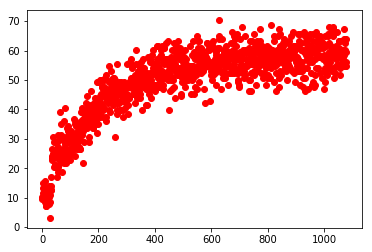

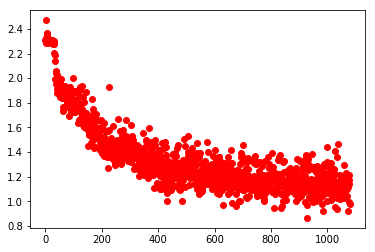

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

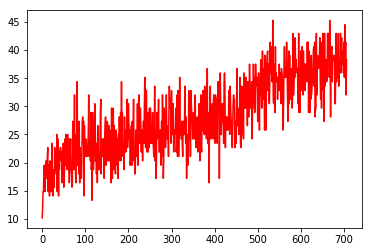

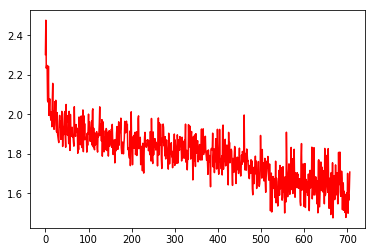

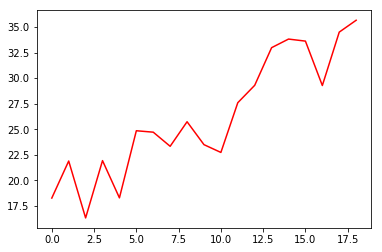

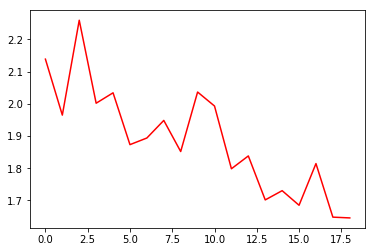

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()